# Kennedy and O'Hagan (KOH) Bayesian Model Calibration Example

이 노트북은 **Kennedy and O'Hagan (2001)**의 Bayesian Model Calibration 프레임워크를 PyMC를 사용하여 구현한 완전한 예제입니다. 

## 목표

이 예제의 주요 목표는 다음과 같습니다:
- 컴퓨터 시뮬레이션 데이터와 실제 관측 데이터를 통합하여 물리적 파라미터를 추정
- 모델의 불완전성을 명시적으로 고려한 바이어스 텀(model discrepancy) 포함
- Gaussian Process를 활용한 시뮬레이션 함수 에뮬레이션
- MCMC 샘플링을 통한 Bayesian 추론 및 불확실성 정량화

## 활용 분야

이 방법론은 다음과 같은 분야에 적용 가능합니다:
- 건축물 에너지 모델링 및 성능 평가
- 환경 시스템 모델링
- 공학 설계 최적화
- 기후 모델 검증 및 보정

## Kennedy and O’Hagan (KOH) 의 Bayesian Model Calibration

KOH framework는 실제 측정된 데이터의 값 z를 다음과 같이 모델링합니다.

$$
z = \rho \ \eta(x, t) + \delta(x) + e
$$

* $\eta(x, t)$ 는 컴퓨터 시뮬레이션 코드의 함수이며 $x$는 함수의 인자, $t$는 함수의 파라미터로 해석할 수 있습니다.  
* $\delta(x)$는 컴퓨터 시뮬레이터와 실제 물리 프로세스 사이의 차이를 나타냅니다.
* $e$는 관측 에러로 시뮬레이터 에러와 관측 에러를 모두 포함합니다.

$\eta(x, t)$와 $\delta(x)$는 Gaussian Process의 형태로 가정됩니다.

컴퓨터 시뮬레이션 코드의 데이터는 미리 지정된 $(y_i, x_i, t_i)$로 주어지며 관측된 물리 프로세스의 데이터는 $(z_i, x_i, \theta)$ 로 주어집니다.   
여기서 $y_i$는 시뮬레이션 코드의 아웃풋을 나타내며 관측된 $\theta$는 물리 프로세스에 가장 적합한 모델 파라미터값 입니다.  
$\theta$값은 알 수 없기 때문에 이 역시 MCMC 샘플링의 대상입니다.

2개의 observed data가 설정되며 각각 다음과 같습니다
$$

\begin{align}
y_i &\sim N(f_{c,i}, \sigma_c^2) \\
f_{c,i} &\sim \text{GP for } \eta
\end{align}
$$

$$
\begin{align}
z_i &\sim N(f_{p,i}, \sigma^2) \\
f_{p,i} &\sim \text{GP for } \eta + \text{GP for } \delta
\end{align}
$$

모든 관측 에러는 노말 분포로 가정되었으며 따라서 전체 관측에러인 컴퓨터 에러, 실험 관측에러의 합은 여전히 노말 분포로 표현할 수 있습니다.

## 1. 라이브러리 임포트 및 환경 설정

이 섹션에서는 Bayesian 추론과 Gaussian Process 모델링에 필요한 핵심 라이브러리들을 임포트합니다. 각 라이브러리의 역할을 이해하는 것이 코드 전체의 이해에 중요합니다.

In [77]:
# =============================================================================
# 라이브러리 임포트
# =============================================================================
# 이 예제에서 사용되는 주요 라이브러리들입니다.

# 핵심 Bayesian 추론 라이브러리
import pymc as pm  # Bayesian 통계 모델링과 MCMC (Markov Chain Monte Carlo) 추론을 위한 메인 라이브러리
import numpy as np  # 수치 연산과 다차원 배열 처리

# Bayesian 분석 결과 처리 및 시각화
import arviz as az  # Bayesian 분석 결과의 요약, 시각화, 수렴성 진단 도구

# 데이터 처리 및 분석
import pandas as pd  # 표 형식 데이터의 입출력 및 분석 (CSV 파일 읽기)

# 시각화
import matplotlib.pyplot as plt  # 2D 데이터 시각화 및 플롯 생성

# 저수준 텐서 연산 지원 (PyMC 내부 사용)
import pytensor.tensor as pt  # PyMC의 백엔드로 사용되는 심볼릭 텐서 연산 라이브러리
                                # 자동 미분 및 그래디언트 계산에 사용됨

## 2. 데이터 임포트 및 탐색적 분석

이 섹션에서는 다음과 같은 작업을 수행합니다:
1. 컴퓨터 시뮬레이션 데이터와 실제 관측 데이터를 로드
2. 데이터의 구조와 변수 의미 파악
3. 기본 통계량 확인

데이터의 구조와 특성을 정확히 이해하는 것이 올바른 Bayesian 모델링의 기초가 됩니다.

In [78]:
# =============================================================================
# 데이터 파일 로드
# =============================================================================
# 데이터 파일 경로:
# - datacomp_hourly.csv: 컴퓨터 시뮬레이션으로 생성된 데이터
# - datafield_hourly.csv: 실제 건물에서 측정된 관측 데이터
#
# 변수명 규칙:
# - c: computed (계산된 시뮬레이션 데이터)
# - f: field (실제 관측된 물리적 프로세스 데이터)

# 컴퓨터 시뮬레이션 데이터 로드
df_c = pd.read_csv("../dataset/datacomp_hourly.csv")

# 실제 관측 데이터 로드
df_f = pd.read_csv("../dataset/datafield_hourly.csv")

In [79]:
# =============================================================================
# 컴퓨터 시뮬레이션 데이터 구조 확인
# =============================================================================
# 시뮬레이션 데이터의 변수 구성:
# - yc: 에너지 사용량 (시뮬레이션 코드의 출력값, 단위: W/m²)
# - xc1: 외기온도 (첫 번째 입력 변수, 단위: °C)
# - xc2: 상대습도 (두 번째 입력 변수, 단위: %)
# - tc1: 기기밀도 (Equipment Density, 시뮬레이션에 사용된 파라미터, 단위: W/m²)
# - tc2: 조명밀도 (Lighting Density, 시뮬레이션에 사용된 파라미터, 단위: W/m²)
# - tc3: COP (Coefficient of Performance, 시뮬레이션에 사용된 파라미터, 무차원)

print("컴퓨터 시뮬레이션 데이터 구조:")
print(f"데이터 크기: {df_c.shape[0]}개 샘플, {df_c.shape[1]}개 변수")
print("\n컬럼명:")
print(df_c.columns.tolist())
print("\n데이터 미리보기:")
df_c

컴퓨터 시뮬레이션 데이터 구조:
데이터 크기: 240개 샘플, 6개 변수

컬럼명:
['yc', 'xc1', 'xc2', 'tc1', 'tc2', 'tc3']

데이터 미리보기:


,yc,xc1,xc2,tc1,tc2,tc3
0,128.62,25.80,76.83,8.56,5.37,3.10
1,96.13,25.62,77.17,8.56,5.37,3.10
2,85.19,25.32,79.17,8.56,5.37,3.10
3,85.19,25.03,81.17,8.56,5.37,3.10
4,81.71,24.73,83.17,8.56,5.37,3.10
...,...,...,...,...,...,...
235,548.76,27.22,74.58,9.26,7.65,2.89
236,504.63,26.62,75.58,9.26,7.65,2.89
237,439.27,26.32,76.58,9.26,7.65,2.89
238,348.70,26.03,78.75,9.26,7.65,2.89


In [80]:
# =============================================================================
# 실제 관측 데이터 구조 확인
# =============================================================================
# 관측 데이터의 변수 구성:
# - yf (또는 zf): 에너지 사용량 (실제 건물에서 측정된 값, 단위: W/m²)
# - xf1: 외기온도 (첫 번째 입력 변수, 시뮬레이션과 동일한 조건, 단위: °C)
# - xf2: 상대습도 (두 번째 입력 변수, 시뮬레이션과 동일한 조건, 단위: %)
#
# ⚠️ 중요: 실제 데이터에는 추정 대상 파라미터(tc1, tc2, tc3)가 포함되어 있지 않습니다.
# 이 파라미터들이 Bayesian 추론을 통해 추정하고자 하는 미지수입니다.

print("실제 관측 데이터 구조:")
print(f"데이터 크기: {df_f.shape[0]}개 샘플, {df_f.shape[1]}개 변수")
print("\n컬럼명:")
print(df_f.columns.tolist())
print("\n데이터 미리보기:")
df_f

실제 관측 데이터 구조:
데이터 크기: 24개 샘플, 3개 변수

컬럼명:
['yf', 'xf1', 'xf2']

데이터 미리보기:


,yf,xf1,xf2
0,143.62,25.80,76.83
1,109.34,25.63,77.17
2,95.08,25.33,79.17
3,95.08,25.03,81.17
4,90.93,24.73,83.17
5,97.50,24.43,85.17
6,123.77,24.13,87.17
7,159.02,23.83,89.17
8,134.83,23.99,89.42
9,103.03,24.67,86.67


## 3. 데이터 시각화 및 탐색적 분석

이 섹션에서는 데이터의 공간적 분포와 패턴을 시각화하여 다음을 파악합니다:
- 실제 관측 데이터의 2차원 공간 분포
- 입력 변수(외기온도, 상대습도)와 출력 변수(에너지 사용량) 간의 관계
- 데이터 포인트들의 공간적 위치와 값

이러한 시각화는 모델 선택과 결과 해석에 도움이 됩니다. 

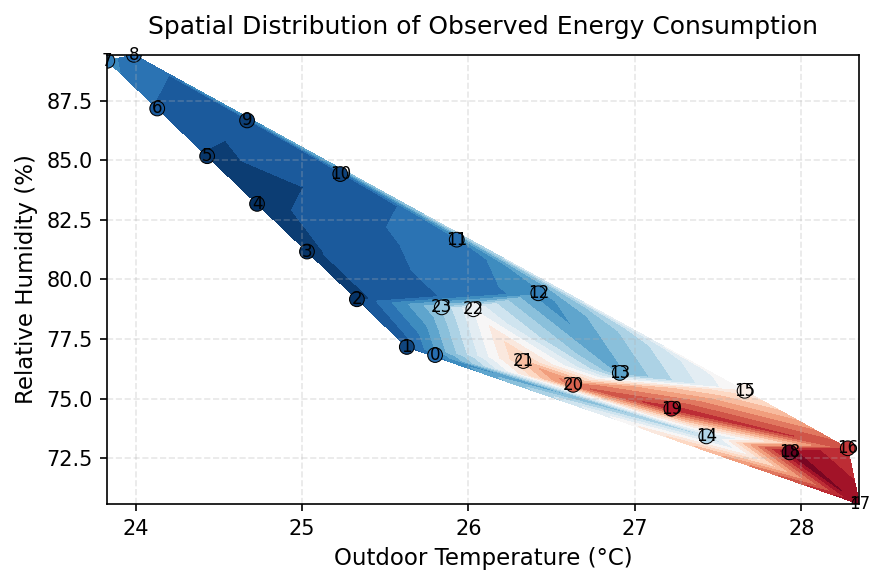

In [81]:
# =============================================================================
# 실제 관측 데이터의 2차원 공간 분포 시각화
# =============================================================================
# 목적: 입력 변수 공간(외기온도 × 상대습도)에서 에너지 사용량의 분포 패턴을 파악
#
# df_f 데이터 구조: [yf(zf), xf1, xf2]
# - df_f.iloc[:, 0]: 실제 측정값 (에너지 사용량)
# - df_f.iloc[:, 1]: 외기온도 (첫 번째 입력 변수)
# - df_f.iloc[:, 2]: 상대습도 (두 번째 입력 변수)

# 플롯 설정: 고해상도 플롯 생성 (6×4 인치, 150 DPI)
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

# 삼각분할 등고선 플롯 (filled contour)
# 비정규 격자 데이터를 부드러운 등고선으로 표현
# - x좌표: 외기온도 (df_f.iloc[:, 1])
# - y좌표: 상대습도 (df_f.iloc[:, 2])
# - z값: 에너지 사용량 (df_f.iloc[:, 0])
# - levels=20: 20개의 등고선 레벨로 세밀한 분포 표현
# - cmap="RdBu_r": 빨강-파랑 색상 맵 (역순, 높은 값이 파란색)
ax.tricontourf(
    df_f.iloc[:, 1],  # x좌표: 외기온도
    df_f.iloc[:, 2],  # y좌표: 상대습도
    df_f.iloc[:, 0],  # z값: 에너지 사용량
    levels=20,
    cmap="RdBu_r"
)

# 실제 데이터 포인트들을 산점도로 표시
# 각 점의 색상은 해당 위치의 측정값에 따라 결정됨
ax.scatter(
    df_f.iloc[:, 1],  # x좌표
    df_f.iloc[:, 2],  # y좌표
    c=df_f.iloc[:, 0],  # 색상은 측정값에 따라 결정
    cmap="RdBu_r",
    s=50,  # 마커 크기
    edgecolors='black',  # 검은색 테두리로 가시성 향상
    linewidths=0.5
)

# 각 데이터 포인트에 인덱스 번호를 텍스트로 표시
# 데이터 점 식별 및 추후 분석 참조용
for i in range(df_f.shape[0]):
    ax.text(
        df_f.iloc[i, 1],  # x좌표 (외기온도)
        df_f.iloc[i, 2],  # y좌표 (상대습도)
        str(i),           # 포인트 인덱스 번호
        color="black",    # 검은색 텍스트로 가시성 확보
        fontsize=8,
        ha='center',
        va='center'
    )

# 축 레이블과 제목 설정
ax.set_xlabel("Outdoor Temperature (°C)", fontsize=11)
ax.set_ylabel("Relative Humidity (%)", fontsize=11)
ax.set_title("Spatial Distribution of Observed Energy Consumption", fontsize=12, pad=10)

# 그리드 추가 (가독성 향상)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

## 4. Bayesian Inference 모델 정의

이 섹션에서는 PyMC를 사용하여 KOH 프레임워크 기반 Bayesian 모델을 정의합니다. 

### 모델 구성 요소

1. **eta GP**: 시뮬레이션 함수 $\eta(\mathbf{x}, \boldsymbol{\theta})$ 에뮬레이터 (5차원 입력: $x_1, x_2, \theta_1, \theta_2, \theta_3$)
2. **delta GP**: 모델 불일치 함수 $\delta(\mathbf{x})$ (2차원 입력: $x_1, x_2$)
3. **칼리브레이션 파라미터**: $\boldsymbol{\theta}_{true}$ (추정 대상)
4. **노이즈 파라미터**: $\sigma_c$, $\sigma$

모델은 컴퓨터 시뮬레이션 데이터와 실제 관측 데이터를 통합하여 물리적 파라미터와 모델 불일치 함수를 함께 추정합니다.

### 4-1. 데이터 탐색 및 통계 요약

모델 정의 전에 데이터의 기본 통계량을 확인하여 다음을 파악합니다:
- 변수들의 범위와 분포 특성
- 이상치(outlier) 존재 여부
- 적절한 사전 분포 설정을 위한 정보

이 정보는 사전 분포의 범위와 형태를 결정하는 데 활용됩니다.

In [82]:
# =============================================================================
# 컴퓨터 시뮬레이션 데이터의 기본 통계량 확인
# =============================================================================
# 목적: 데이터의 분포, 범위, 중심 경향 등을 파악하여 적절한 사전 분포 설정에 활용
# 출력 내용: 각 변수의 개수, 평균, 표준편차, 최솟값, 25%, 50%, 75% 백분위수, 최댓값

print("컴퓨터 시뮬레이션 데이터 통계 요약:")
print("=" * 80)
df_c.describe()

컴퓨터 시뮬레이션 데이터 통계 요약:


,yc,xc1,xc2,tc1,tc2,tc3
count,240.000000,240.00000,240.000000,240.000000,240.000000,240.000000
mean,238.212208,25.98625,79.417500,8.001000,6.422000,2.916000
std,153.872389,1.33510,5.316637,0.919768,0.734154,0.337964
min,81.710000,23.82000,70.580000,6.630000,5.370000,2.430000
25%,111.735000,24.95500,75.517500,7.100000,5.720000,2.610000
50%,161.390000,25.88000,78.790000,8.015000,6.360000,2.905000
75%,355.855000,26.98750,83.482500,8.670000,7.170000,3.240000
max,590.090000,28.35000,89.420000,9.340000,7.650000,3.450000


In [83]:
# =============================================================================
# 실제 관측 데이터의 기본 통계량 확인
# =============================================================================
# 목적: 관측 데이터의 분포와 특성을 파악하여 모델 검증 및 결과 해석에 활용

print("실제 관측 데이터 통계 요약:")
print("=" * 80)
df_f.describe()

실제 관측 데이터 통계 요약:


,yf,xf1,xf2
count,24.000000,24.000000,24.00000
mean,237.079167,25.990000,79.41750
std,154.280131,1.359767,5.41966
min,90.930000,23.830000,70.58000
25%,108.802500,24.955000,75.51750
50%,160.140000,25.885000,78.79000
75%,339.160000,26.987500,83.48250
max,533.400000,28.350000,89.42000


### 4-2. 데이터 정규화 (Data Normalization)

Bayesian 추론과 Gaussian Process 모델링에서 데이터 정규화는 **수치적 안정성과 수렴성을 위해 필수적**입니다.

#### 정규화가 필요한 이유

1. **수치적 안정성**: 서로 다른 스케일의 변수들을 동일한 범위로 변환하여 계산 오차 감소
2. **수렴성 향상**: GP의 length-scale 파라미터가 모든 차원에서 비슷한 범위를 가지도록 하여 MCMC 샘플링 효율성 증대
3. **공정한 비교**: 모든 입력 차원이 동일한 가중치로 처리

#### 정규화 방법

이 예제에서는 **Min-Max Scaling**을 사용하여 모든 변수를 [0, 1] 범위로 변환합니다:

$$x_{\text{normalized}} = \frac{x - x_{\min}}{x_{\max} - x_{\min}}$$

**중요**: 시뮬레이션 데이터와 관측 데이터는 **동일한 정규화 파라미터**를 사용해야 모델이 올바르게 작동합니다.


In [84]:
# =============================================================================
# 데이터 정규화 (Min-Max Scaling)
# =============================================================================
# 목적: 모든 데이터를 [0, 1] 범위로 정규화하여 Gaussian Process 모델링의 수치적 안정성 확보
# 방법: Min-Max Scaling 공식 사용: x_normalized = (x - x_min) / (x_max - x_min)
#
# ⚠️ 중요: 시뮬레이션과 관측 데이터는 동일한 정규화 파라미터를 사용해야 함
#         그렇지 않으면 두 데이터가 다른 스케일에 있어 모델이 올바르게 작동하지 않음

print("=" * 80)
print("컴퓨터 시뮬레이션 데이터 정규화")
print("=" * 80)

# -----------------------------------------------------------------------------
# 1. 시뮬레이션 출력값 (y) 정규화
# -----------------------------------------------------------------------------
# df_c.iloc[:, 0]: 시뮬레이션 코드의 출력값 (에너지 사용량)
y = df_c.iloc[:, 0].values
y_min = y.min()  # 최솟값 저장 (나중에 역변환용으로 필요)
y_max = y.max()  # 최댓값 저장 (나중에 역변환용으로 필요)
y = (y - y_min) / (y_max - y_min)  # Min-Max 정규화: (값 - 최솟값) / (최댓값 - 최솟값)
print(f"✓ y (시뮬레이션 출력) 정규화: [{y_min:.2f}, {y_max:.2f}] → [0, 1]")

# -----------------------------------------------------------------------------
# 2. 시뮬레이션 입력 변수 (x_c) 정규화
# -----------------------------------------------------------------------------
# df_c.iloc[:, 1:3]: 공간 좌표 (x1: 외기온도, x2: 상대습도)
x_c = df_c.iloc[:, 1:3].values
x_c_min = x_c.min(axis=0)  # 각 차원별 최솟값 [x1_min, x2_min]
x_c_max = x_c.max(axis=0)    # 각 차원별 최댓값 [x1_max, x2_max]
x_c = (x_c - x_c_min) / (x_c_max - x_c_min)  # 차원별로 독립적으로 Min-Max 정규화
print(f"✓ x_c (입력 변수) 정규화: 각 차원별로 [0, 1] 범위로 변환")
print(f"  - x1 (외기온도) 범위: [{x_c_min[0]:.2f}, {x_c_max[0]:.2f}] → [0, 1]")
print(f"  - x2 (상대습도) 범위: [{x_c_min[1]:.2f}, {x_c_max[1]:.2f}] → [0, 1]")

# -----------------------------------------------------------------------------
# 3. 시뮬레이션 파라미터 (theta) 정규화
# -----------------------------------------------------------------------------
# df_c.iloc[:, 3:]: 모델 파라미터 (theta1: 기기밀도, theta2: 조명밀도, theta3: COP)
# 물리적으로 파라미터는 양수이므로 하한선을 0으로 고정
theta = df_c.iloc[:, 3:].values
theta_min = 0  # 하한선을 0으로 고정 (물리적 제약: 양수 파라미터)
theta_max = theta.max(axis=0)  # 각 파라미터별 최댓값 [theta1_max, theta2_max, theta3_max]
theta = (theta - theta_min) / (theta_max - theta_min)  # [0, 최댓값] → [0, 1] 범위로 정규화
print(f"✓ theta (파라미터) 정규화: [0, {theta_max}] → [0, 1]")
print(f"  - theta1 (기기밀도) 범위: [0, {theta_max[0]:.2f}] → [0, 1]")
print(f"  - theta2 (조명밀도) 범위: [0, {theta_max[1]:.2f}] → [0, 1]")
print(f"  - theta3 (COP) 범위: [0, {theta_max[2]:.2f}] → [0, 1]")

print(f"\n정규화된 시뮬레이션 데이터 크기:")
print(f"  - y: {y.shape}, x_c: {x_c.shape}, theta: {theta.shape}")

print("\n" + "=" * 80)
print("실제 관측 데이터 정규화 (시뮬레이션과 동일한 파라미터 사용)")
print("=" * 80)

# -----------------------------------------------------------------------------
# 4. 실제 관측 출력값 (z) 정규화
# -----------------------------------------------------------------------------
# 위에서 계산한 y_min, y_max를 사용하여 동일한 스케일 적용
# ⚠️ 중요: 관측 데이터의 범위가 시뮬레이션 범위를 벗어날 수 있으므로 주의 필요
z = df_f.iloc[:, 0].values
z = (z - y_min) / (y_max - y_min)  # y의 정규화 파라미터를 그대로 사용
print(f"✓ z (관측 출력) 정규화: y와 동일한 스케일 적용")
print(f"  - 원본 범위: [{df_f.iloc[:, 0].min():.2f}, {df_f.iloc[:, 0].max():.2f}]")
print(f"  - 정규화 기준: [{y_min:.2f}, {y_max:.2f}] → [0, 1]")

# -----------------------------------------------------------------------------
# 5. 실제 관측 좌표 (x_p) 정규화
# -----------------------------------------------------------------------------
# 위에서 계산한 x_c_min, x_c_max를 사용하여 동일한 스케일 적용
x_p = df_f.iloc[:, 1:3].values
x_p = (x_p - x_c_min) / (x_c_max - x_c_min)  # x_c의 정규화 파라미터를 그대로 사용
print(f"✓ x_p (관측 좌표) 정규화: x_c와 동일한 스케일 적용")

print(f"\n정규화된 관측 데이터 크기:")
print(f"  - z: {z.shape}, x_p: {x_p.shape}")

print("\n" + "=" * 80)
print("정규화 완료: 모든 변수가 [0, 1] 범위에 있음")
print("=" * 80)

컴퓨터 시뮬레이션 데이터 정규화
✓ y (시뮬레이션 출력) 정규화: [81.71, 590.09] → [0, 1]
✓ x_c (입력 변수) 정규화: 각 차원별로 [0, 1] 범위로 변환
  - x1 (외기온도) 범위: [23.82, 28.35] → [0, 1]
  - x2 (상대습도) 범위: [70.58, 89.42] → [0, 1]
✓ theta (파라미터) 정규화: [0, [9.34 7.65 3.45]] → [0, 1]
  - theta1 (기기밀도) 범위: [0, 9.34] → [0, 1]
  - theta2 (조명밀도) 범위: [0, 7.65] → [0, 1]
  - theta3 (COP) 범위: [0, 3.45] → [0, 1]

정규화된 시뮬레이션 데이터 크기:
  - y: (240,), x_c: (240, 2), theta: (240, 3)

실제 관측 데이터 정규화 (시뮬레이션과 동일한 파라미터 사용)
✓ z (관측 출력) 정규화: y와 동일한 스케일 적용
  - 원본 범위: [90.93, 533.40]
  - 정규화 기준: [81.71, 590.09] → [0, 1]
✓ x_p (관측 좌표) 정규화: x_c와 동일한 스케일 적용

정규화된 관측 데이터 크기:
  - z: (24,), x_p: (24, 2)

정규화 완료: 모든 변수가 [0, 1] 범위에 있음


### 4-3. PyMC 모델 정의 및 구조

이 섹션에서는 KOH 프레임워크에 따라 PyMC 모델을 정의합니다. 

#### 모델의 핵심 구성 요소

1. **$\eta$ GP (시뮬레이션 함수 에뮬레이터)**
   - 입력 차원: 5차원 ($x_1, x_2, \theta_1, \theta_2, \theta_3$)
   - 역할: 컴퓨터 시뮬레이션 함수 $\eta(\mathbf{x}, \boldsymbol{\theta})$를 에뮬레이션
   - 커널: Exponential Quadratic (RBF) 커널
   
2. **$\delta$ GP (모델 불일치 함수)**
   - 입력 차원: 2차원 ($x_1, x_2$)
   - 역할: 시뮬레이터와 실제 물리 프로세스 사이의 체계적 차이 모델링
   - 커널: Exponential Quadratic (RBF) 커널

#### 모델링 전략

- **Latent GP 사용**: 두 GP를 결합하기 위해 latent GP 형식을 사용
- **통합된 입력 공간**: 시뮬레이션과 관측 데이터를 하나의 eta GP로 모델링하여 정보 공유
- **사전 분포 설정**: 물리적으로 타당한 범위를 가지는 약한 정보 사전 분포 사용

In [85]:
# =============================================================================
# 물리적 파라미터 theta_true의 사전 분포 범위 정의
# =============================================================================
# 목적: theta_true에 대한 Uniform 사전 분포의 상한선 설정
#
# 해석:
# - 원래 물리적 단위에서 최대값 [10, 10, 5]를 가정 (예: 기기밀도 10 W/m², 조명밀도 10 W/m², COP 5)
# - 이를 정규화된 스케일로 변환하여 사전 분포 정의에 사용
# - theta_max는 위에서 정규화에 사용된 최댓값 벡터

# 물리적으로 타당한 최대값 (정규화 전 물리적 단위)
# [기기밀도 최대값, 조명밀도 최대값, COP 최대값]
theta_max_physical = np.array([10, 10, 5])

# 정규화된 스케일로 변환: 물리적 최대값 / 정규화 시 사용된 최댓값
theta_max_prior = theta_max_physical / theta_max

print("=" * 80)
print("theta_true 사전 분포 범위 설정")
print("=" * 80)
print(f"물리적 단위 최대값: {theta_max_physical}")
print(f"정규화 시 사용된 최댓값: {theta_max}")
print(f"정규화된 스케일 최대값: {theta_max_prior}")
print("\n사전 분포: Uniform(lower=0, upper=theta_max_prior)")
print(f"  - theta_true[0] (기기밀도): [0, {theta_max_prior[0]:.4f}]")
print(f"  - theta_true[1] (조명밀도): [0, {theta_max_prior[1]:.4f}]")
print(f"  - theta_true[2] (COP): [0, {theta_max_prior[2]:.4f}]")
print("=" * 80)

theta_max_prior

theta_true 사전 분포 범위 설정
물리적 단위 최대값: [10 10  5]
정규화 시 사용된 최댓값: [9.34 7.65 3.45]
정규화된 스케일 최대값: [1.07066381 1.30718954 1.44927536]

사전 분포: Uniform(lower=0, upper=theta_max_prior)
  - theta_true[0] (기기밀도): [0, 1.0707]
  - theta_true[1] (조명밀도): [0, 1.3072]
  - theta_true[2] (COP): [0, 1.4493]


array([1.07066381, 1.30718954, 1.44927536])

In [86]:
with pm.Model() as koh_model:
    # ============================================================
    # 1. 컴퓨터 모델 에뮬레이터 GP (eta) 정의
    # ============================================================
    # eta GP는 5차원 입력 공간 (x1, x2, theta1, theta2, theta3)에서 동작
    # 이를 통해 시뮬레이션 함수 eta(x, theta)를 에뮬레이트
    
    # Length-scale 파라미터: 각 입력 차원에서의 함수 변동성 특성을 제어
    # Gamma 분포 사용 이유: 양수만 허용 (분모에 사용되므로 0이면 안됨)
    # shape=5: 5개 입력 차원 (x1, x2, theta1, theta2, theta3) 각각에 대한 독립적인 length-scale
    ls_eta = pm.Gamma("ls_eta", alpha=2, beta=0.5, shape=5)

    # Amplitude 파라미터: GP 함수 값의 전체적인 변동 폭을 결정
    # HalfCauchy 분포 사용 이유: 0을 포함한 양수 허용, heavy-tail로 유연한 사전 분포
    eta_eta = pm.HalfCauchy("eta_eta", beta=1)

    # 커널 함수 정의: Exponential Quadratic (RBF) 커널
    # k(x_i, x_j) = eta^2 * exp(-0.5 * sum((x_i - x_j)^2 / ls^2))
    cov_eta = eta_eta**2 * pm.gp.cov.ExpQuad(input_dim=5, ls=ls_eta)
    
    # Latent GP 정의: eta 함수를 직접 모델링
    # Latent GP를 사용하는 이유: 두 개의 GP(eta, delta)를 결합해야 하므로
    gp_eta = pm.gp.Latent(cov_func=cov_eta)

    # ============================================================
    # 2. 모델 불일치 함수 GP (delta) 정의
    # ============================================================
    # delta GP는 2차원 입력 공간 (x1, x2)에서 동작
    # 이를 통해 시뮬레이터와 실제 물리 프로세스 사이의 체계적 차이를 모델링
    
    # Length-scale 파라미터: 공간 변수(x1, x2)에 대한 함수 변동성
    # shape=2: 2개 입력 차원 (x1, x2) 각각에 대한 독립적인 length-scale
    ls_delta = pm.Gamma("ls_delta", alpha=2, beta=0.5, shape=2)
    
    # Amplitude 파라미터: 모델 불일치 함수의 변동 폭
    eta_delta = pm.HalfCauchy("eta_delta", beta=1)
    
    # 커널 함수 정의: Exponential Quadratic (RBF) 커널
    cov_delta = eta_delta**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ls_delta)
    
    # Latent GP 정의: delta 함수를 직접 모델링
    gp_delta = pm.gp.Latent(cov_func=cov_delta)

    # ============================================================
    # 3. 시뮬레이션 데이터 입력 구성
    # ============================================================
    # 시뮬레이션 데이터의 입력: 공간 좌표(x_c)와 파라미터(theta) 결합
    # theta는 시뮬레이션에 사용된 다양한 파라미터 값들
    X_c = np.hstack([x_c, theta])  # (n_sim, 5) 형태: (x1, x2, theta1, theta2, theta3)

    # ============================================================
    # 4. 물리적 파라미터 추정을 위한 사전 분포 정의
    # ============================================================
    # theta_true: 추정하고자 하는 미지의 물리적 파라미터 (theta1, theta2, theta3)
    # Uniform 분포 사용 이유: 
    #   - 파라미터가 음수가 될 수 없는 물리적 제약
    #   - theta_max_prior까지의 범위에서 균등 분포로 약한 정보 제공
    #   - 변수명을 theta에서 theta_true로 변경하여 시뮬레이션 파라미터(theta)와 구분
    theta_true = pm.Uniform("theta_true", lower=0, upper=theta_max_prior, shape=3)

    # ============================================================
    # 5. 실제 관측 데이터 입력 구성
    # ============================================================
    # 모든 관측치가 동일한 물리 시스템(동일한 theta_true)에서 나왔다고 가정
    # pt.tile을 사용하여 theta_true를 관측치 개수만큼 복제
    X_p = pt.concatenate([x_p, pt.tile(theta_true, (x_p.shape[0], 1))], axis=1)  # (n_obs, 5)

    # ============================================================
    # 6. 전체 입력 데이터 통합
    # ============================================================
    # 시뮬레이션과 실제 관측 데이터를 수직으로 결합하여 하나의 eta GP로 모델링
    # 이를 통해 시뮬레이션 정보가 theta_true 추정에 활용됨
    X_all = pt.concatenate([X_c, X_p], axis=0)  # (n_sim + n_obs, 5)

    # eta GP의 prior 함수값 계산: 모든 입력점(시뮬레이션 + 관측)에서의 함수값
    f_c = gp_eta.prior("f_c", X=X_all)

    # ============================================================
    # 7. 시뮬레이션 관측 모델 정의
    # ============================================================
    # 컴퓨터 시뮬레이션 노이즈 정의
    # sigma_c: 시뮬레이션 과정에서 발생하는 랜덤 노이즈의 표준편차
    # HalfNormal 분포 사용 이유: 양수 제약, 데이터 정규화로 인해 작은 값(0.01) 사용
    sigma_c = pm.HalfNormal("sigma_c", sigma=0.01)

    # 시뮬레이션 관측 데이터 정의
    # f_c[:len(y)]: 시뮬레이션 입력점들에서의 eta 함수값
    y_obs = pm.Normal("y_obs", mu=f_c[:len(y)], sigma=sigma_c, observed=y)

    # ============================================================
    # 8. 실제 관측 모델 정의 (KOH 프레임워크)
    # ============================================================
    # 실제 물리 프로세스는 eta + delta로 모델링됨
    
    # f_p_eta: 실제 관측 입력점들에서의 eta 함수값
    # f_c[len(y):]는 관측 입력점들에서의 eta 함수값을 포함
    f_p_eta = pm.Deterministic("f_p_eta", f_c[len(y):])
    
    # f_p_delta: 모델 불일치 함수값 (2차원 입력 x_p만 사용)
    f_p_delta = gp_delta.prior("f_p_delta", X=x_p)

    # f_p: 실제 물리 프로세스 함수값 = eta + delta
    f_p = pm.Deterministic("f_p", f_p_eta + f_p_delta)

    # 실제 관측 노이즈 정의
    # sigma: 시뮬레이션 노이즈(sigma_c)와 추가 관측 노이즈(sigma_p)의 합
    # 이는 실제 관측 과정에서 발생하는 전체 노이즈를 나타냄
    sigma = pm.Deterministic("sigma", sigma_c + pm.HalfNormal("sigma_p", sigma=0.01))

    # 실제 관측 데이터 정의
    # z_obs: 실제 측정값은 f_p (eta + delta)에 노이즈가 더해진 형태
    z_obs = pm.Normal("z_obs", mu=f_p, sigma=sigma, observed=z)

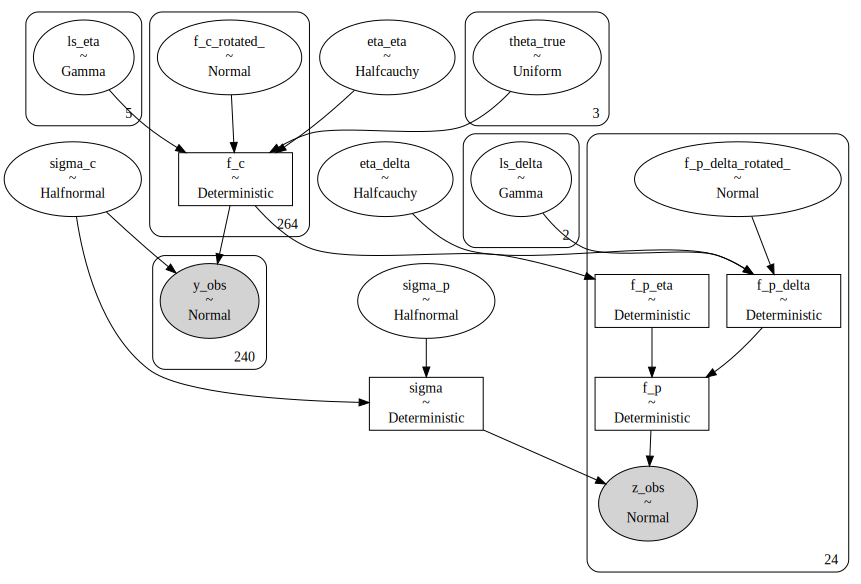

In [87]:
pm.model_to_graphviz(koh_model)

## 5. MCMC 샘플링 수행

이 섹션에서는 **NUTS (No-U-Turn Sampler)**를 사용하여 사후 분포에서 샘플링을 수행합니다.

### NUTS 샘플러

NUTS는 Hamiltonian Monte Carlo (HMC)의 개선된 버전으로, 다음과 같은 특징이 있습니다:
- **자동 튜닝**: Step size와 integration time을 자동으로 조정
- **효율적인 탐색**: 기울기 정보를 활용하여 빠르게 수렴
- **NumPyro 백엔드**: 빠른 성능과 GPU 지원 가능

### 샘플링 파라미터

- **draws**: 실제 샘플링할 개수 (사후 분포 근사용)
- **tune**: 워밍업 단계 길이 (샘플러 파라미터 튜닝)
- **chains**: 독립적인 샘플링 체인 수 (수렴성 진단용, 권장: 4개 이상)
- **target_accept**: 목표 수락률 (0.8-0.95 권장, 높을수록 보수적)

MCMC를 통해 다음의 사후 분포를 근사합니다:
- $\boldsymbol{\theta}_{true}$: 미지의 물리적 파라미터
- $\delta(\mathbf{x})$: 모델 불일치 함수
- GP 하이퍼파라미터: length-scales, amplitudes
- 노이즈 파라미터: $\sigma_c$, $\sigma$

In [88]:
# =============================================================================
# MCMC 샘플링 실행
# =============================================================================
# 목적: 사후 분포에서 샘플을 생성하여 모든 파라미터의 불확실성을 정량화
#
# 샘플러: NUTS (No-U-Turn Sampler)
# - Hamiltonian Monte Carlo (HMC)의 개선된 버전
# - 자동 튜닝: Step size와 integration time을 자동으로 조정
# - 효율적인 탐색: 기울기 정보를 활용하여 빠르게 수렴
#
# ⚠️ 참고: 단일 체인(chains=1)으로 실행 중이며, 실전에서는 4개 이상의 체인을 사용하는 것을 권장
#          다중 체인을 사용하면 R-hat 통계량으로 수렴성을 더 정확히 진단할 수 있음

with koh_model:
    trace = pm.sample(
        draws=1000,              # 실제 샘플링할 체인 길이 (사후 분포 근사용 샘플 개수)
        tune=1000,               # 워밍업/버닝 단계 길이 (샘플러 파라미터 자동 튜닝)
        chains=1,                # 독립적인 샘플링 체인 수 (수렴성 진단을 위해 4개 이상 권장)
        cores=1,                 # 병렬 처리에 사용할 CPU 코어 수
        nuts_sampler="numpyro",  # NumPyro 백엔드 사용 (JAX 기반, 빠른 성능 및 GPU 지원 가능)
        target_accept=0.95,      # 목표 수락률 (0.8-0.95 권장, 높을수록 보수적이고 안정적)
        random_seed=42,          # 재현성을 위한 시드 고정
    )
    
    # 샘플링 완료 후 진단 메시지 확인
    # - "divergences": sampler가 목표 분포에서 벗어난 샘플 수 (0에 가까울수록 좋음)
    #   많으면 target_accept를 높이거나 모델을 재파라미터화 고려
    # - 체인이 1개인 경우 일부 수렴성 진단 지표는 계산되지 않음

sample: 100%|██████████| 2000/2000 [1:45:37<00:00,  3.17s/it, 1023 steps of size 7.95e-04. acc. prob=0.91]
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


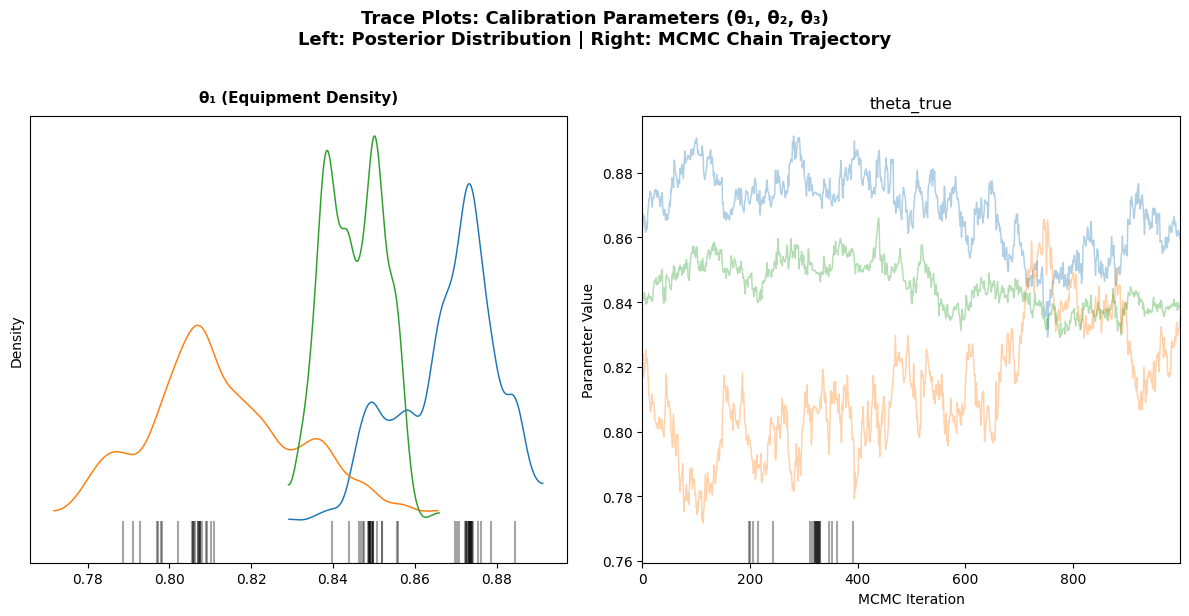

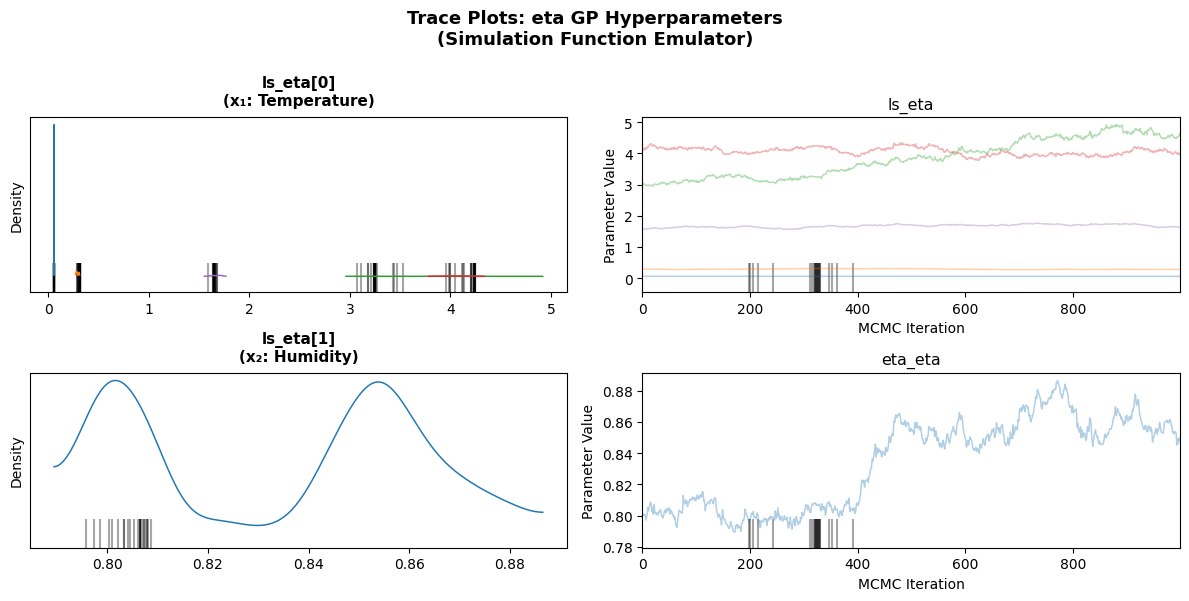

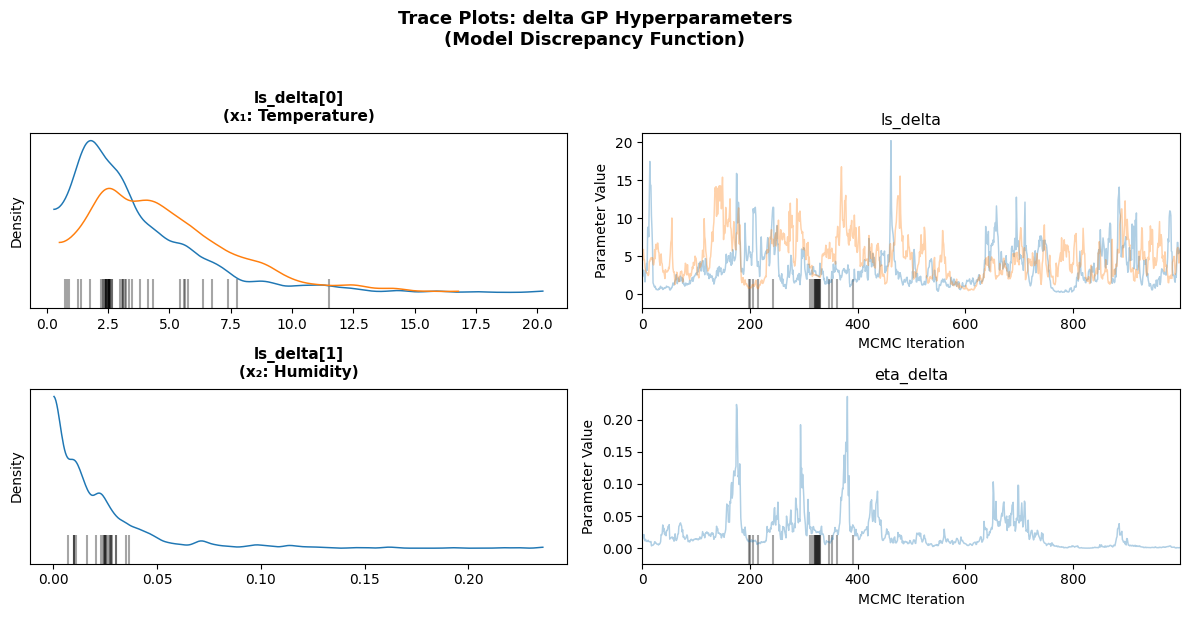

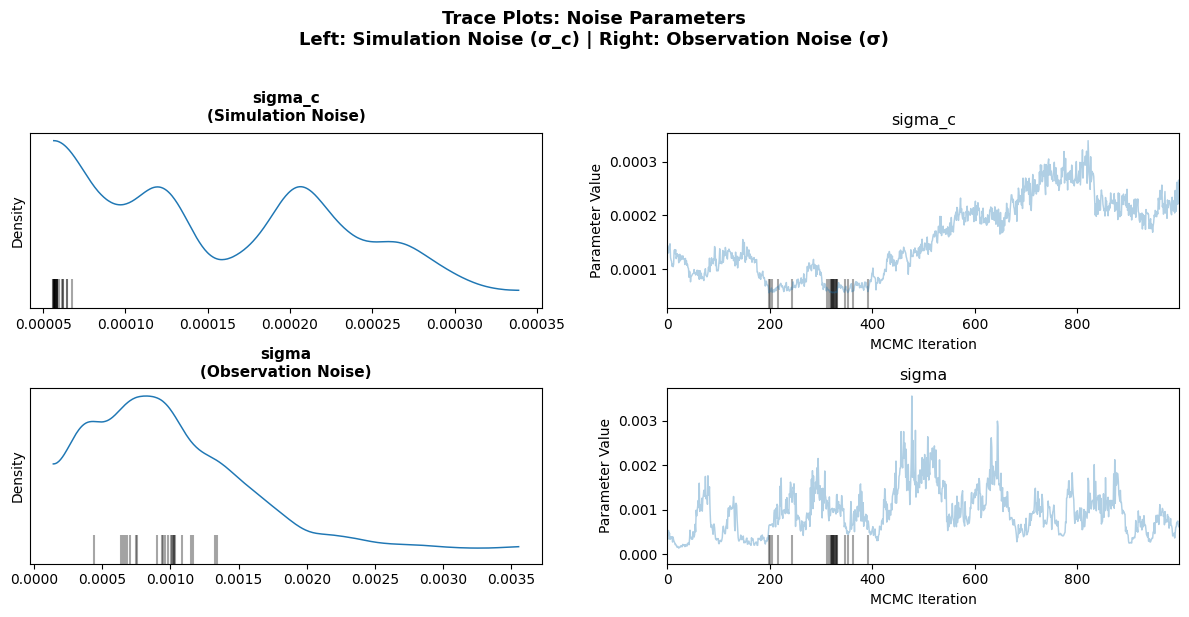

In [89]:
# =============================================================================
# 사후 분포 Trace 플롯 생성 및 시각화
# =============================================================================
# 
# Trace plot은 MCMC 샘플링 결과를 진단하는 핵심 도구입니다.
# 
# 구조:
# - 왼쪽 열: 각 파라미터의 사후 분포 히스토그램 (marginal posterior distribution)
#   → 파라미터의 불확실성과 분포 형태를 확인
# - 오른쪽 열: MCMC 샘플링 과정에서의 파라미터 값 변화 (chain trace)
#   → 수렴성, 자동상관, 시계열 패턴을 확인
#
# 관련 파라미터를 그룹별로 나누어 시각화함으로써 해석의 용이성을 높입니다.
# =============================================================================

# -----------------------------------------------------------------------------
# 플롯 설정 상수 정의
# -----------------------------------------------------------------------------
PLOT_FIGSIZE = (12, 6)  # 모든 플롯에 동일한 크기 적용 (너비, 높이)
FONT_SIZE_TITLE = 13     # 전체 플롯 제목 폰트 크기
FONT_SIZE_SUBTITLE = 11  # 개별 파라미터 서브플롯 제목 폰트 크기
FONT_SIZE_AXIS = 10      # 축 레이블 폰트 크기

# -----------------------------------------------------------------------------
# 반환값 처리 헬퍼 함수 정의
# -----------------------------------------------------------------------------
# az.plot_trace()는 버전/설정에 따라 다양한 형태의 반환값을 가질 수 있어서
# 안전하게 처리하기 위한 함수를 정의합니다.
def process_trace_result(trace_result):
    """
    az.plot_trace()의 반환값을 처리하여 figure와 axes를 추출합니다.
    
    Args:
        trace_result: az.plot_trace()의 반환값 (tuple, figure, 또는 axes 배열)
    
    Returns:
        fig: matplotlib Figure 객체
        axes: numpy array 형태의 axes 배열 (1D로 flatten)
    """
    if isinstance(trace_result, tuple) and len(trace_result) == 2:
        # (figure, axes) 튜플로 반환된 경우
        fig, axes = trace_result
    elif hasattr(trace_result, 'suptitle') or hasattr(trace_result, 'get_axes'):
        # Figure 객체로 반환된 경우
        fig = trace_result
        try:
            axes = np.array(fig.get_axes())
        except:
            axes = np.array(fig.axes) if hasattr(fig, 'axes') else np.array([])
    else:
        # axes 배열만 반환된 경우
        if isinstance(trace_result, (list, np.ndarray)):
            axes = np.array(trace_result)
        else:
            axes = np.array([trace_result])
        # 첫 번째 axes에서 figure 추출 (없으면 현재 figure 사용)
        try:
            fig = axes[0].figure if hasattr(axes[0], 'figure') and axes[0].figure is not None else plt.gcf()
        except:
            fig = plt.gcf()
    
    # axes를 1D 배열로 flatten (이미 1D인 경우도 대비)
    axes = np.array(axes).flatten()
    return fig, axes

# =============================================================================
# 1. 칼리브레이션 파라미터 Trace Plot
# =============================================================================
# theta_true는 모델 칼리브레이션의 핵심으로, 실제 물리 프로세스의 파라미터입니다.
# 3개 파라미터 (θ₁: Equipment Density, θ₂: Lighting Density, θ₃: COP)를 포함합니다.

trace_result = az.plot_trace(
    trace, 
    var_names=["theta_true"],
    compact=True,           # 서브플롯을 간결하게 배치
    divergences="bottom",   # divergence 샘플을 하단에 표시
    figsize=PLOT_FIGSIZE    # 통일된 플롯 크기 사용
)

fig1, axes1 = process_trace_result(trace_result)

# 전체 플롯 제목 설정
fig1.suptitle("Trace Plots: Calibration Parameters (θ₁, θ₂, θ₃)\n" +
              "Left: Posterior Distribution | Right: MCMC Chain Trajectory", 
              fontsize=FONT_SIZE_TITLE, y=1.02, fontweight="bold")

# 각 파라미터에 대한 레이블 정의
# theta_true는 3차원 벡터로, 각 차원별로 의미가 다릅니다.
param_labels = [
    "θ₁ (Equipment Density)",    # 기기밀도
    "θ₂ (Lighting Density)",     # 조명밀도
    "θ₃ (COP)"                   # Coefficient of Performance
]

# trace plot 구조: 각 파라미터당 2개 서브플롯 (0번: 분포 히스토그램, 1번: 체인 trace)
n_params = min(len(param_labels), len(axes1) // 2)
for i in range(n_params):
    # 분포 히스토그램 플롯 (왼쪽 열)
    if i*2 < len(axes1):
        axes1[i*2].set_ylabel("Density", fontsize=FONT_SIZE_AXIS)
        axes1[i*2].set_title(param_labels[i], fontsize=FONT_SIZE_SUBTITLE, 
                            fontweight="bold", pad=10)
    
    # 체인 trace 플롯 (오른쪽 열)
    if i*2 + 1 < len(axes1):
        axes1[i*2 + 1].set_ylabel("Parameter Value", fontsize=FONT_SIZE_AXIS)
        axes1[i*2 + 1].set_xlabel("MCMC Iteration", fontsize=FONT_SIZE_AXIS)

plt.tight_layout()
plt.show()

# =============================================================================
# 2. eta GP 하이퍼파라미터 Trace Plot
# =============================================================================
# eta GP는 시뮬레이션 함수를 에뮬레이트하는 Gaussian Process입니다.
# 5차원 length-scale (x₁, x₂, θ₁, θ₂, θ₃)과 1개의 amplitude 파라미터를 가집니다.

trace_result = az.plot_trace(
    trace,
    var_names=["ls_eta", "eta_eta"],
    compact=True,
    divergences="bottom",
    figsize=PLOT_FIGSIZE
)

fig2, axes2 = process_trace_result(trace_result)

fig2.suptitle("Trace Plots: eta GP Hyperparameters\n" +
              "(Simulation Function Emulator)", 
              fontsize=FONT_SIZE_TITLE, y=0.995, fontweight="bold")

# 각 하이퍼파라미터에 대한 설명이 포함된 레이블
# ls_eta[0-4]: 각 입력 차원에 대한 length-scale
# eta_eta: 전체 함수의 amplitude (변동 폭)
ls_labels = [
    "ls_eta[0]\n(x₁: Temperature)",    # 외기온도 차원의 length-scale
    "ls_eta[1]\n(x₂: Humidity)",       # 상대습도 차원의 length-scale
    "ls_eta[2]\n(θ₁: Equipment)",      # 기기밀도 차원의 length-scale
    "ls_eta[3]\n(θ₂: Lighting)",       # 조명밀도 차원의 length-scale
    "ls_eta[4]\n(θ₃: COP)",            # COP 차원의 length-scale
    "eta_eta\n(Amplitude)"             # GP 함수의 전체 변동 폭
]

axes2 = np.array(axes2).flatten()
n_params = min(len(ls_labels), len(axes2) // 2)
for i in range(n_params):
    if i*2 < len(axes2):
        axes2[i*2].set_ylabel("Density", fontsize=FONT_SIZE_AXIS)
        axes2[i*2].set_title(ls_labels[i], fontsize=FONT_SIZE_SUBTITLE, 
                            fontweight="bold", pad=10)
    if i*2 + 1 < len(axes2):
        axes2[i*2 + 1].set_ylabel("Parameter Value", fontsize=FONT_SIZE_AXIS)
        axes2[i*2 + 1].set_xlabel("MCMC Iteration", fontsize=FONT_SIZE_AXIS)

plt.tight_layout()
plt.show()

# =============================================================================
# 3. delta GP 하이퍼파라미터 Trace Plot
# =============================================================================
# delta GP는 모델 불일치 함수를 나타내는 Gaussian Process입니다.
# KOH 프레임워크의 핵심으로, 시뮬레이터와 실제 물리 프로세스 사이의 체계적 차이를 모델링합니다.
# 2차원 length-scale (x₁, x₂)과 1개의 amplitude 파라미터를 가집니다.

trace_result = az.plot_trace(
    trace,
    var_names=["ls_delta", "eta_delta"],
    compact=True,
    divergences="bottom",
    figsize=PLOT_FIGSIZE
)

fig3, axes3 = process_trace_result(trace_result)

fig3.suptitle("Trace Plots: delta GP Hyperparameters\n" +
              "(Model Discrepancy Function)", 
              fontsize=FONT_SIZE_TITLE, y=1.02, fontweight="bold")

# 모델 불일치 함수의 하이퍼파라미터 레이블
# delta GP는 입력 공간(x₁, x₂)에만 의존하므로 2차원 length-scale만 필요
delta_labels = [
    "ls_delta[0]\n(x₁: Temperature)",  # 외기온도 차원의 length-scale
    "ls_delta[1]\n(x₂: Humidity)",     # 상대습도 차원의 length-scale
    "eta_delta\n(Amplitude)"           # 모델 불일치 함수의 변동 폭
]

axes3 = np.array(axes3).flatten()
n_params = min(len(delta_labels), len(axes3) // 2)
for i in range(n_params):
    if i*2 < len(axes3):
        axes3[i*2].set_ylabel("Density", fontsize=FONT_SIZE_AXIS)
        axes3[i*2].set_title(delta_labels[i], fontsize=FONT_SIZE_SUBTITLE, 
                            fontweight="bold", pad=10)
    if i*2 + 1 < len(axes3):
        axes3[i*2 + 1].set_ylabel("Parameter Value", fontsize=FONT_SIZE_AXIS)
        axes3[i*2 + 1].set_xlabel("MCMC Iteration", fontsize=FONT_SIZE_AXIS)

plt.tight_layout()
plt.show()

# =============================================================================
# 4. 노이즈 파라미터 Trace Plot
# =============================================================================
# 노이즈 파라미터는 관측 과정에서 발생하는 불확실성을 나타냅니다.
# sigma_c: 시뮬레이션 데이터의 노이즈 (에뮬레이터 오차)
# sigma: 실제 관측 데이터의 노이즈 (시뮬레이션 노이즈 + 추가 관측 오차)

trace_result = az.plot_trace(
    trace,
    var_names=["sigma_c", "sigma"],
    compact=True,
    divergences="bottom",
    figsize=PLOT_FIGSIZE
)

fig4, axes4 = process_trace_result(trace_result)

fig4.suptitle("Trace Plots: Noise Parameters\n" +
              "Left: Simulation Noise (σ_c) | Right: Observation Noise (σ)", 
              fontsize=FONT_SIZE_TITLE, y=1.02, fontweight="bold")

# 노이즈 파라미터 레이블
noise_labels = [
    "sigma_c\n(Simulation Noise)",      # 시뮬레이션 노이즈 (에뮬레이터 오차)
    "sigma\n(Observation Noise)"        # 관측 노이즈 (전체 측정 오차)
]

axes4 = np.array(axes4).flatten()
n_params = min(len(noise_labels), len(axes4) // 2)
for i in range(n_params):
    if i*2 < len(axes4):
        axes4[i*2].set_ylabel("Density", fontsize=FONT_SIZE_AXIS)
        axes4[i*2].set_title(noise_labels[i], fontsize=FONT_SIZE_SUBTITLE, 
                            fontweight="bold", pad=10)
    if i*2 + 1 < len(axes4):
        axes4[i*2 + 1].set_ylabel("Parameter Value", fontsize=FONT_SIZE_AXIS)
        axes4[i*2 + 1].set_xlabel("MCMC Iteration", fontsize=FONT_SIZE_AXIS)

plt.tight_layout()
plt.show()

/tmp/ipykernel_1123341/3581186788.py:88: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=(0, 0, 1, 0.96))
/tmp/ipykernel_1123341/3581186788.py:88: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=(0, 0, 1, 0.96))
/tmp/ipykernel_1123341/3581186788.py:88: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=(0, 0, 1, 0.96))
/tmp/ipykernel_1123341/3581186788.py:88: UserWarning: Glyph 51312 (\N{HANGUL SYLLABLE JO}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=(0, 0, 1, 0.96))
/tmp/ipykernel_1123341/3581186788.py:88: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=(0, 0, 1, 0.96))
/home/wonjun/Codes/pymc-examples/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from fo

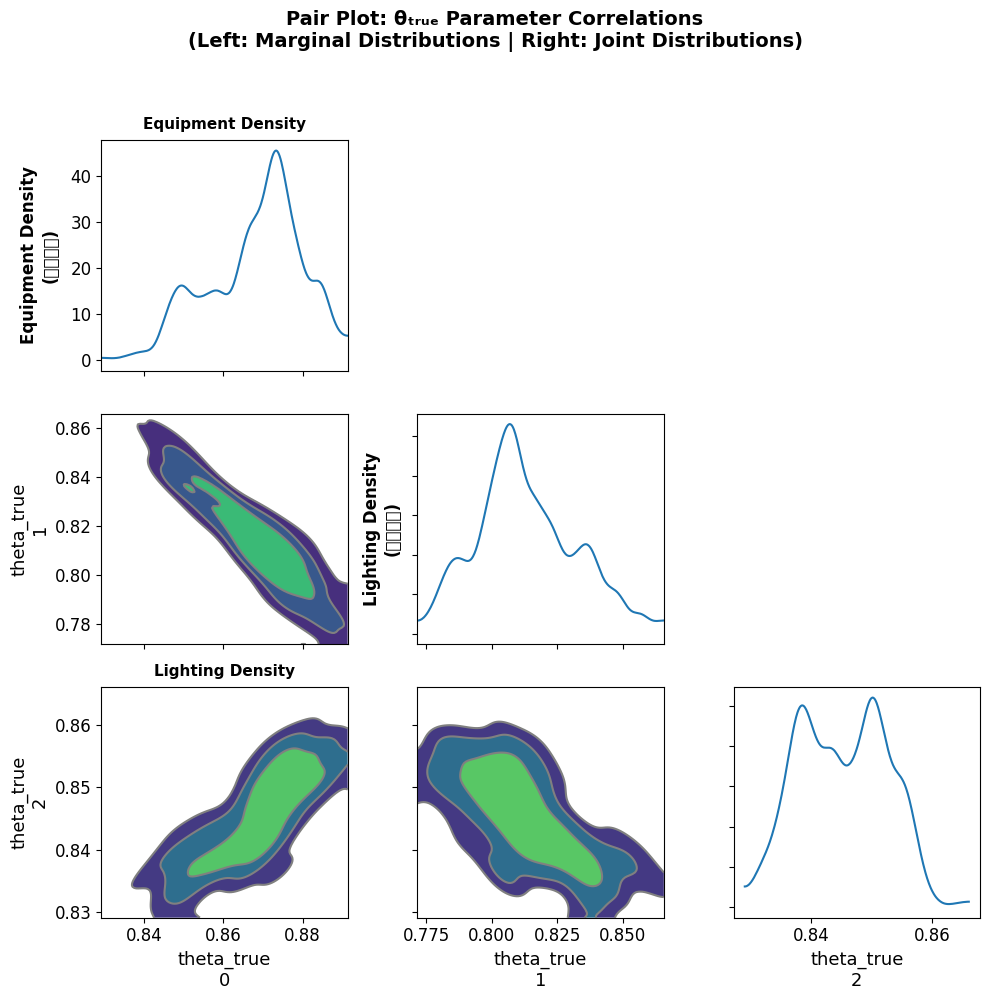

In [90]:
# =============================================================================
# theta_true 파라미터 간의 상관관계 시각화 (Pair Plot)
# =============================================================================
# 목적: 파라미터 간의 상관성과 불확실성 구조를 파악
# 
# Pair plot 구조:
# - 대각선: 각 파라미터의 주변 분포 (marginal distribution)
# - 비대각선: 파라미터 쌍 간의 결합 분포 (joint distribution)
# - 이를 통해 파라미터 간의 상관관계와 다변량 불확실성 구조 파악

# 각 파라미터의 실제 의미를 레이블로 표시
theta_labels = [
    "Equipment Density\n(기기밀도)",
    "Lighting Density\n(조명밀도)",
    "COP\n(Coefficient of Performance)"
]

# 한글 폰트 사용 등 그래프 스타일 조정 (필요시 주석 해제)
# plt.rc('font', family='NanumGothic')

# Pair plot 생성 (KDE contours 사용)
# ⚠️ 주의: arviz의 plot_pair는 반환값이 버전에 따라 다를 수 있음
pair_result = az.plot_pair(
    trace,
    var_names=["theta_true"],
    kind='kde',
    marginals=True,
    gridsize=100,
    figsize=(10, 10),
    textsize=12
)

# 반환값 처리: figure 객체 추출
# arviz는 일반적으로 figure를 반환하거나 tuple로 반환
if isinstance(pair_result, tuple):
    pair_fig = pair_result[0] if len(pair_result) > 0 else plt.gcf()
else:
    pair_fig = pair_result if hasattr(pair_result, 'suptitle') else plt.gcf()

# axes 추출 (안전한 방법)
try:
    # 최신 arviz: figure.axes 속성 사용
    if hasattr(pair_fig, 'axes'):
        axes_list = pair_fig.axes
    # 대안: get_axes() 메서드 사용
    elif hasattr(pair_fig, 'get_axes'):
        axes_list = pair_fig.get_axes()
    else:
        # fallback: 현재 figure의 axes 사용
        axes_list = plt.gcf().get_axes()
except:
    axes_list = plt.gcf().get_axes()

# axes를 numpy 배열로 변환
axes_array = np.array(axes_list)

# 3x3 격자에 맞게 axes 재배열
# arviz는 row-major 순서로 subplot을 생성 (0행0열, 0행1열, ..., 2행2열)
if len(axes_array) == 9:
    axes = axes_array.reshape((3, 3))
elif len(axes_array) >= 9:
    # 9개 이상인 경우 처음 9개만 사용
    axes = axes_array[:9].reshape((3, 3))
else:
    # 9개 미만인 경우 경고 출력 (대각선만 있는 경우 등)
    print(f"Warning: Expected 9 axes, but got {len(axes_array)}. Attempting to reshape...")
    n = int(np.sqrt(len(axes_array)))
    axes = axes_array[:n*n].reshape((n, n))

# 축 레이블 설정
for i in range(min(3, axes.shape[0])):
    # x축 레이블 (하단 행)
    if axes.shape[0] > 2:
        axes[2, i].set_xlabel(theta_labels[i], fontsize=12, fontweight='bold', labelpad=8)
    # y축 레이블 (왼쪽 열)
    axes[i, 0].set_ylabel(theta_labels[i], fontsize=12, fontweight='bold', labelpad=8)
    # 대각선 플롯 제목 (선택사항, 이미 label이 있으면 중복될 수 있음)
    if i < len(theta_labels):
        axes[i, i].set_title(theta_labels[i].split('\n')[0], fontsize=11, fontweight='bold', pad=8)

# 전체 제목 설정
pair_fig.suptitle(
    "Pair Plot: θₜᵣᵤₑ Parameter Correlations\n"
    "(Left: Marginal Distributions | Right: Joint Distributions)", 
    fontsize=14, y=0.995, fontweight="bold"
)

plt.tight_layout(rect=(0, 0, 1, 0.96))
plt.show()

## 원래 차원으로 복원하여 함수 파라미터 시각화

### 역변환의 필요성

MCMC 샘플링을 통해 얻은 `theta_true` 파라미터들은 **정규화된 [0, 1] 범위**에 있습니다. 하지만 실제 물리적 해석과 비교를 위해서는 **원래의 물리적 단위**로 복원해야 합니다.

### 역변환 과정

#### **1. 정규화 파라미터 복원**
```python
trace_ = trace.copy()
trace_.posterior.theta_true.values *= theta_max[None, None, :]
```

**수학적 표현**:
$$\theta_{true,\text{original}} = \theta_{true,\text{normalized}} \times \theta_{\text{max}}$$

여기서:
- $\theta_{true,\text{normalized}}$: MCMC로 샘플링된 정규화된 파라미터 [0, 1]
- $\theta_{\text{max}}$: 정규화 시 사용된 최댓값 벡터
- $\theta_{true,\text{original}}$: 원래 물리적 단위의 파라미터

#### **2. 차원 구조 설명**
```python
theta_max[None, None, :]
```

이 표현의 차원 구조:
- `theta_max`: (3,) - 3개 파라미터의 최댓값
- `[None, None, :]`: (1, 1, 3) - 브로드캐스팅을 위한 차원 확장
- `trace.posterior.theta_true`: (1, 1000, 3) - (chain, draw, parameter)
- 결과: (1, 1000, 3) - 모든 샘플에 대해 역변환 적용


theta_true 파라미터 역변환 완료
정규화된 범위 [0, 1] → 물리적 단위로 변환
역변환에 사용된 최댓값 (theta_max): [9.34 7.65 3.45]

이제 파라미터를 물리적 단위로 해석 가능:
  - theta_true[0]: 기기밀도 (Equipment Density, 단위: W/m²)
  - theta_true[1]: 조명밀도 (Lighting Density, 단위: W/m²)
  - theta_true[2]: COP (Coefficient of Performance, 무차원)


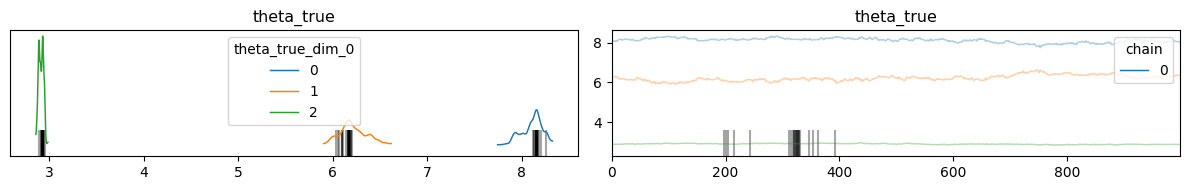

In [91]:

# =============================================================================
# theta_true 파라미터를 원래 물리적 단위로 역변환
# =============================================================================
# 목적: 정규화된 [0, 1] 범위의 파라미터를 원래 물리적 단위로 복원하여 해석 가능하게 만들기
#
# 역변환 공식: theta_true_original = theta_true_normalized × theta_max
#
# 차원 구조:
# - theta_max: (3,) - 3개 파라미터의 최댓값 [theta1_max, theta2_max, theta3_max]
# - theta_max[None, None, :]: (1, 1, 3) - 브로드캐스팅을 위한 차원 확장
# - trace.posterior.theta_true: (chain=1, draw=1000, parameter=3)
# - 결과: 모든 샘플에 대해 역변환이 적용됨

# Trace 복사 (원본 trace는 보존)
trace_ = trace.copy()

# 역변환 수행: 정규화된 파라미터에 최댓값을 곱하여 물리적 단위로 복원
# theta_max는 위 Cell 15에서 정규화 시 사용된 최댓값 벡터
trace_.posterior.theta_true.values *= theta_max[None, None, :]

print("=" * 80)
print("theta_true 파라미터 역변환 완료")
print("=" * 80)
print("정규화된 범위 [0, 1] → 물리적 단위로 변환")
print(f"역변환에 사용된 최댓값 (theta_max): {theta_max}")
print("\n이제 파라미터를 물리적 단위로 해석 가능:")
print("  - theta_true[0]: 기기밀도 (Equipment Density, 단위: W/m²)")
print("  - theta_true[1]: 조명밀도 (Lighting Density, 단위: W/m²)")
print("  - theta_true[2]: COP (Coefficient of Performance, 무차원)")
print("=" * 80)

# 역변환된 theta_true 값들의 사후 분포 시각화
# 물리적 단위로 해석 가능한 값들
az.plot_trace(trace_, legend=True, var_names=["theta_true"])
plt.tight_layout()
plt.show()

In [92]:
# =============================================================================
# 사후 예측 샘플링 (Posterior Predictive Sampling)
# =============================================================================
# 목적: 학습된 모델을 사용하여 새로운 데이터를 예측하고 모델 검증 수행
#
# 사후 예측 분포란?
# - 주어진 데이터를 조건으로 한 새로운 관측값의 예측 분포
# - 파라미터의 불확실성까지 포함한 예측 (단순 평균값이 아닌 확률 분포)
#
# 추출 변수:
# - y_obs: 시뮬레이션 데이터에 대한 사후 예측 (모델 적합도 검증용)
# - z_obs: 실제 관측 데이터에 대한 사후 예측 (모델 예측력 평가용)

with koh_model:
    samples = pm.sample_posterior_predictive(
        trace,                      # MCMC 샘플링 결과
        var_names=["y_obs", "z_obs"],  # 추출할 관측 변수들
    )

Sampling: [y_obs, z_obs]


Output()

In [93]:
# =============================================================================
# 사후 예측 분포의 평균값 확인: 시뮬레이션 데이터
# =============================================================================
# 목적: 모델이 시뮬레이션 데이터를 얼마나 잘 예측하는지 확인
# 
# 해석: 사후 예측 분포의 평균값은 관측값과 비교하여 모델 적합도를 평가하는 데 사용

# 사후 예측 샘플의 평균 계산 (chain과 draw 차원에 대해 평균)
# shape: (chain, draw, n_obs) → (n_obs,)
y_pred_mean_check = samples.posterior_predictive.y_obs.mean(axis=(0, 1))

print("=" * 80)
print("Posterior Predictive Mean for Simulation Data")
print("=" * 80)
print(f"Shape: {y_pred_mean_check.shape}")
print(f"First 5 values: {y_pred_mean_check[:5]}")
print(f"Mean of predictions: {y_pred_mean_check.mean():.6f}")
print(f"Mean of observed (y): {y.mean():.6f}")
print(f"Difference: {abs(y_pred_mean_check.mean() - y.mean()):.6f}")
print("=" * 80)

y_pred_mean_check

Posterior Predictive Mean for Simulation Data
Shape: (240,)
First 5 values: <xarray.DataArray 'y_obs' (y_obs_dim_0: 5)> Size: 40B
array([ 9.23042342e-02,  2.83051089e-02,  6.90666727e-03,  6.82029345e-03,
       -2.02390692e-05])
Coordinates:
  * y_obs_dim_0  (y_obs_dim_0) int64 40B 0 1 2 3 4
Mean of predictions: 0.307844
Mean of observed (y): 0.307845
Difference: 0.000001


<xarray.DataArray 'y_obs' (y_obs_dim_0: 240)> Size: 2kB
array([ 9.23042342e-02,  2.83051089e-02,  6.90666727e-03,  6.82029345e-03,
       -2.02390692e-05,  1.00133964e-02,  5.97441502e-02,  1.31950944e-01,
        8.73222617e-02,  2.54819755e-02,  2.27020381e-02,  7.90832088e-02,
        1.18622098e-01,  1.79057647e-01,  2.77057121e-01,  4.34891831e-01,
        7.02665133e-01,  8.03739023e-01,  8.26100036e-01,  7.45506175e-01,
        6.59848131e-01,  5.42881043e-01,  3.90411677e-01,  2.52325214e-01,
        9.82381662e-02,  2.86696014e-02,  7.53697022e-03,  7.61017156e-03,
        5.05670858e-04,  1.13030842e-02,  5.91522560e-02,  1.26233549e-01,
        8.27495281e-02,  2.38452512e-02,  2.18817356e-02,  9.16176446e-02,
        1.44045176e-01,  2.18774004e-01,  3.36424910e-01,  5.23509805e-01,
        8.37075546e-01,  9.35231897e-01,  9.47400534e-01,  8.35886582e-01,
        7.19086437e-01,  5.81208420e-01,  4.14407447e-01,  2.67980342e-01,
        1.11335235e-01,  5.25999264e-02,  2.77084537e-02,  2.76980714e-02,
        1.91038057e-02,  3.34937754e-02,  8.17493006e-02,  1.41052218e-01,
        9.55729708e-02,  3.88665811e-02,  4.60587544e-02,  1.09349522e-01,
        1.40294203e-01,  1.97319886e-01,  2.90869557e-01,  4.25917713e-01,
        6.78783194e-01,  7.72119904e-01,  7.91826056e-01,  7.12922803e-01,
        6.29759094e-01,  5.21629077e-01,  3.79376067e-01,  2.54690941e-01,
        1.12420954e-01,  4.86217255e-02,  2.22441871e-02,  2.22626583e-02,
        1.45134173e-02,  2.63347873e-02,  7.90773804e-02,  1.53111399e-01,
...
        8.51249545e-01,  9.52790791e-01,  9.67753579e-01,  8.60329501e-01,
        7.48266967e-01,  6.15189824e-01,  4.48732270e-01,  3.05408452e-01,
        1.37985321e-01,  6.12609339e-02,  2.81292245e-02,  2.80991913e-02,
        2.01874878e-02,  3.21504484e-02,  8.76886377e-02,  1.67074000e-01,
        1.16768771e-01,  4.79513457e-02,  6.15094581e-02,  1.40847874e-01,
        1.79167001e-01,  2.48197211e-01,  3.60162597e-01,  5.40533764e-01,
        8.53981107e-01,  9.71778305e-01,  9.96918827e-01,  9.00995760e-01,
        7.99255231e-01,  6.62431644e-01,  4.84419354e-01,  3.23992252e-01,
        1.08370607e-01,  4.87694618e-02,  2.45506887e-02,  2.45705154e-02,
        1.63337774e-02,  2.98138525e-02,  7.87337669e-02,  1.41324872e-01,
        9.56541010e-02,  3.74188228e-02,  4.24711967e-02,  1.03835135e-01,
        1.34698772e-01,  1.90828863e-01,  2.83060909e-01,  4.19105426e-01,
        6.70045199e-01,  7.65622267e-01,  7.87160215e-01,  7.11612565e-01,
        6.31599310e-01,  5.23976475e-01,  3.80969055e-01,  2.54375702e-01,
        1.78481496e-01,  1.04456586e-01,  5.87149041e-02,  5.77734007e-02,
        4.80042583e-02,  6.35612377e-02,  1.24278979e-01,  2.04870198e-01,
        1.48789383e-01,  7.95373733e-02,  1.26374211e-01,  1.84772959e-01,
        2.12429556e-01,  2.74824588e-01,  3.79298143e-01,  5.38825213e-01,
        8.39445562e-01,  9.66524217e-01,  9.99990616e-01,  9.18694445e-01,
        8.31904511e-01,  7.03328178e-01,  5.25174942e-01,  3.64443237e-01])
Coordinates:
  * y_obs_dim_0  (y_obs_dim_0) int64 2kB 0 1 2 3 4 5 ... 234 235 236 237 238 239

In [94]:
# =============================================================================
# 원본 시뮬레이션 데이터 확인
# =============================================================================
# 목적: 사후 예측과 비교할 원본 관측값 확인
# 
# y: 정규화된 시뮬레이션 데이터 (Cell 15에서 정의)

print("=" * 80)
print("Original Simulation Data (y)")
print("=" * 80)
print(f"Shape: {y.shape}")
print(f"First 5 values: {y[:5]}")
print(f"Mean: {y.mean():.6f}")
print(f"Std:  {y.std():.6f}")
print(f"Min:  {y.min():.6f}")
print(f"Max:  {y.max():.6f}")
print("=" * 80)

y

Original Simulation Data (y)
Shape: (240,)
First 5 values: [0.0922735  0.02836461 0.00684527 0.00684527 0.        ]
Mean: 0.307845
Std:  0.302041
Min:  0.000000
Max:  1.000000


array([9.22734962e-02, 2.83646092e-02, 6.84527322e-03, 6.84527322e-03,
       0.00000000e+00, 1.00712066e-02, 5.96994374e-02, 1.32007553e-01,
       8.73559149e-02, 2.54730713e-02, 2.27585664e-02, 7.90550376e-02,
       1.18592392e-01, 1.79058972e-01, 2.77076203e-01, 4.34910893e-01,
       7.02663362e-01, 8.03768834e-01, 8.26094654e-01, 7.45564342e-01,
       6.59860734e-01, 5.42861639e-01, 3.90416617e-01, 2.52389945e-01,
       9.83319564e-02, 2.86006531e-02, 7.57307526e-03, 7.57307526e-03,
       5.11428459e-04, 1.12907667e-02, 5.91683386e-02, 1.26263818e-01,
       8.27137181e-02, 2.38601046e-02, 2.18930721e-02, 9.15850348e-02,
       1.44026122e-01, 2.18734018e-01, 3.36421574e-01, 5.23506039e-01,
       8.37090365e-01, 9.35245289e-01, 9.47401550e-01, 8.35910146e-01,
       7.19107754e-01, 5.81238444e-01, 4.14414414e-01, 2.67949172e-01,
       1.11314371e-01, 5.25591093e-02, 2.77154884e-02, 2.77154884e-02,
       1.91392266e-02, 3.34788937e-02, 8.17498721e-02, 1.41036233e-01,
      

In [95]:
# =============================================================================
# 사후 예측 분포의 평균값 확인: 실제 관측 데이터
# =============================================================================
# 목적: 모델이 실제 관측 데이터를 얼마나 잘 예측하는지 확인
# 
# 해석: 사후 예측 분포의 평균값은 관측값과 비교하여 모델 예측력을 평가하는 데 사용

# 사후 예측 샘플의 평균 계산 (chain과 draw 차원에 대해 평균)
# shape: (chain, draw, n_obs) → (n_obs,)
z_pred_mean_check = samples.posterior_predictive.z_obs.mean(axis=(0, 1))

print("=" * 80)
print("Posterior Predictive Mean for Observed Data")
print("=" * 80)
print(f"Shape: {z_pred_mean_check.shape}")
print(f"First 5 values: {z_pred_mean_check[:5]}")
print(f"Mean of predictions: {z_pred_mean_check.mean():.6f}")
print(f"Mean of observed (z): {z.mean():.6f}")
print(f"Difference: {abs(z_pred_mean_check.mean() - z.mean()):.6f}")
print("=" * 80)

z_pred_mean_check

Posterior Predictive Mean for Observed Data
Shape: (24,)
First 5 values: <xarray.DataArray 'z_obs' (z_obs_dim_0: 5)> Size: 40B
array([0.12176186, 0.05481188, 0.02611395, 0.02623041, 0.01817708])
Coordinates:
  * z_obs_dim_0  (z_obs_dim_0) int64 40B 0 1 2 3 4
Mean of predictions: 0.305589
Mean of observed (z): 0.305616
Difference: 0.000027


<xarray.DataArray 'z_obs' (z_obs_dim_0: 24)> Size: 192B
array([0.12176186, 0.05481188, 0.02611395, 0.02623041, 0.01817708,
       0.03078654, 0.08281621, 0.15193949, 0.10434188, 0.04209179,
       0.0508    , 0.12122481, 0.15616728, 0.21912373, 0.3216293 ,
       0.47982047, 0.76171658, 0.86640392, 0.88872482, 0.80125133,
       0.70841511, 0.58655477, 0.42755954, 0.28566901])
Coordinates:
  * z_obs_dim_0  (z_obs_dim_0) int64 192B 0 1 2 3 4 5 6 ... 17 18 19 20 21 22 23

## 6. 베이지안 추론 및 모델 칼리브레이션 결과 분석

이 섹션에서는 MCMC 샘플링 결과를 바탕으로 종합적인 베이지안 추론 및 모델 칼리브레이션 분석을 수행합니다.

### 주요 분석 항목

1. **수렴성 진단**: MCMC 샘플러가 올바르게 수렴했는지 확인
2. **칼리브레이션 파라미터 분석**: $\boldsymbol{\theta}_{true}$의 사후 분포 및 불확실성 정량화
3. **Gaussian Process 하이퍼파라미터 분석**: eta GP와 delta GP의 특성 파악
4. **노이즈 파라미터 분석**: 모델 불확실성 구조 이해
5. **사후 예측 검사**: 모델이 데이터를 잘 설명하는지 검증
6. **모델 불일치 분석**: delta 함수의 특성 및 상대적 중요도
7. **공간 분포 시각화**: 예측 정확도와 불확실성의 공간적 패턴


### 6-1. 수렴성 진단 (Convergence Diagnostics)

MCMC 샘플링의 수렴성은 신뢰할 수 있는 베이지안 추론의 전제조건입니다. 

#### 주요 진단 도구

1. **Trace Plot**: 파라미터 값이 시간에 따라 안정적으로 변동하는지 시각적 확인
2. **Rank Plot**: 샘플이 rank 공간에서 균등하게 분포되어 있는지 확인
3. **R-hat ($\hat{R}$)**: 여러 체인 간 일치도 측정 (1.01 이하 권장, 단일 체인에서는 계산 불가)
4. **ESS (Effective Sample Size)**: 독립적인 샘플 수 (400 이상 권장)
5. **Energy Plot**: NUTS 샘플러의 에너지 분포 확인
6. **Autocorrelation Plot**: 샘플 간 상관관계 확인

여러 진단 도구를 종합하여 샘플러가 목표 분포에서 충분히 잘 샘플링하고 있는지 확인합니다.


In [96]:
# =============================================================================
# 수렴성 진단 및 사후 분포 요약 통계
# =============================================================================
# 목적: MCMC 샘플링의 수렴성을 진단하고 파라미터의 사후 분포 요약
#
# 주요 통계량:
# - mean: 사후 분포의 평균
# - sd: 사후 분포의 표준편차
# - hdi_3%, hdi_97%: Highest Density Interval (HDI)의 하한/상한 (기본 94%)
# - mcse_mean, mcse_sd: Monte Carlo Standard Error (샘플링 오차)
# - ess_bulk, ess_tail: Effective Sample Size (독립적인 샘플 수)
# - r_hat: Gelman-Rubin 통계량 (체인 간 수렴성, 1.01 이하 권장)
#
# ⚠️ 주의: 
# - 현재 단일 체인(chains=1) 사용 중이므로 R-hat는 계산되지 않음
# - ESS는 계산되지만 단일 체인의 한계로 해석에 주의 필요
# - 실전에서는 4개 이상의 체인을 사용하여 수렴성을 정확히 진단해야 함

summary = az.summary(
    trace, 
    var_names=["theta_true", "ls_eta", "ls_delta", "eta_eta", "eta_delta", "sigma_c", "sigma"]
)

print("=" * 80)
print("수렴성 진단 및 사후 분포 요약 통계")
print("=" * 80)
print("\n주요 파라미터 통계:")
print(summary)
print("\n해석 가이드:")
print("  - mean ± sd: 파라미터의 평균값과 불확실성")
print("  - hdi_3%, hdi_97%: 94% 신뢰구간 (Highest Density Interval)")
print("  - ess_bulk: 유효 샘플 수 (클수록 좋음, 최소 400 이상 권장)")
print("  - r_hat: 수렴성 지표 (1.01 이하 권장, 단일 체인에서는 NaN)")
print("=" * 80)


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


수렴성 진단 및 사후 분포 요약 통계

주요 파라미터 통계:
                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta_true[0]  0.868  0.012   0.845    0.886      0.009    0.002       2.0   
theta_true[1]  0.813  0.019   0.781    0.850      0.014    0.003       2.0   
theta_true[2]  0.845  0.007   0.834    0.858      0.006    0.001       2.0   
ls_eta[0]      0.059  0.000   0.059    0.060      0.000    0.000       9.0   
ls_eta[1]      0.290  0.011   0.272    0.308      0.008    0.002       2.0   
ls_eta[2]      3.839  0.604   2.959    4.723      0.561    0.086       1.0   
ls_eta[3]      4.066  0.118   3.873    4.285      0.062    0.010       4.0   
ls_eta[4]      1.673  0.048   1.585    1.752      0.035    0.006       2.0   
ls_delta[0]    3.525  2.646   0.276    8.404      0.390    0.213      33.0   
ls_delta[1]    4.759  2.827   0.501    9.647      0.508    0.307      29.0   
eta_eta        0.834  0.028   0.793    0.876      0.026    0.002       2.0   
eta_delta      0.023  0.027   

#### Rank Plots

Rank plot은 각 파라미터의 샘플이 균등하게 분포되어 있는지 확인합니다. 이상적인 경우 각 rank bin에 비슷한 수의 샘플이 있어야 합니다.


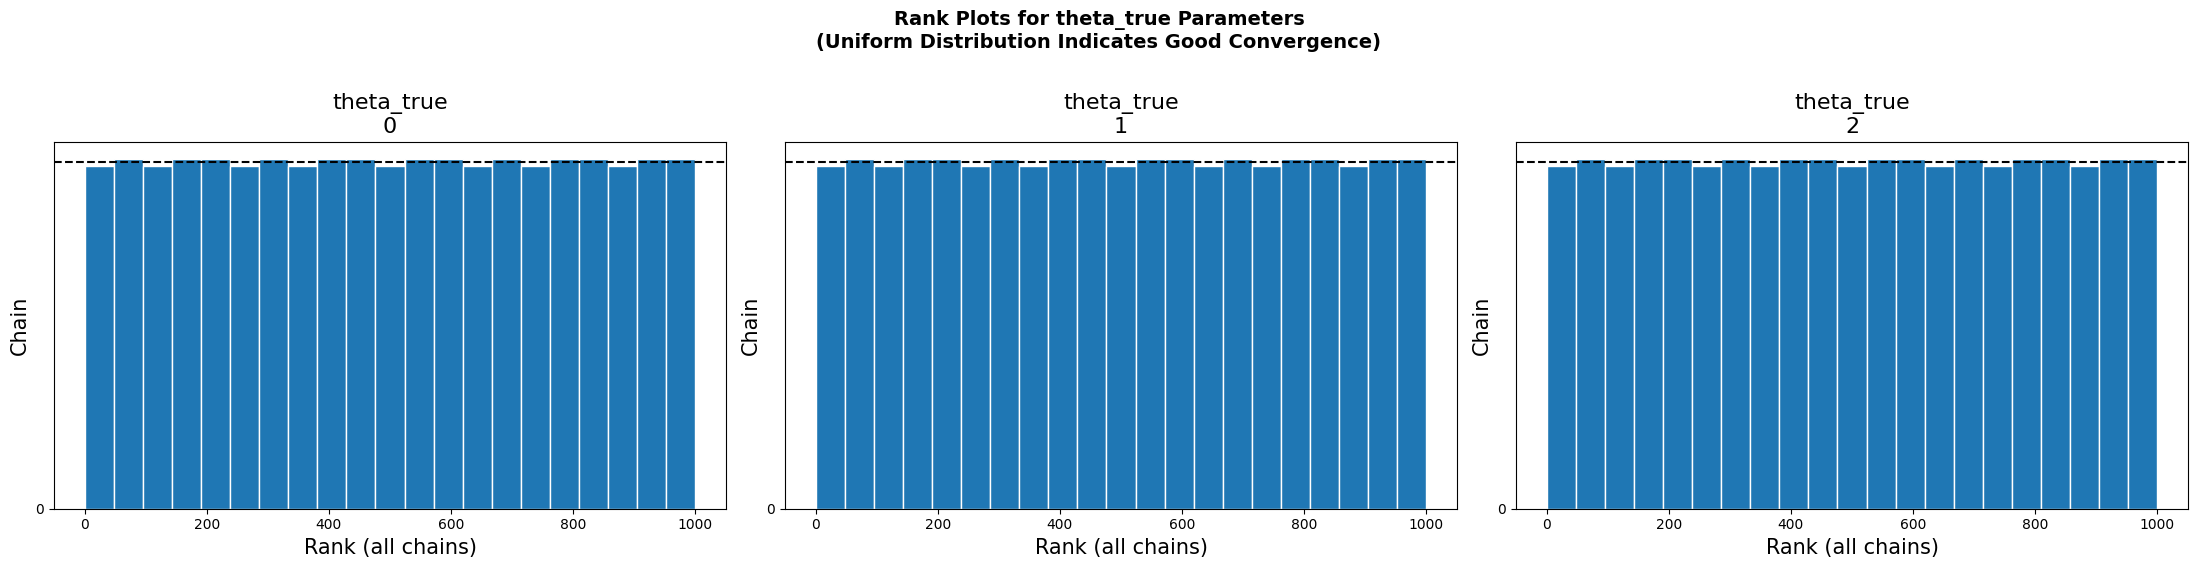

In [97]:
# =============================================================================
# Rank Plot: theta_true 파라미터
# =============================================================================
# 목적: 각 파라미터의 샘플이 균등하게 분포되어 있는지 확인
#
# 해석:
# - Rank plot은 각 파라미터의 샘플들을 정렬(rank)하여 분포를 시각화
# - 이상적인 경우 각 rank bin에 비슷한 수의 샘플이 있어야 함 (균등 분포)
# - 특정 rank bin에 샘플이 집중되면 수렴 문제 가능성

az.plot_rank(trace, var_names=["theta_true"], ref_line=True)
plt.suptitle("Rank Plots for theta_true Parameters\n" +
             "(Uniform Distribution Indicates Good Convergence)", 
             y=1.02, fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


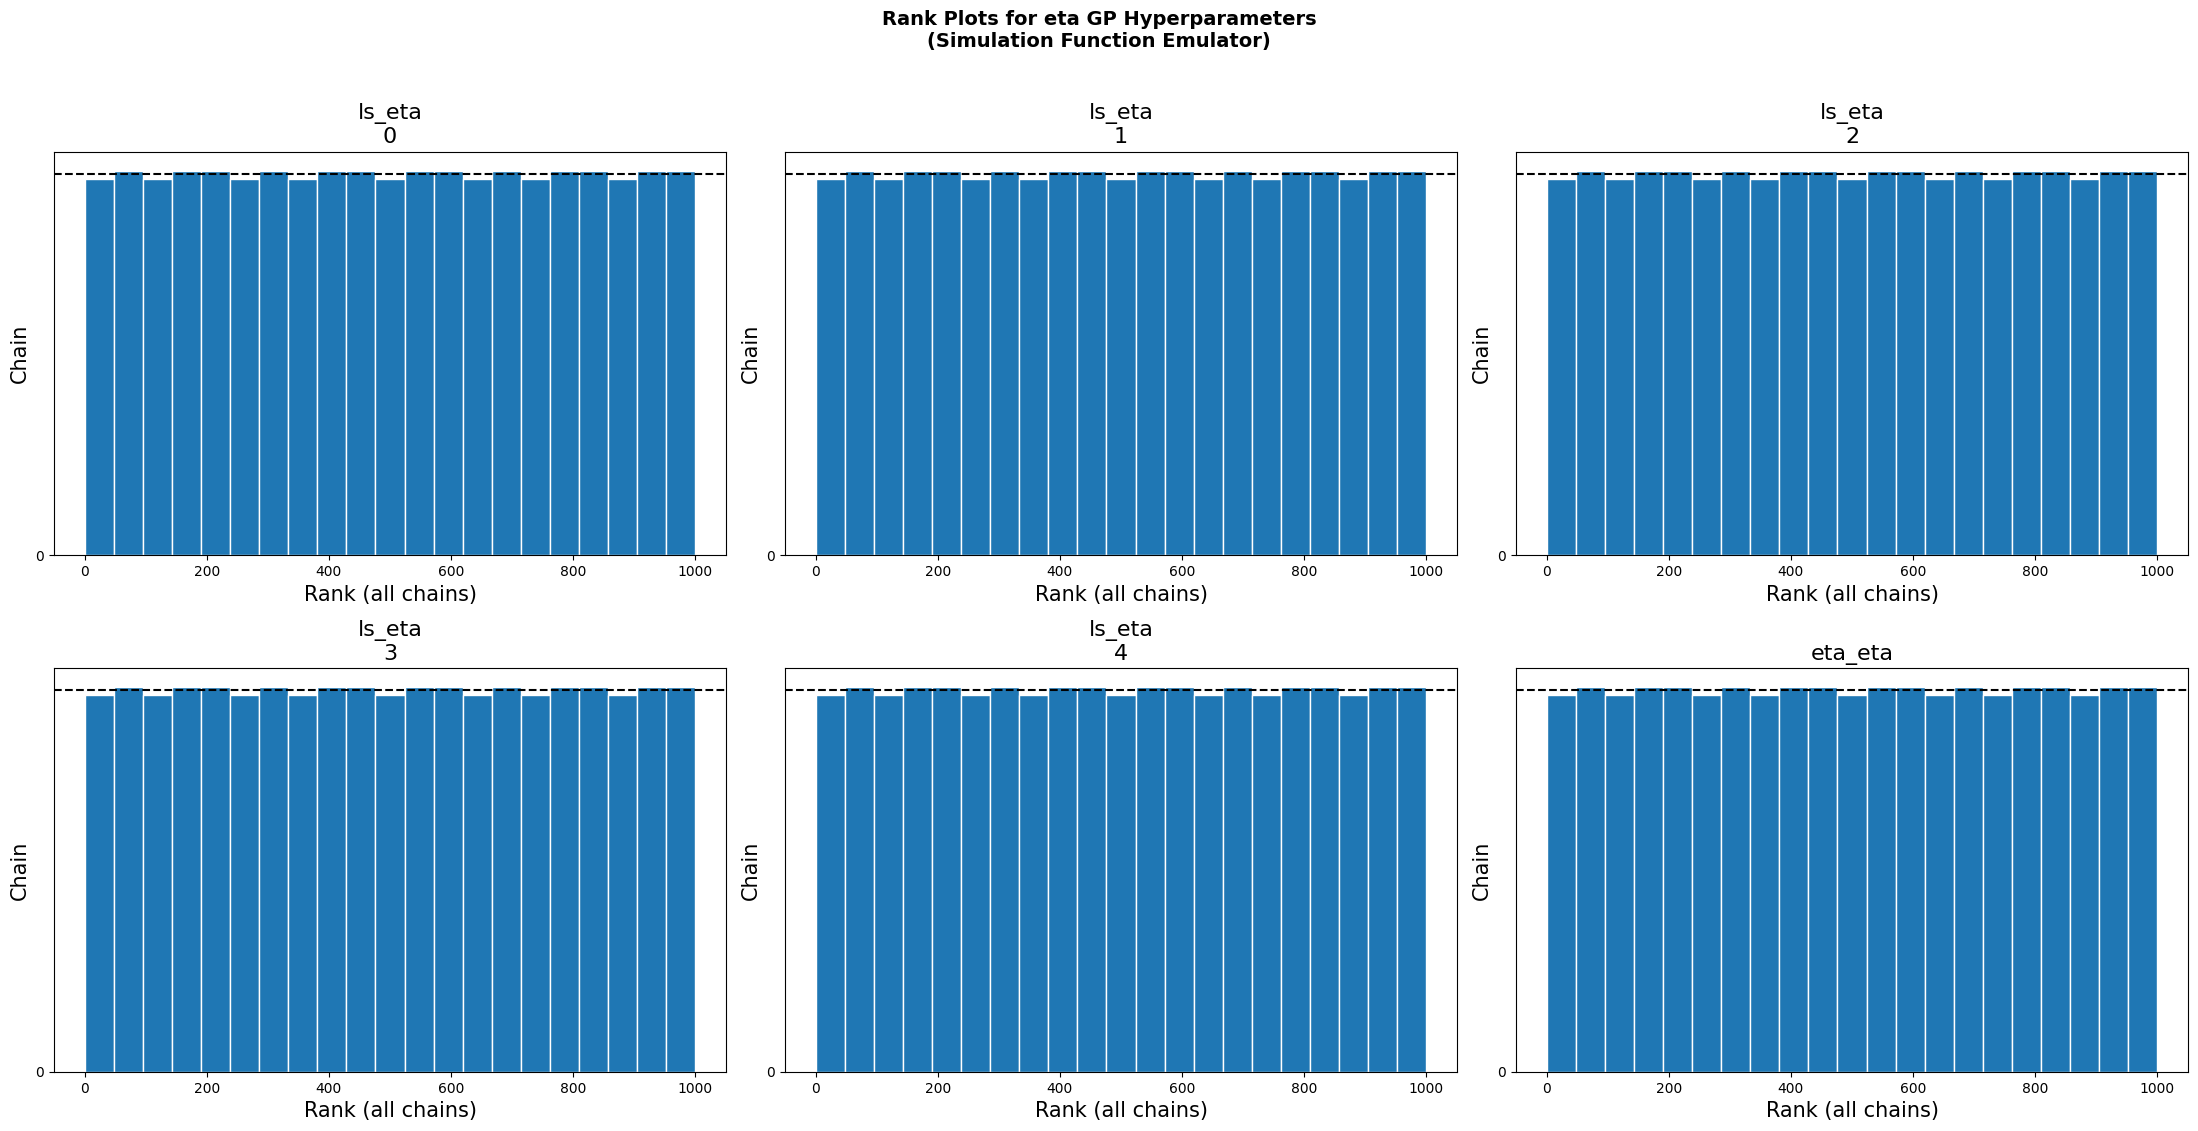

In [98]:
# =============================================================================
# Rank Plot: eta GP 하이퍼파라미터
# =============================================================================
# 목적: eta GP의 하이퍼파라미터(ls_eta, eta_eta) 샘플 분포 확인

az.plot_rank(trace, var_names=["ls_eta", "eta_eta"], ref_line=True)
plt.suptitle("Rank Plots for eta GP Hyperparameters\n" +
             "(Simulation Function Emulator)", 
             y=1.02, fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


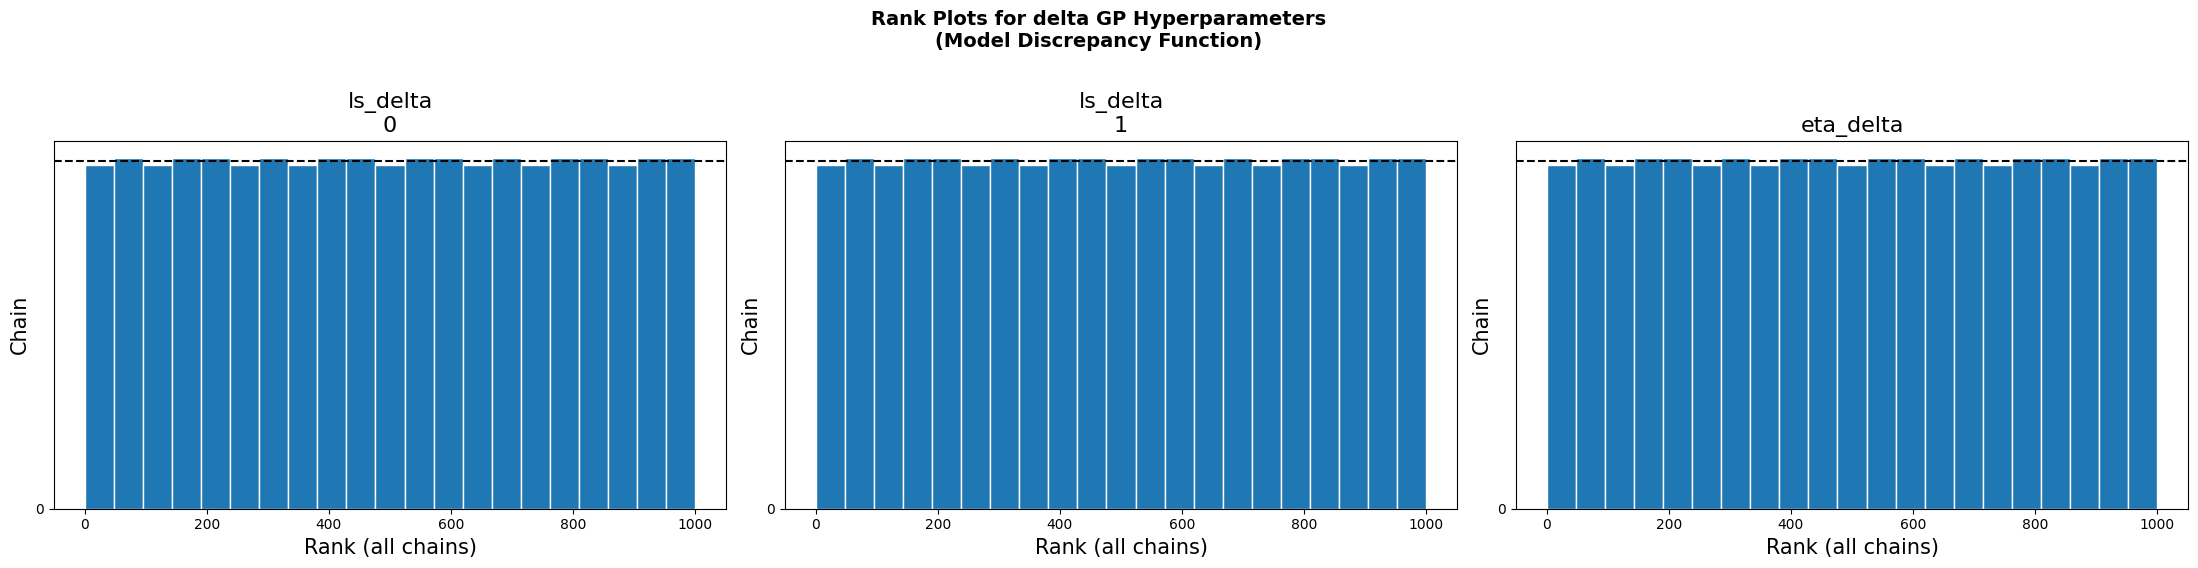

In [99]:
# =============================================================================
# Rank Plot: delta GP 하이퍼파라미터
# =============================================================================
# 목적: delta GP의 하이퍼파라미터(ls_delta, eta_delta) 샘플 분포 확인

az.plot_rank(trace, var_names=["ls_delta", "eta_delta"], ref_line=True)
plt.suptitle("Rank Plots for delta GP Hyperparameters\n" +
             "(Model Discrepancy Function)", 
             y=1.02, fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


### 6-2. 칼리브레이션 파라미터 분석

$\boldsymbol{\theta}_{true}$는 모델 칼리브레이션의 핵심입니다. 이 섹션에서는 물리적 단위로 변환된 값의 사후 분포를 상세히 분석합니다.

#### 분석 내용

1. **Forest Plot**: 파라미터 간 비교 및 94% HDI 시각화
2. **Pair Plot**: 파라미터 간 결합 분포 및 상관관계
3. **상관관계 행렬**: 파라미터 간 상관계수 정량화
4. **불확실성 정량화**: 다양한 신뢰수준에서의 HDI 계산
5. **상대적 불확실성**: Coefficient of Variation (CV) 비교


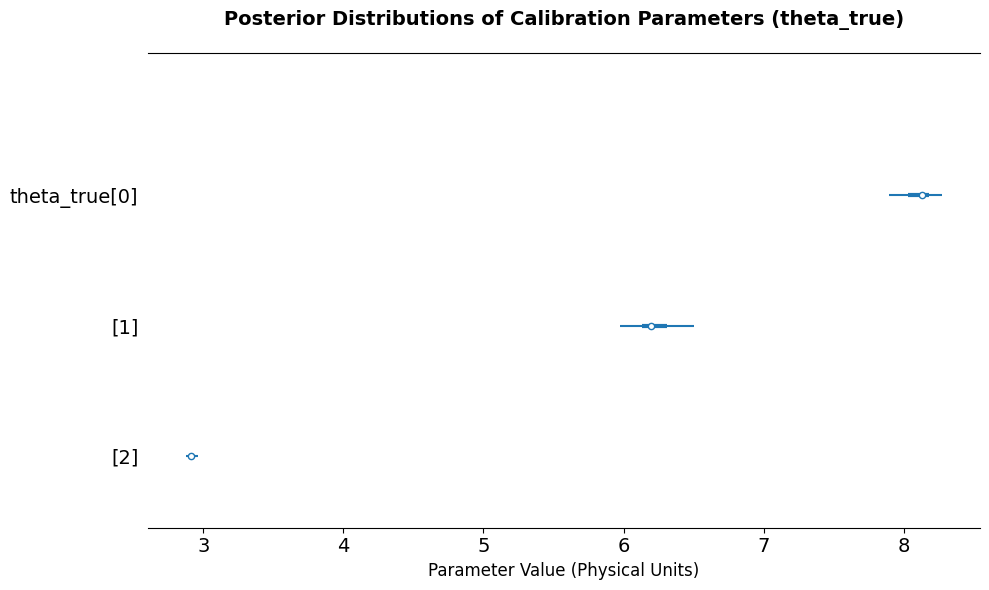

In [100]:
# =============================================================================
# 칼리브레이션 파라미터 사후 분포 시각화 (Forest Plot)
# =============================================================================
# 목적: 물리적 단위로 변환된 theta_true 파라미터의 사후 분포를 한눈에 비교
#
# Forest Plot 해석:
# - 각 선은 파라미터의 94% HDI (Highest Density Interval)
# - 점은 사후 분포의 평균값
# - 파라미터 간의 크기와 불확실성을 쉽게 비교 가능

# ⚠️ 중요: trace_는 Cell 25에서 물리적 단위로 변환된 trace
#          trace_가 정의되지 않았다면 Cell 25를 먼저 실행해야 함

az.plot_forest(trace_, var_names=["theta_true"], combined=True, 
               r_hat=False, figsize=(10, 6))
plt.xlabel("Parameter Value (Physical Units)", fontsize=12)
plt.title("Posterior Distributions of Calibration Parameters (theta_true)", 
         fontsize=14, pad=20, fontweight="bold")
plt.tight_layout()
plt.show()


In [101]:
# =============================================================================
# 칼리브레이션 파라미터 상세 통계
# =============================================================================
# 목적: 물리적 단위로 변환된 theta_true 파라미터의 통계 요약
#
# 94% HDI (Highest Density Interval): 
# - 94%의 확률로 파라미터가 포함될 수 있는 가장 좁은 구간
# - Bayesian 신뢰구간의 한 형태

# ⚠️ 중요: trace_는 Cell 25에서 물리적 단위로 변환된 trace

theta_true_stats = az.summary(
    trace_, 
    var_names=["theta_true"], 
    kind="stats", 
    hdi_prob=0.94
)

print("=" * 80)
print("Calibration Parameters (theta_true) Statistics (Physical Units)")
print("=" * 80)
print("\n통계 요약:")
print(theta_true_stats)
print("\n파라미터 의미:")
print("  - theta_true[0]: Equipment Density (기기밀도, 단위: W/m²)")
print("  - theta_true[1]: Lighting Density (조명밀도, 단위: W/m²)")
print("  - theta_true[2]: COP (Coefficient of Performance, 무차원)")
print("\n해석:")
print("  - Mean: 파라미터의 평균 추정값")
print("  - Std: 파라미터의 불확실성 (표준편차)")
print("  - hdi_3%, hdi_97%: 94% 신뢰구간")
print("=" * 80)


Calibration Parameters (theta_true) Statistics (Physical Units)

통계 요약:
                mean     sd  hdi_3%  hdi_97%
theta_true[0]  8.109  0.109   7.893    8.274
theta_true[1]  6.222  0.144   5.974    6.500
theta_true[2]  2.916  0.025   2.877    2.960

파라미터 의미:
  - theta_true[0]: Equipment Density (기기밀도, 단위: W/m²)
  - theta_true[1]: Lighting Density (조명밀도, 단위: W/m²)
  - theta_true[2]: COP (Coefficient of Performance, 무차원)

해석:
  - Mean: 파라미터의 평균 추정값
  - Std: 파라미터의 불확실성 (표준편차)
  - hdi_3%, hdi_97%: 94% 신뢰구간


#### 칼리브레이션 파라미터의 결합 분포 분석

파라미터 간의 상관관계와 불확실성 구조를 이해하는 것이 중요합니다.


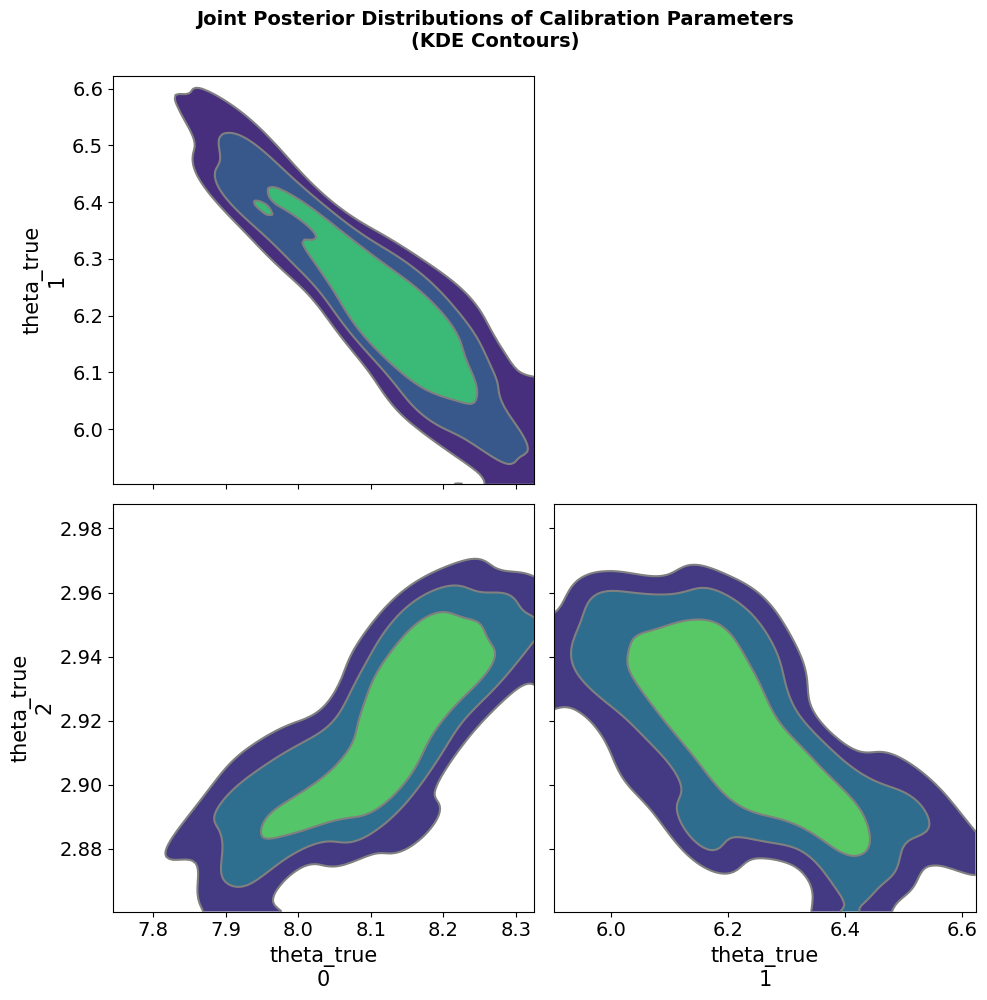

In [102]:
# =============================================================================
# Pair Plot with KDE: 칼리브레이션 파라미터 결합 분포
# =============================================================================
# 목적: 파라미터 간의 결합 분포와 상관관계를 KDE(커널 밀도 추정)로 시각화
#
# 해석:
# - 대각선: 각 파라미터의 주변 분포 (marginal distribution)
# - 비대각선: 파라미터 쌍 간의 결합 분포 (joint distribution)
# - 등고선이 타원형이면 정규 분포에 가깝고, 기울어지면 상관관계가 있음

# ⚠️ 중요: trace_는 Cell 25에서 물리적 단위로 변환된 trace

az.plot_pair(trace_, var_names=["theta_true"], kind="kde", 
             divergences=False, figsize=(10, 10))
plt.suptitle("Joint Posterior Distributions of Calibration Parameters\n" +
             "(KDE Contours)", 
             fontsize=14, y=0.995, fontweight="bold")
plt.tight_layout()
plt.show()


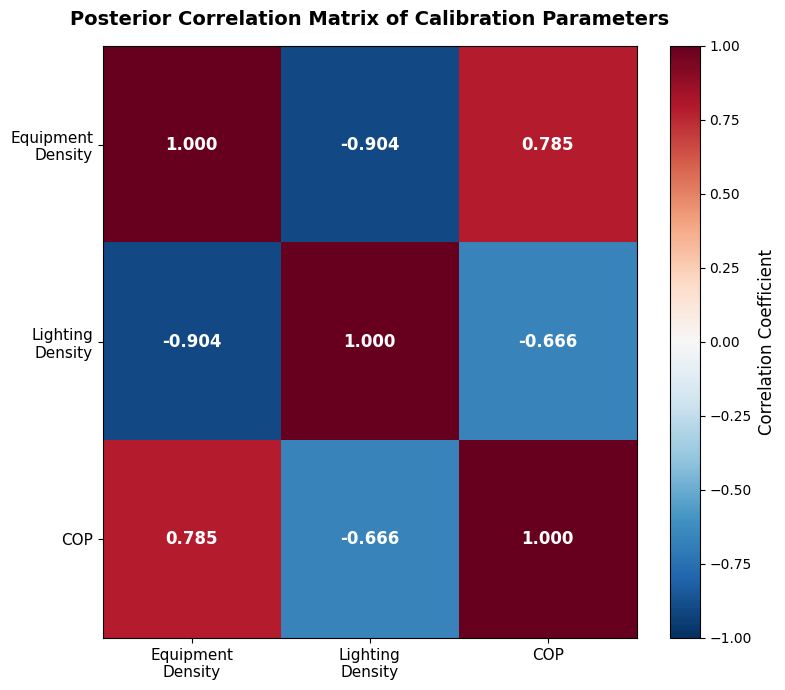

Correlation Matrix Summary
파라미터 간 상관계수:
  Equipment Density vs Lighting Density: -0.904
  Equipment Density vs COP: 0.785
  Lighting Density vs COP: -0.666


In [103]:
# =============================================================================
# 상관관계 행렬 시각화
# =============================================================================
# 목적: theta_true 파라미터 간의 피어슨 상관계수를 행렬로 시각화
#
# 해석:
# - 1에 가까우면 양의 상관관계 (한 파라미터가 증가하면 다른 파라미터도 증가)
# - -1에 가까우면 음의 상관관계 (한 파라미터가 증가하면 다른 파라미터는 감소)
# - 0에 가까우면 상관관계가 거의 없음 (독립적)

# ⚠️ 중요: trace_는 Cell 25에서 물리적 단위로 변환된 trace

# 사후 샘플에서 상관계수 계산
theta_samples = az.extract(trace_, var_names=["theta_true"]).values.T  # (n_samples, 3)
corr_matrix = np.corrcoef(theta_samples.T)  # (3, 3) - 피어슨 상관계수 행렬

# 상관관계 행렬 시각화
fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(corr_matrix, cmap="RdBu_r", vmin=-1, vmax=1, aspect="auto")

# 축 레이블 설정
labels = ["Equipment\nDensity", "Lighting\nDensity", "COP"]
ax.set_xticks(range(3))
ax.set_yticks(range(3))
ax.set_xticklabels(labels, fontsize=11)
ax.set_yticklabels(labels, fontsize=11)

# 상관계수 값을 텍스트로 표시
for i in range(3):
    for j in range(3):
        # 대각선은 항상 1이므로 굵게 표시
        text_color = "white" if abs(corr_matrix[i, j]) > 0.5 else "black"
        text = ax.text(j, i, f"{corr_matrix[i, j]:.3f}",
                      ha="center", va="center", color=text_color, 
                      fontweight="bold", fontsize=12)

# 컬러바 추가
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Correlation Coefficient", fontsize=12)
ax.set_title("Posterior Correlation Matrix of Calibration Parameters", 
            fontsize=14, pad=15, fontweight="bold")
plt.tight_layout()
plt.show()

# 상관계수 요약
print("=" * 80)
print("Correlation Matrix Summary")
print("=" * 80)
print("파라미터 간 상관계수:")
for i in range(3):
    for j in range(i+1, 3):
        corr_val = corr_matrix[i, j]
        print(f"  {labels[i].replace(chr(10), ' ')} vs {labels[j].replace(chr(10), ' ')}: {corr_val:.3f}")
print("=" * 80)


### 6-3. Gaussian Process 하이퍼파라미터 분석

GP 하이퍼파라미터들은 함수의 특성을 결정합니다. 

#### 분석 목적

- **Length-scale**: 각 입력 차원에서의 함수 부드러움 정도
  - 작은 값: 높은 민감도 (입력 변화에 대해 급변)
  - 큰 값: 낮은 민감도 (입력 변화에 대해 부드럽게 변화)
  
- **Amplitude**: 함수 값의 전체적인 변동 폭
  - 클수록 함수의 변동성이 큼

eta GP와 delta GP의 하이퍼파라미터를 각각 분석하여 각 함수의 특성과 역할을 파악합니다.


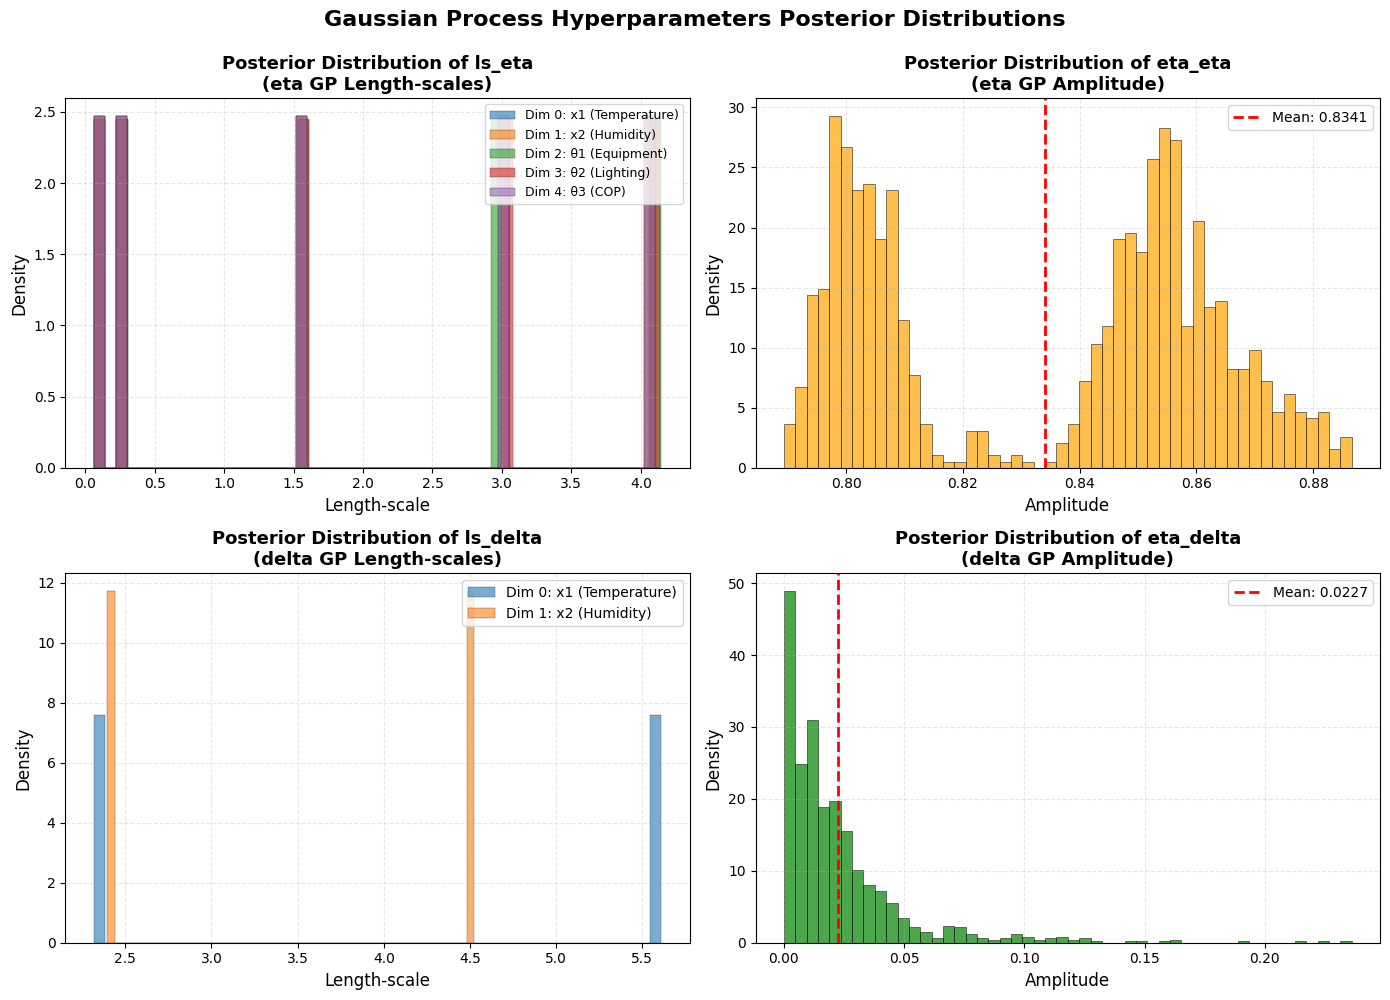

In [104]:
# =============================================================================
# Gaussian Process 하이퍼파라미터 사후 분포 시각화
# =============================================================================
# 목적: eta GP와 delta GP의 하이퍼파라미터 분포를 비교하여 각 GP의 특성 파악
#
# 하이퍼파라미터 설명:
# - Length-scale: 함수의 부드러움 정도 (크면 부드럽게, 작으면 급변함)
# - Amplitude: 함수 값의 전체적인 변동 폭

# 데이터 추출
# ⚠️ 주의: ls_eta_samples는 이미 Cell 46에서 정의되었을 수 있으나,
#          여기서는 명확성을 위해 다시 추출 (다른 변수명 사용)
ls_eta_extracted_plot = az.extract(trace, var_names=["ls_eta"]).values.T  # (5, n_samples)
ls_delta_extracted_plot = az.extract(trace, var_names=["ls_delta"]).values.T  # (2, n_samples)
eta_eta_samples_plot = az.extract(trace, var_names=["eta_eta"]).values
eta_delta_samples_plot = az.extract(trace, var_names=["eta_delta"]).values

# 시각화: 2x2 서브플롯
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# (1) ls_eta (eta GP의 length-scale, 5차원)
dim_labels_eta = ['x1 (Temperature)', 'x2 (Humidity)', 
                  'θ1 (Equipment)', 'θ2 (Lighting)', 'θ3 (COP)']
for i in range(5):
    axes[0].hist(ls_eta_extracted_plot[i], bins=50, alpha=0.6, 
                label=f"Dim {i}: {dim_labels_eta[i]}", density=True,
                edgecolor='black', linewidth=0.3)
axes[0].set_xlabel("Length-scale", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].set_title("Posterior Distribution of ls_eta\n(eta GP Length-scales)", 
                 fontsize=13, fontweight="bold")
axes[0].legend(fontsize=9, loc='upper right')
axes[0].grid(True, alpha=0.3, linestyle='--')

# (2) eta_eta (eta GP의 amplitude)
axes[1].hist(eta_eta_samples_plot, bins=50, alpha=0.7, color="orange",
             edgecolor="black", linewidth=0.5, density=True)
axes[1].axvline(eta_eta_samples_plot.mean(), color="red", linestyle="--", 
                linewidth=2, label=f"Mean: {eta_eta_samples_plot.mean():.4f}")
axes[1].set_xlabel("Amplitude", fontsize=12)
axes[1].set_ylabel("Density", fontsize=12)
axes[1].set_title("Posterior Distribution of eta_eta\n(eta GP Amplitude)", 
                 fontsize=13, fontweight="bold")
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, linestyle='--')

# (3) ls_delta (delta GP의 length-scale, 2차원)
dim_labels_delta = ['x1 (Temperature)', 'x2 (Humidity)']
for i in range(2):
    axes[2].hist(ls_delta_extracted_plot[i], bins=50, alpha=0.6, 
                label=f"Dim {i}: {dim_labels_delta[i]}", density=True,
                edgecolor='black', linewidth=0.3)
axes[2].set_xlabel("Length-scale", fontsize=12)
axes[2].set_ylabel("Density", fontsize=12)
axes[2].set_title("Posterior Distribution of ls_delta\n(delta GP Length-scales)", 
                 fontsize=13, fontweight="bold")
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3, linestyle='--')

# (4) eta_delta (delta GP의 amplitude)
axes[3].hist(eta_delta_samples_plot, bins=50, alpha=0.7, color="green",
             edgecolor="black", linewidth=0.5, density=True)
axes[3].axvline(eta_delta_samples_plot.mean(), color="red", linestyle="--", 
                linewidth=2, label=f"Mean: {eta_delta_samples_plot.mean():.4f}")
axes[3].set_xlabel("Amplitude", fontsize=12)
axes[3].set_ylabel("Density", fontsize=12)
axes[3].set_title("Posterior Distribution of eta_delta\n(delta GP Amplitude)", 
                 fontsize=13, fontweight="bold")
axes[3].legend(fontsize=10)
axes[3].grid(True, alpha=0.3, linestyle='--')

plt.suptitle("Gaussian Process Hyperparameters Posterior Distributions", 
             fontsize=16, y=0.995, fontweight="bold")
plt.tight_layout()
plt.show()


#### Length-scale 해석

Length-scale이 클수록 해당 차원에서 함수가 더 부드럽게 변합니다. 즉, 입력값이 크게 변해도 함수값의 변화가 작다는 의미입니다. 이를 통해 각 입력 변수의 중요성을 파악할 수 있습니다.


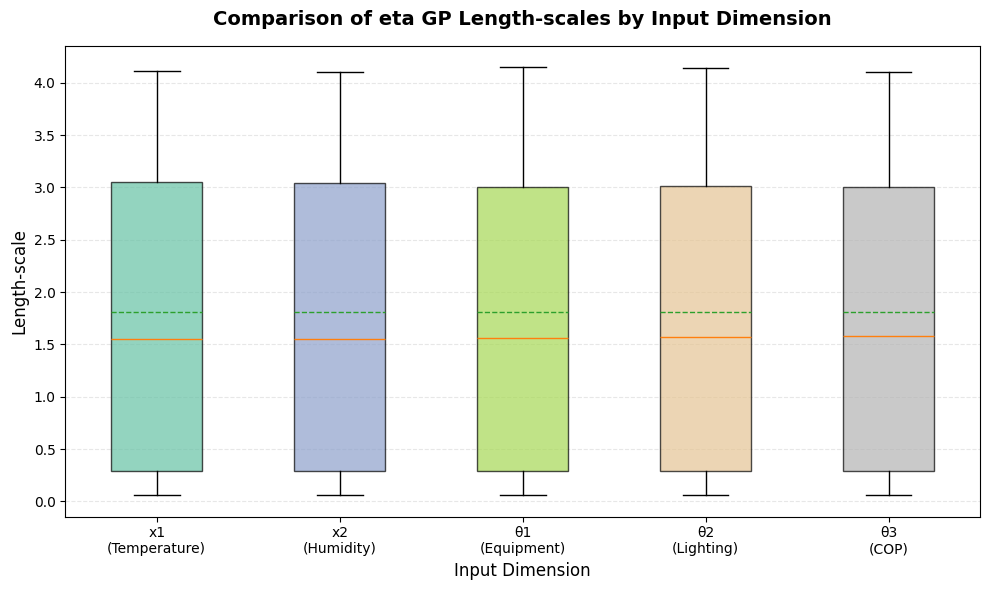

Average Length-scales for eta GP
x1 (Temperature): 1.8123 ± 1.5654
x2 (Humidity): 1.8117 ± 1.5638
θ1 (Equipment): 1.8122 ± 1.5699
θ2 (Lighting): 1.8140 ± 1.5691
θ3 (COP): 1.8069 ± 1.5577


In [105]:
# =============================================================================
# eta GP의 length-scale 비교 (Boxplot)
# =============================================================================
# 목적: 각 입력 차원의 length-scale을 비교하여 상대적 중요도 파악
# 
# 해석:
# - 작은 length-scale: 해당 차원에서 입력 변화에 대한 출력 변화가 큼 (높은 민감도)
# - 큰 length-scale: 해당 차원에서 입력 변화에 대한 출력 변화가 작음 (낮은 민감도)

# ls_eta 데이터 추출 및 준비
# ⚠️ 주의: 이 변수는 Cell 46에서만 사용되므로 여기서 새로 정의
ls_eta_extracted_box = az.extract(trace, var_names=["ls_eta"]).values.T  # (5, n_samples)
ls_eta_samples = ls_eta_extracted_box  # Cell 46에서 사용할 변수명

# 5차원 데이터 준비: [x1, x2, theta1, theta2, theta3]
ls_eta_data = [ls_eta_samples[i] for i in range(5)]
labels = ["x1\n(Temperature)", "x2\n(Humidity)", "θ1\n(Equipment)", 
         "θ2\n(Lighting)", "θ3\n(COP)"]

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))

# 박스플롯 생성
# ⚠️ 수정: matplotlib 3.9+에서는 'labels' 파라미터가 'tick_labels'로 변경됨
try:
    # 최신 버전: tick_labels 사용
    bp = ax.boxplot(ls_eta_data, tick_labels=labels, patch_artist=True, 
                    showmeans=True, meanline=True)
except TypeError:
    # 구 버전: labels 사용 (fallback)
    bp = ax.boxplot(ls_eta_data, labels=labels, patch_artist=True, 
                    showmeans=True, meanline=True)

# 박스플롯 스타일링: 각 박스에 다른 색상 적용
colors = plt.cm.Set2(np.linspace(0, 1, 5))
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# 축 레이블 및 제목 설정
ax.set_ylabel("Length-scale", fontsize=12)
ax.set_xlabel("Input Dimension", fontsize=12)
ax.set_title("Comparison of eta GP Length-scales by Input Dimension", 
             fontsize=14, pad=15, fontweight="bold")
ax.grid(True, alpha=0.3, axis="y", linestyle='--')

plt.tight_layout()
plt.show()

# 평균 및 표준편차 출력
ls_eta_mean = ls_eta_samples.mean(axis=1)
print("=" * 80)
print("Average Length-scales for eta GP")
print("=" * 80)
for i, (label, mean_ls) in enumerate(zip(labels, ls_eta_mean)):
    std_ls = ls_eta_samples[i].std()
    print(f"{label.strip().replace(chr(10), ' ')}: {mean_ls:.4f} ± {std_ls:.4f}")
print("=" * 80)


### 6-4. 노이즈 파라미터 분석

시뮬레이션 노이즈($\sigma_c$)와 관측 노이즈($\sigma$)를 분석하여 모델의 불확실성 구조를 이해합니다.

#### 노이즈 파라미터 의미

- **$\sigma_c$**: 시뮬레이션 데이터의 노이즈 (에뮬레이터 오차)
  - 컴퓨터 시뮬레이션 코드의 출력이 완벽하지 않다는 것을 반영
  
- **$\sigma$**: 실제 관측 데이터의 노이즈 
  - 시뮬레이션 노이즈 + 추가 관측 오차의 합
  - $\sigma = \sigma_c + \sigma_p$ (여기서 $\sigma_p$는 추가 관측 노이즈)

일반적으로 $\sigma > \sigma_c$이며, 이는 실제 관측 과정에 추가적인 불확실성이 존재함을 의미합니다.


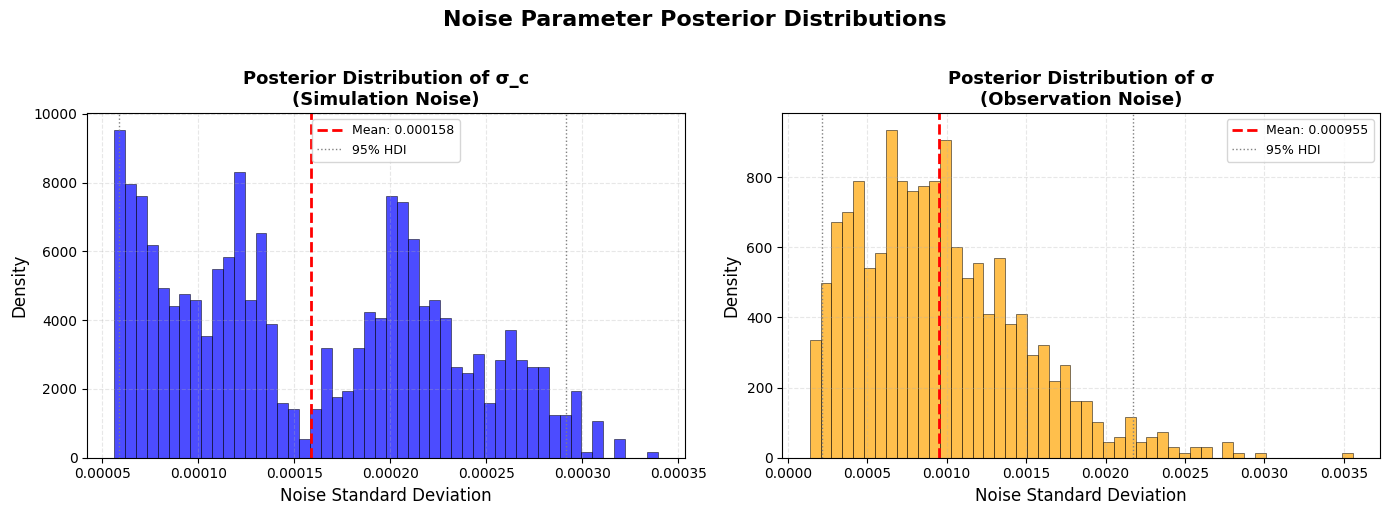

Noise Parameter Statistics
sigma_c (simulation noise):
  Mean: 0.000158
  Std:  0.000071
  95% HDI: [0.000059, 0.000292]

sigma (observation noise):
  Mean: 0.000955
  Std:  0.000521
  95% HDI: [0.000214, 0.002172]

Noise ratio (σ/σ_c): 6.03
  → 관측 노이즈가 시뮬레이션 노이즈보다 약 6.0배 큼


In [106]:
# =============================================================================
# 노이즈 파라미터 분석 및 시각화
# =============================================================================
# 목적: 시뮬레이션 노이즈와 관측 노이즈를 비교하여 모델의 불확실성 구조 파악
#
# 해석:
# - sigma_c: 시뮬레이션 데이터의 노이즈 (에뮬레이터 오차)
# - sigma: 실제 관측 데이터의 노이즈 (시뮬레이션 노이즈 + 추가 관측 오차)
# - sigma는 일반적으로 sigma_c보다 크며, 이는 실제 관측에 추가적인 불확실성이
#   존재함을 의미

# 노이즈 파라미터 추출
sigma_c_samples = az.extract(trace, var_names=["sigma_c"]).values
sigma_samples = az.extract(trace, var_names=["sigma"]).values

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (1) sigma_c (시뮬레이션 노이즈) 사후 분포
axes[0].hist(sigma_c_samples, bins=50, alpha=0.7, color="blue", 
             edgecolor="black", linewidth=0.5, density=True)
axes[0].axvline(sigma_c_samples.mean(), color="red", linestyle="--", 
                linewidth=2, label=f"Mean: {sigma_c_samples.mean():.6f}")
axes[0].axvline(np.percentile(sigma_c_samples, 2.5), color="gray", 
                linestyle=":", linewidth=1, label="95% HDI")
axes[0].axvline(np.percentile(sigma_c_samples, 97.5), color="gray", 
                linestyle=":", linewidth=1)
axes[0].set_xlabel("Noise Standard Deviation", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].set_title("Posterior Distribution of σ_c\n(Simulation Noise)", 
                 fontsize=13, fontweight="bold")
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3, linestyle='--')

# (2) sigma (관측 노이즈) 사후 분포
axes[1].hist(sigma_samples, bins=50, alpha=0.7, color="orange", 
             edgecolor="black", linewidth=0.5, density=True)
axes[1].axvline(sigma_samples.mean(), color="red", linestyle="--", 
                linewidth=2, label=f"Mean: {sigma_samples.mean():.6f}")
axes[1].axvline(np.percentile(sigma_samples, 2.5), color="gray", 
                linestyle=":", linewidth=1, label="95% HDI")
axes[1].axvline(np.percentile(sigma_samples, 97.5), color="gray", 
                linestyle=":", linewidth=1)
axes[1].set_xlabel("Noise Standard Deviation", fontsize=12)
axes[1].set_ylabel("Density", fontsize=12)
axes[1].set_title("Posterior Distribution of σ\n(Observation Noise)", 
                 fontsize=13, fontweight="bold")
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.suptitle("Noise Parameter Posterior Distributions", 
             fontsize=16, y=1.02, fontweight="bold")
plt.tight_layout()
plt.show()

# 노이즈 통계 출력
print("=" * 80)
print("Noise Parameter Statistics")
print("=" * 80)
print(f"sigma_c (simulation noise):")
print(f"  Mean: {sigma_c_samples.mean():.6f}")
print(f"  Std:  {sigma_c_samples.std():.6f}")
print(f"  95% HDI: [{np.percentile(sigma_c_samples, 2.5):.6f}, "
      f"{np.percentile(sigma_c_samples, 97.5):.6f}]")
print(f"\nsigma (observation noise):")
print(f"  Mean: {sigma_samples.mean():.6f}")
print(f"  Std:  {sigma_samples.std():.6f}")
print(f"  95% HDI: [{np.percentile(sigma_samples, 2.5):.6f}, "
      f"{np.percentile(sigma_samples, 97.5):.6f}]")
if sigma_c_samples.mean() > 0:
    ratio = sigma_samples.mean() / sigma_c_samples.mean()
    print(f"\nNoise ratio (σ/σ_c): {ratio:.2f}")
    print(f"  → 관측 노이즈가 시뮬레이션 노이즈보다 약 {ratio:.1f}배 큼")
print("=" * 80)


### 6-5. 사후 예측 검사 (Posterior Predictive Checks)

사후 예측 검사(Posterior Predictive Check)는 모델이 데이터를 잘 설명하는지 확인하는 중요한 검증 단계입니다.

#### 검사 방법

1. **예측값 vs 관측값 비교**: 일치선(y=x)에 가까울수록 좋음
2. **잔차 분석**: 0 주변에 패턴 없이 랜덤하게 분포해야 함
3. **분포 비교**: 사후 예측 분포와 관측 데이터 분포가 유사해야 함
4. **신뢰구간 커버리지**: 95% CI에 약 95%의 관측값이 포함되어야 함

시뮬레이션 데이터와 실제 관측 데이터 각각에 대해 검사를 수행하여 모델 적합도와 예측력을 평가합니다.


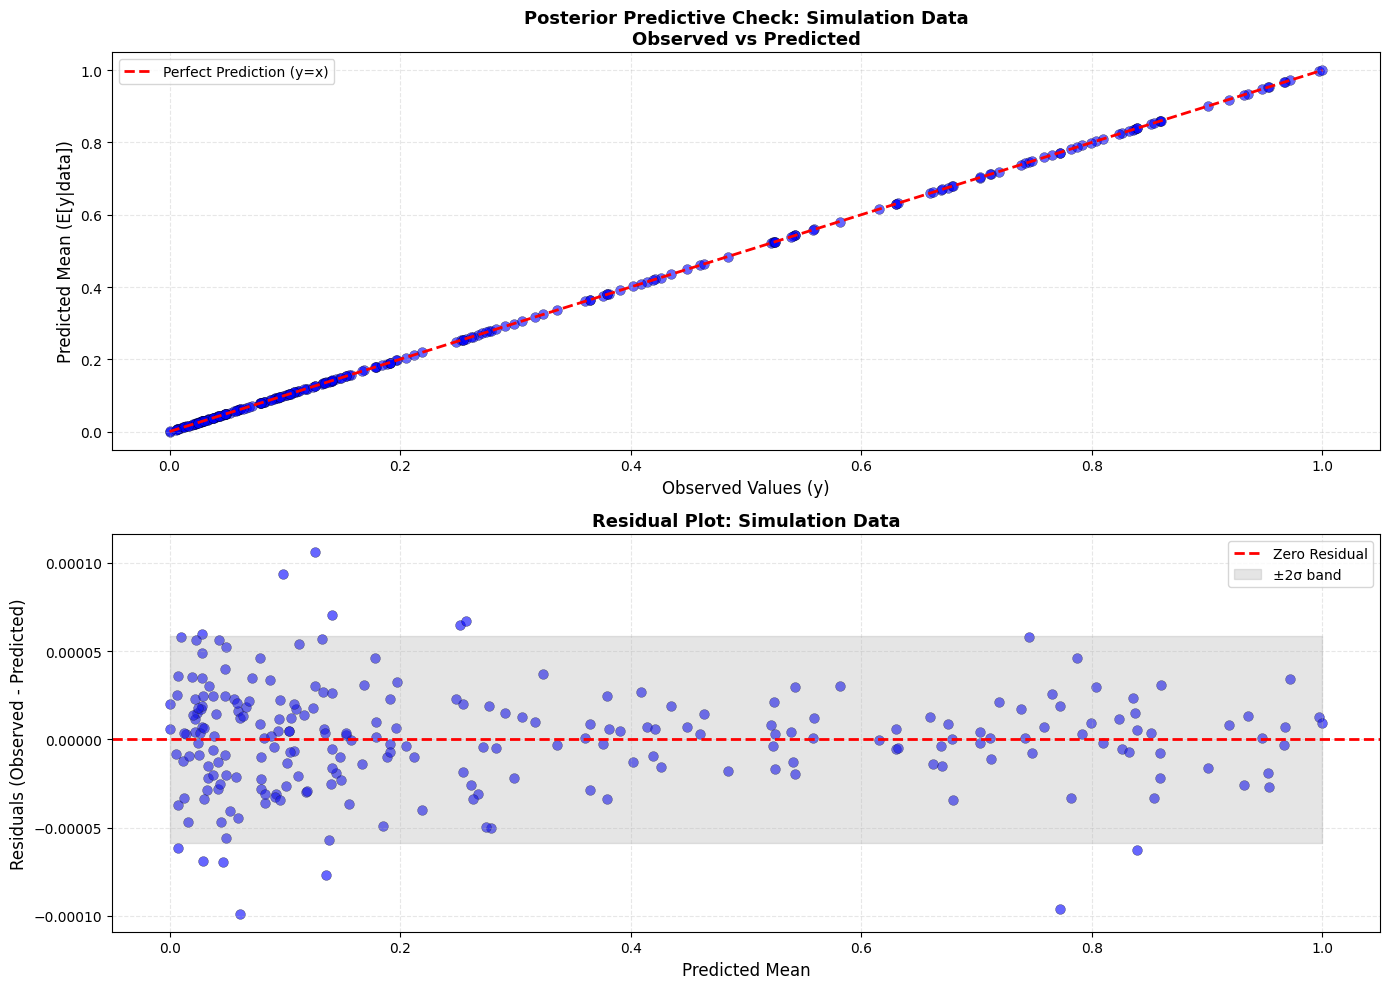

Simulation Data Posterior Predictive Check
RMSE (Root Mean Squared Error): 0.000029
MAE (Mean Absolute Error):  0.000022
R² (Coefficient of Determination): 1.000000

해석:
  ✓ 모델이 시뮬레이션 데이터를 매우 잘 설명함 (R² > 0.99)


In [107]:
# =============================================================================
# 사후 예측 검사: 시뮬레이션 데이터
# =============================================================================
# 목적: 모델이 시뮬레이션 데이터를 잘 설명하는지 확인 (모델 적합도 검증)
#
# 평가 지표:
# - 예측값 vs 관측값: 일치선(y=x)에 가까울수록 좋음
# - 잔차 플롯: 0 주변에 랜덤하게 분포해야 함 (패턴이 없어야 함)
# - RMSE, MAE, R²: 작은 RMSE/MAE와 큰 R²가 이상적

# 사후 예측 샘플 추출
# y_obs: 시뮬레이션 데이터의 관측값
# samples.posterior_predictive.y_obs: 사후 예측 샘플 (chain, draw, n_obs)
y_obs_samples = samples.posterior_predictive.y_obs.values

# 사후 예측 분포의 평균과 HDI 계산
y_pred_mean = y_obs_samples.mean(axis=(0, 1))
y_pred_lower = np.percentile(y_obs_samples, 2.5, axis=(0, 1))
y_pred_upper = np.percentile(y_obs_samples, 97.5, axis=(0, 1))

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# (1) 상단: 예측값 vs 관측값 (산점도)
axes[0].scatter(y, y_pred_mean, alpha=0.6, s=50, color="blue", 
                edgecolors='black', linewidths=0.3)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], "r--", 
             linewidth=2, label="Perfect Prediction (y=x)")
axes[0].set_xlabel("Observed Values (y)", fontsize=12)
axes[0].set_ylabel("Predicted Mean (E[y|data])", fontsize=12)
axes[0].set_title("Posterior Predictive Check: Simulation Data\n" +
                  "Observed vs Predicted", fontsize=13, fontweight="bold")
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, linestyle='--')

# (2) 하단: 잔차 플롯 (Residual Plot)
residuals = y - y_pred_mean
axes[1].scatter(y_pred_mean, residuals, alpha=0.6, s=50, color="blue",
                edgecolors='black', linewidths=0.3)
axes[1].axhline(y=0, color="red", linestyle="--", linewidth=2, label="Zero Residual")
axes[1].fill_between([y_pred_mean.min(), y_pred_mean.max()], 
                     2*np.std(residuals), -2*np.std(residuals), 
                     alpha=0.2, color="gray", label="±2σ band")
axes[1].set_xlabel("Predicted Mean", fontsize=12)
axes[1].set_ylabel("Residuals (Observed - Predicted)", fontsize=12)
axes[1].set_title("Residual Plot: Simulation Data", 
                 fontsize=13, fontweight="bold")
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# 통계 요약
print("=" * 80)
print("Simulation Data Posterior Predictive Check")
print("=" * 80)
rmse = np.sqrt(np.mean(residuals**2))
mae = np.mean(np.abs(residuals))
r_squared = 1 - np.sum(residuals**2) / np.sum((y - y.mean())**2)
print(f"RMSE (Root Mean Squared Error): {rmse:.6f}")
print(f"MAE (Mean Absolute Error):  {mae:.6f}")
print(f"R² (Coefficient of Determination): {r_squared:.6f}")
print(f"\n해석:")
if r_squared > 0.99:
    print("  ✓ 모델이 시뮬레이션 데이터를 매우 잘 설명함 (R² > 0.99)")
else:
    print("  ⚠ 모델 적합도가 낮을 수 있음 (R² < 0.99)")
print("=" * 80)


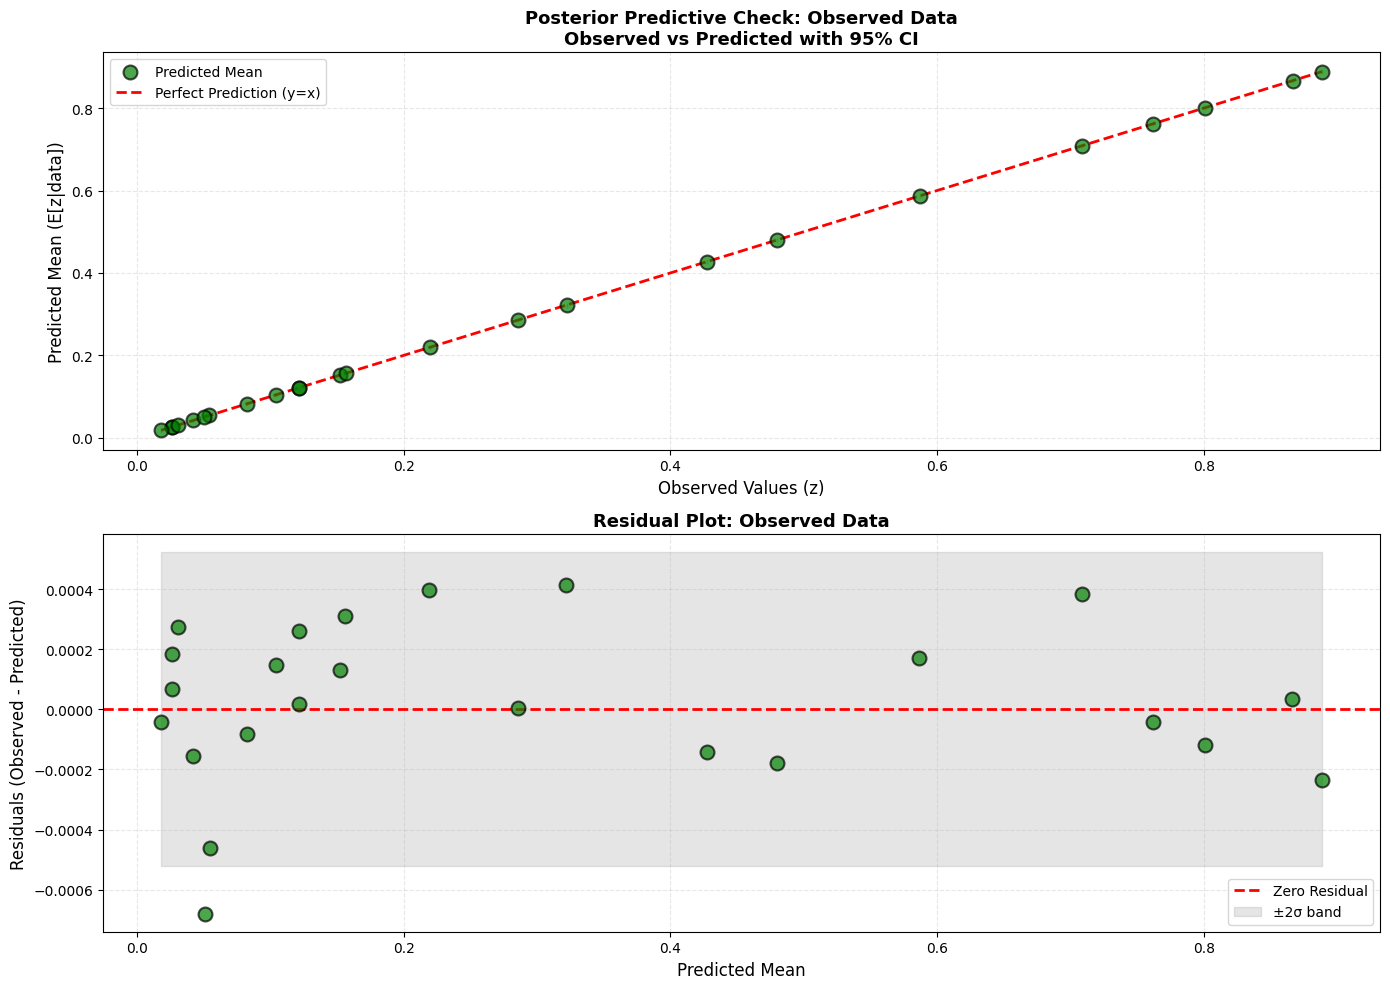

Observed Data Posterior Predictive Check
RMSE (Root Mean Squared Error): 0.000263
MAE (Mean Absolute Error):      0.000206
R² (Coefficient of Determination): 0.999999

95% CI Coverage: 100.0%
  → 예측 신뢰구간에 100.0%의 관측값이 포함됨

해석:
  ✓ 신뢰구간 커버리지가 적절함 (90-100%)


In [108]:
# =============================================================================
# 사후 예측 검사: 실제 관측 데이터
# =============================================================================
# 목적: 모델이 실제 관측 데이터를 잘 예측하는지 확인 (모델 예측력 평가)
#
# 평가 지표:
# - 예측값 vs 관측값: 일치선(y=x)에 가까울수록 좋음
# - 95% 신뢰구간 커버리지: 약 95%가 이상적
# - 잔차 분석: 패턴 없이 0 주변에 랜덤하게 분포

# 사후 예측 샘플 추출
# z_obs: 실제 관측 데이터
# samples.posterior_predictive.z_obs: 사후 예측 샘플 (chain, draw, n_obs)
z_obs_samples = samples.posterior_predictive.z_obs.values

# 사후 예측 분포의 평균과 HDI 계산
z_pred_mean = z_obs_samples.mean(axis=(0, 1))
z_pred_lower = np.percentile(z_obs_samples, 2.5, axis=(0, 1))
z_pred_upper = np.percentile(z_obs_samples, 97.5, axis=(0, 1))

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# (1) 상단: 예측값 vs 관측값 (산점도 + 95% 신뢰구간)
axes[0].scatter(z, z_pred_mean, alpha=0.7, s=100, color="green", 
                edgecolors="black", linewidths=1.5, zorder=3,
                label="Predicted Mean")
# 95% 신뢰구간 표시 (수직선)
for i in range(len(z)):
    axes[0].plot([z[i], z[i]], [z_pred_lower[i], z_pred_upper[i]], 
                 "g-", alpha=0.3, linewidth=1, zorder=1)
axes[0].plot([z.min(), z.max()], [z.min(), z.max()], "r--", 
             linewidth=2, label="Perfect Prediction (y=x)", zorder=2)
axes[0].set_xlabel("Observed Values (z)", fontsize=12)
axes[0].set_ylabel("Predicted Mean (E[z|data])", fontsize=12)
axes[0].set_title("Posterior Predictive Check: Observed Data\n" +
                  "Observed vs Predicted with 95% CI", 
                 fontsize=13, fontweight="bold")
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, linestyle='--')

# (2) 하단: 잔차 플롯
z_residuals = z - z_pred_mean
axes[1].scatter(z_pred_mean, z_residuals, alpha=0.7, s=100, color="green", 
                edgecolors="black", linewidths=1.5, zorder=3)
axes[1].axhline(y=0, color="red", linestyle="--", linewidth=2, 
                label="Zero Residual", zorder=2)
axes[1].fill_between([z_pred_mean.min(), z_pred_mean.max()], 
                     2*np.std(z_residuals), -2*np.std(z_residuals), 
                     alpha=0.2, color="gray", label="±2σ band", zorder=1)
axes[1].set_xlabel("Predicted Mean", fontsize=12)
axes[1].set_ylabel("Residuals (Observed - Predicted)", fontsize=12)
axes[1].set_title("Residual Plot: Observed Data", 
                 fontsize=13, fontweight="bold")
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# 통계 요약
print("=" * 80)
print("Observed Data Posterior Predictive Check")
print("=" * 80)
z_rmse = np.sqrt(np.mean(z_residuals**2))
z_mae = np.mean(np.abs(z_residuals))
z_r_squared = 1 - np.sum(z_residuals**2) / np.sum((z - z.mean())**2)
coverage = np.sum((z >= z_pred_lower) & (z <= z_pred_upper)) / len(z) * 100

print(f"RMSE (Root Mean Squared Error): {z_rmse:.6f}")
print(f"MAE (Mean Absolute Error):      {z_mae:.6f}")
print(f"R² (Coefficient of Determination): {z_r_squared:.6f}")
print(f"\n95% CI Coverage: {coverage:.1f}%")
print(f"  → 예측 신뢰구간에 {coverage:.1f}%의 관측값이 포함됨")
print(f"\n해석:")
if coverage >= 90 and coverage <= 100:
    print("  ✓ 신뢰구간 커버리지가 적절함 (90-100%)")
elif coverage < 90:
    print("  ⚠ 신뢰구간이 너무 좁음 (관측값이 신뢰구간 밖에 많음)")
else:
    print("  ⚠ 신뢰구간이 너무 넓음 (예측 불확실성이 과대평가됨)")
print("=" * 80)


#### 사후 예측 분포의 히스토그램 비교

관측 데이터와 사후 예측 샘플의 분포를 비교하여 모델이 데이터 분포를 잘 포착하는지 확인합니다.


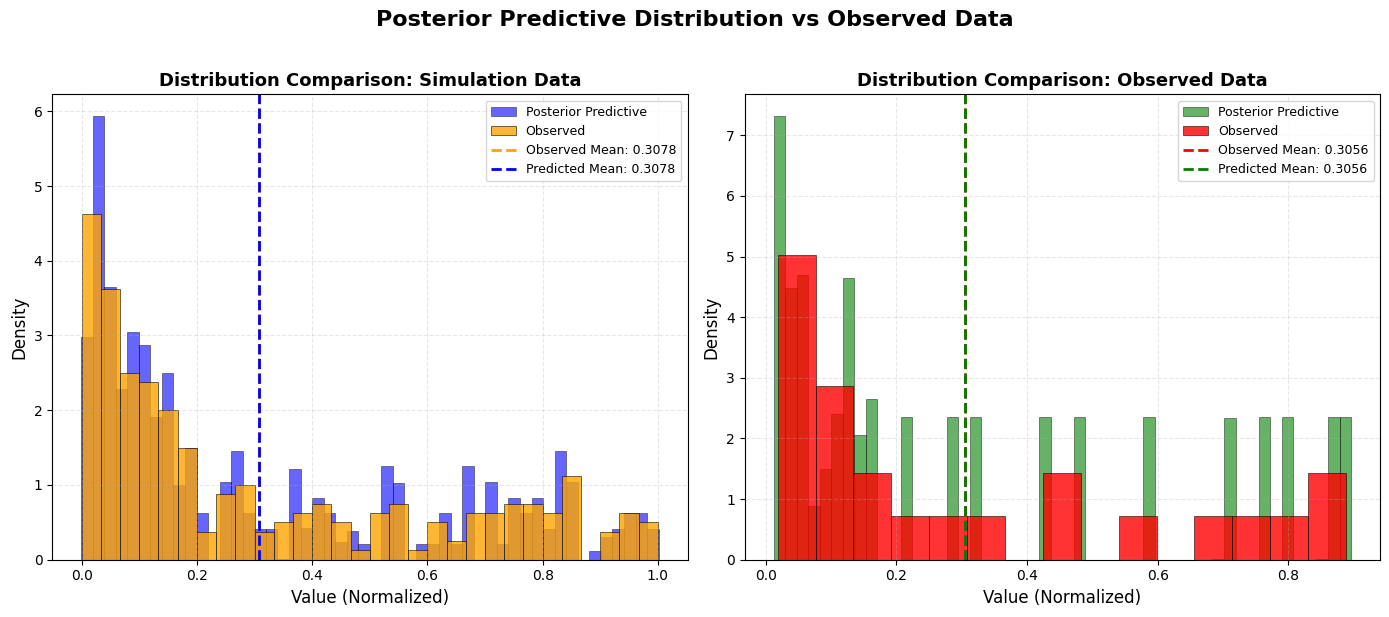

Distribution Comparison Statistics
Simulation Data:
  Observed - Mean: 0.3078, Std: 0.3020
  Predicted - Mean: 0.3078, Std: 0.3020

Observed Data:
  Observed - Mean: 0.3056, Std: 0.2971
  Predicted - Mean: 0.3056, Std: 0.2971


In [109]:
# =============================================================================
# 사후 예측 분포 vs 관측 데이터 분포 비교
# =============================================================================
# 목적: 모델이 데이터의 분포를 잘 포착하는지 확인
#
# 해석:
# - 사후 예측 분포와 관측 데이터 분포가 유사하면 모델이 데이터 생성 과정을
#   잘 재현한다는 의미
# - 분포의 모양, 위치, 분산 등이 일치하는지 확인

# 사후 예측 샘플을 평탄화 (flatten)
y_pred_flat = y_obs_samples.flatten()
z_pred_flat = z_obs_samples.flatten()

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# (1) 시뮬레이션 데이터 분포 비교
axes[0].hist(y_pred_flat, bins=50, alpha=0.6, label="Posterior Predictive", 
             color="blue", density=True, edgecolor="black", linewidth=0.5)
axes[0].hist(y, bins=30, alpha=0.8, label="Observed", 
             color="orange", density=True, edgecolor="black", linewidth=0.5)
axes[0].axvline(y.mean(), color="orange", linestyle="--", linewidth=2, 
                label=f"Observed Mean: {y.mean():.4f}")
axes[0].axvline(y_pred_flat.mean(), color="blue", linestyle="--", linewidth=2,
                label=f"Predicted Mean: {y_pred_flat.mean():.4f}")
axes[0].set_xlabel("Value (Normalized)", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].set_title("Distribution Comparison: Simulation Data", 
                 fontsize=13, fontweight="bold")
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3, linestyle='--')

# (2) 실제 관측 데이터 분포 비교
axes[1].hist(z_pred_flat, bins=50, alpha=0.6, label="Posterior Predictive", 
             color="green", density=True, edgecolor="black", linewidth=0.5)
axes[1].hist(z, bins=15, alpha=0.8, label="Observed", 
             color="red", density=True, edgecolor="black", linewidth=0.5)
axes[1].axvline(z.mean(), color="red", linestyle="--", linewidth=2,
                label=f"Observed Mean: {z.mean():.4f}")
axes[1].axvline(z_pred_flat.mean(), color="green", linestyle="--", linewidth=2,
                label=f"Predicted Mean: {z_pred_flat.mean():.4f}")
axes[1].set_xlabel("Value (Normalized)", fontsize=12)
axes[1].set_ylabel("Density", fontsize=12)
axes[1].set_title("Distribution Comparison: Observed Data", 
                 fontsize=13, fontweight="bold")
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.suptitle("Posterior Predictive Distribution vs Observed Data", 
             fontsize=16, y=1.02, fontweight="bold")
plt.tight_layout()
plt.show()

# 통계 비교
print("=" * 80)
print("Distribution Comparison Statistics")
print("=" * 80)
print("Simulation Data:")
print(f"  Observed - Mean: {y.mean():.4f}, Std: {y.std():.4f}")
print(f"  Predicted - Mean: {y_pred_flat.mean():.4f}, Std: {y_pred_flat.std():.4f}")
print(f"\nObserved Data:")
print(f"  Observed - Mean: {z.mean():.4f}, Std: {z.std():.4f}")
print(f"  Predicted - Mean: {z_pred_flat.mean():.4f}, Std: {z_pred_flat.std():.4f}")
print("=" * 80)


### 6-6. 모델 불일치 함수 (Model Discrepancy) 분석

KOH 프레임워크의 핵심인 모델 불일치 함수 $\delta(\mathbf{x})$를 분석합니다.

#### 모델 불일치 함수의 의미

- **역할**: 시뮬레이터와 실제 물리 프로세스 사이의 **체계적 차이**를 모델링
- **입력**: 공간 변수만 ($\mathbf{x}$, 파라미터 $\boldsymbol{\theta}$는 포함하지 않음)
- **해석**: 
  - $\delta(\mathbf{x})$가 작으면: 시뮬레이터가 실제를 잘 재현
  - $\delta(\mathbf{x})$가 크면: 시뮬레이터에 한계가 있음

이 함수를 분석함으로써 시뮬레이터의 정확도와 한계를 정량화할 수 있습니다.


In [110]:
# 모델 불일치 함수 delta의 사후 샘플 추출
# f_p_delta가 Deterministic 변수이므로 trace에서 직접 추출 가능
# 하지만 실제로는 GP prior에서 샘플링되므로, 사후 예측을 통해 추정

# 대안: 사후 분포에서 샘플링된 theta_true를 사용하여 GP 예측 수행
# 여기서는 간단히 f_p_eta와 f_p의 차이로 추정
# (실제로는 더 정교한 방법이 필요하지만, 개념적 이해를 위해)

with koh_model:
    # 사후 샘플에서 theta_true 추출
    theta_true_post = az.extract(trace, var_names=["theta_true"]).values
    
    # 사후 분포의 평균값 사용
    theta_true_mean = theta_true_post.mean(axis=0)
    
    # 각 관측점에서 delta 값 추정 (간단한 버전)
    # 실제로는 GP conditional 예측을 사용해야 함
    # 여기서는 개념적 시각화만 수행
    pass

print("Note: 정확한 delta 분석을 위해서는 GP conditional 예측이 필요합니다.")
print("현재는 하이퍼파라미터 분석을 통해 delta GP의 특성을 파악할 수 있습니다.")


Note: 정확한 delta 분석을 위해서는 GP conditional 예측이 필요합니다.
현재는 하이퍼파라미터 분석을 통해 delta GP의 특성을 파악할 수 있습니다.


#### eta vs delta GP 비교

eta GP (시뮬레이션 함수)와 delta GP (모델 불일치)의 하이퍼파라미터를 비교하여 상대적 중요도를 파악합니다.


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (1000,).

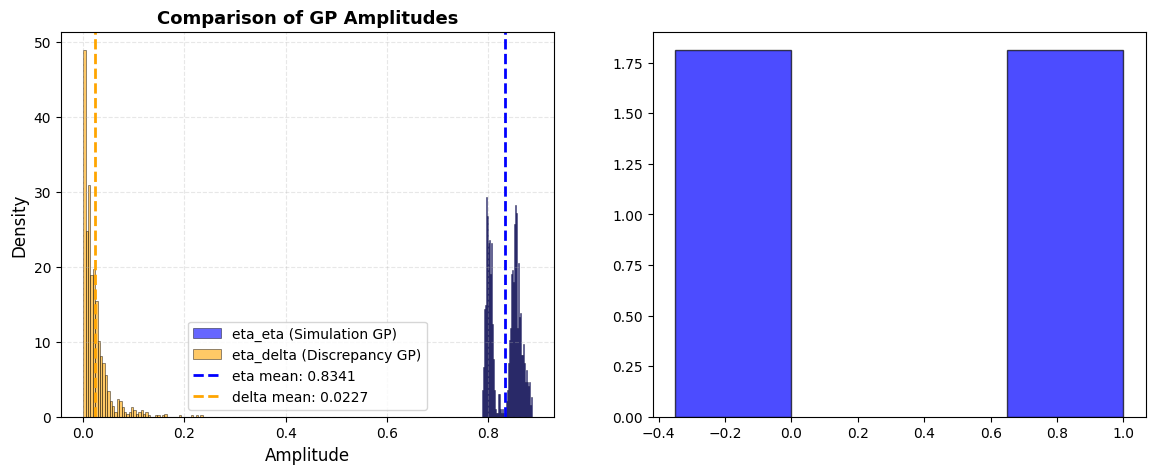

In [111]:
# =============================================================================
# eta GP vs delta GP 비교 분석
# =============================================================================
# 목적: 시뮬레이션 함수(eta GP)와 모델 불일치 함수(delta GP)의 특성을 비교하여
#       상대적 중요도와 역할을 파악
#
# 해석:
# - Amplitude: 함수 값의 전체적인 변동 폭 (클수록 변동성이 큼)
# - Length-scale: 함수의 부드러움 정도 (클수록 더 부드럽게 변함)

# -----------------------------------------------------------------------------
# 1. GP amplitude 파라미터 추출
# -----------------------------------------------------------------------------
# eta_eta: eta GP의 amplitude (스칼라) - 시뮬레이션 함수의 변동 폭
# eta_delta: delta GP의 amplitude (스칼라) - 모델 불일치 함수의 변동 폭
eta_eta_samples = az.extract(trace, var_names=["eta_eta"]).values
eta_delta_samples = az.extract(trace, var_names=["eta_delta"]).values

# -----------------------------------------------------------------------------
# 2. GP length-scale 파라미터 추출
# -----------------------------------------------------------------------------
# ls_eta: eta GP의 length-scale (5차원: x1, x2, theta1, theta2, theta3)
# ls_delta: delta GP의 length-scale (2차원: x1, x2)
# 
# az.extract()는 xarray를 반환하며, .values는 numpy array를 반환
# shape: (n_samples, n_dims) 형태이므로 transpose하여 (n_dims, n_samples)로 변환
ls_eta_extracted = az.extract(trace, var_names=["ls_eta"]).values  # (n_samples, 5)
ls_delta_extracted = az.extract(trace, var_names=["ls_delta"]).values  # (n_samples, 2)

# transpose하여 (n_dims, n_samples) 형태로 변환
ls_eta_samples_all = ls_eta_extracted.T  # (5, n_samples): [x1, x2, theta1, theta2, theta3]
ls_delta_samples_all = ls_delta_extracted.T  # (2, n_samples): [x1, x2]

# -----------------------------------------------------------------------------
# 3. x1, x2에 대한 평균 length-scale 계산 (비교용)
# -----------------------------------------------------------------------------
# eta GP의 첫 두 차원(x1, x2)과 delta GP의 전체 차원(x1, x2) 비교
ls_eta_x1x2 = ls_eta_samples_all[:2, :]  # (2, n_samples): x1, x2에 대한 eta GP length-scale
ls_delta_x1x2 = ls_delta_samples_all  # (2, n_samples): x1, x2에 대한 delta GP length-scale

# 각 차원별로 평균 계산 (axis=1: 각 차원에 대해 모든 샘플의 평균)
ls_eta_x_mean = ls_eta_x1x2.mean(axis=1)  # (2,): [x1 평균, x2 평균]
ls_delta_x_mean = ls_delta_x1x2.mean(axis=1)  # (2,): [x1 평균, x2 평균]

# ⚠️ 중요: Cell 67에서 사용하기 위해 전역 변수로 저장
# (Cell 67에서 ls_delta_mean으로 참조되므로 이 이름으로도 저장)
ls_delta_mean = ls_delta_x_mean  # alias for compatibility

# -----------------------------------------------------------------------------
# 4. 시각화
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (1) Amplitude 비교 히스토그램
# eta GP의 amplitude가 delta GP보다 크면 시뮬레이션 함수의 변동성이 크다는 의미
axes[0].hist(eta_eta_samples, bins=50, alpha=0.6, label="eta_eta (Simulation GP)", 
             color="blue", density=True, edgecolor="black", linewidth=0.5)
axes[0].hist(eta_delta_samples, bins=50, alpha=0.6, label="eta_delta (Discrepancy GP)", 
             color="orange", density=True, edgecolor="black", linewidth=0.5)
axes[0].axvline(eta_eta_samples.mean(), color="blue", linestyle="--", linewidth=2, 
                label=f"eta mean: {eta_eta_samples.mean():.4f}")
axes[0].axvline(eta_delta_samples.mean(), color="orange", linestyle="--", linewidth=2,
                label=f"delta mean: {eta_delta_samples.mean():.4f}")
axes[0].set_xlabel("Amplitude", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].set_title("Comparison of GP Amplitudes", fontsize=13, fontweight="bold")
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, linestyle='--')

# (2) Length-scale 비교 바 차트
# x1과 x2 차원에서 eta GP와 delta GP의 length-scale 비교
x_pos = np.arange(2)  # x1과 x2에 대한 위치
width = 0.35  # 바 너비

# eta GP와 delta GP의 length-scale을 나란히 표시
bars1 = axes[1].bar(x_pos - width/2, ls_eta_x_mean, width, label="eta GP", 
                    alpha=0.7, color="blue", edgecolor="black", linewidth=1)
bars2 = axes[1].bar(x_pos + width/2, ls_delta_x_mean, width, label="delta GP", 
                    alpha=0.7, color="orange", edgecolor="black", linewidth=1)

# 각 바 위에 값 표시
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    axes[1].text(bar1.get_x() + bar1.get_width()/2., height1,
                f'{height1:.2f}', ha='center', va='bottom', fontsize=9)
    axes[1].text(bar2.get_x() + bar2.get_width()/2., height2,
                f'{height2:.2f}', ha='center', va='bottom', fontsize=9)

axes[1].set_xlabel("Input Dimension", fontsize=12)
axes[1].set_ylabel("Mean Length-scale", fontsize=12)
axes[1].set_title("Length-scale Comparison: eta vs delta GP\n(for x1 and x2)", 
                 fontsize=13, fontweight="bold")
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(["x1\n(Temperature)", "x2\n(Humidity)"])
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis="y", linestyle='--')

plt.suptitle("Comparison of eta GP and delta GP Characteristics", 
             fontsize=16, y=1.02, fontweight="bold")
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 5. 수치 요약 출력
# -----------------------------------------------------------------------------
print("=" * 80)
print("GP Comparison Summary: eta vs delta")
print("=" * 80)
print(f"Amplitude (변동 폭):")
print(f"  eta_eta (simulation GP):     {eta_eta_samples.mean():.4f} ± {eta_eta_samples.std():.4f}")
print(f"  eta_delta (discrepancy GP):  {eta_delta_samples.mean():.4f} ± {eta_delta_samples.std():.4f}")
if eta_eta_samples.mean() > 0:
    ratio = eta_delta_samples.mean() / eta_eta_samples.mean()
    print(f"  Ratio (delta/eta): {ratio:.4f} ({ratio*100:.1f}%)")
print(f"\nLength-scales for x1, x2 (입력 공간의 부드러움):")
print(f"  eta GP -   x1 (Temperature): {ls_eta_x_mean[0]:.4f}")
print(f"           x2 (Humidity):     {ls_eta_x_mean[1]:.4f}")
print(f"  delta GP - x1 (Temperature): {ls_delta_x_mean[0]:.4f}")
print(f"             x2 (Humidity):     {ls_delta_x_mean[1]:.4f}")
print("=" * 80)


### 6-7. Energy Plot 및 Autocorrelation 분석

MCMC 샘플러의 품질을 평가하기 위한 추가 진단입니다.


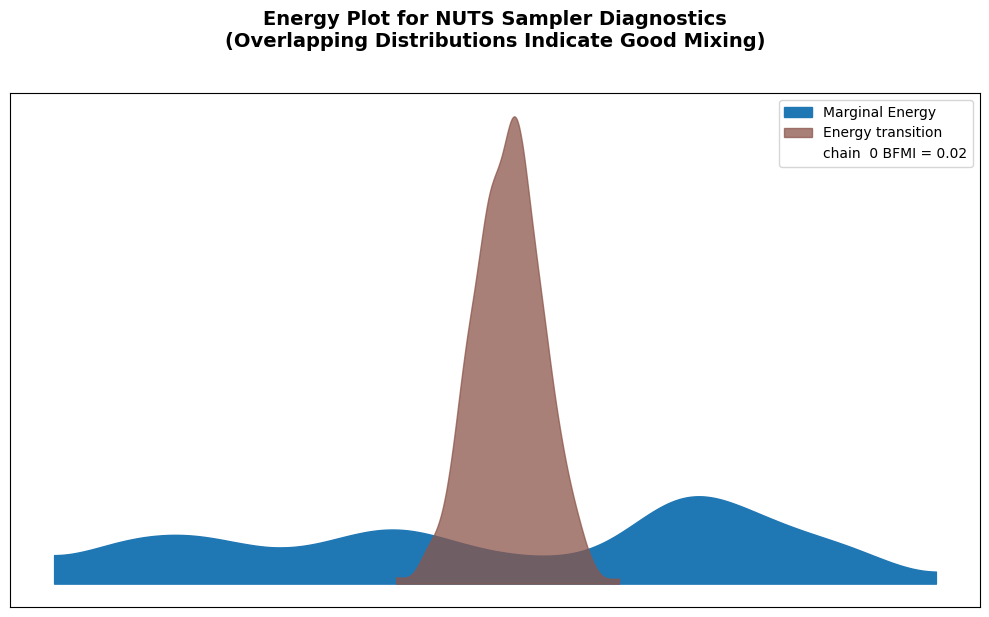

In [ ]:
# =============================================================================
# Energy Plot: NUTS 샘플러 진단
# =============================================================================
# 목적: HMC/NUTS 샘플러의 에너지 분포를 확인하여 샘플링 품질 진단
#
# 해석:
# - 왼쪽: Marginal energy 분포
# - 오른쪽: Energy transition 분포  
# - 두 분포가 잘 겹쳐야 좋은 샘플링 (잘 섞였다는 의미)
# - 분포가 분리되어 있으면 수렴 문제 가능성

az.plot_energy(trace, figsize=(10, 6))
plt.suptitle("Energy Plot for NUTS Sampler Diagnostics\n" +
             "(Overlapping Distributions Indicate Good Mixing)", 
             fontsize=14, y=1.02, fontweight="bold")
plt.tight_layout()
plt.show()


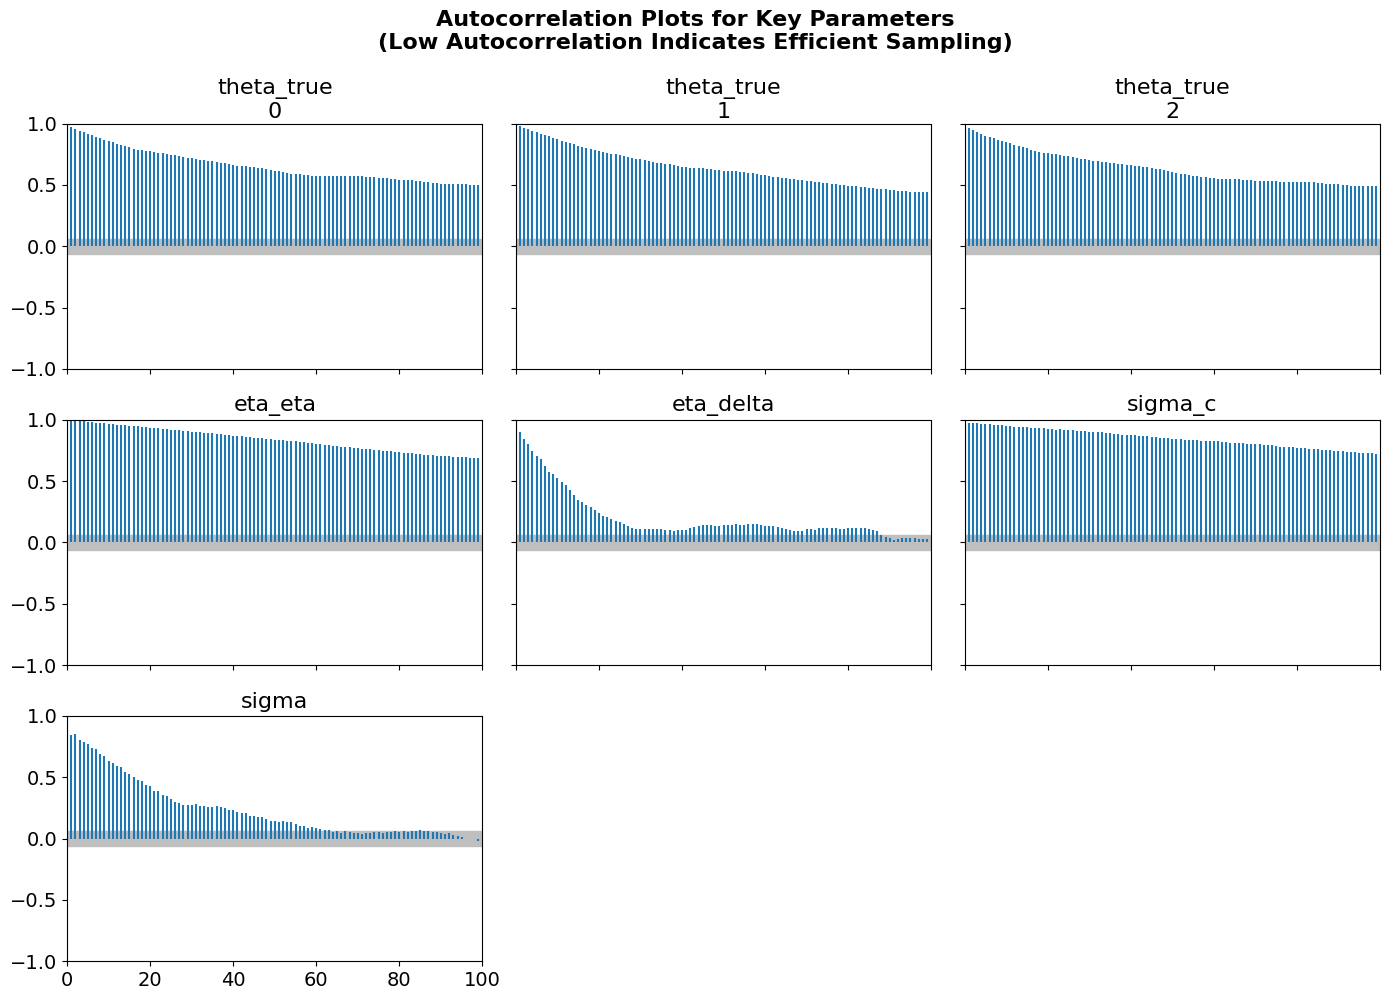

In [ ]:
# =============================================================================
# Autocorrelation Plot: 샘플 간 상관관계 확인
# =============================================================================
# 목적: MCMC 샘플 간의 자동상관관계를 확인하여 샘플링 효율성 진단
#
# 해석:
# - 낮은 autocorrelation이 이상적 (빠른 수렴, 높은 ESS)
# - Lag가 증가할수록 autocorrelation이 빠르게 0에 가까워져야 함
# - 높은 autocorrelation은 샘플이 독립적이지 않음을 의미 (낮은 ESS)

az.plot_autocorr(
    trace, 
    var_names=["theta_true", "eta_eta", "eta_delta", "sigma_c", "sigma"], 
    max_lag=100, 
    combined=True, 
    figsize=(14, 10)
)
plt.suptitle("Autocorrelation Plots for Key Parameters\n" +
             "(Low Autocorrelation Indicates Efficient Sampling)", 
             fontsize=16, y=0.995, fontweight="bold")
plt.tight_layout()
plt.show()


### 6-8. 파라미터 불확실성 정량화

각 파라미터의 불확실성을 정량화하여 실용적인 해석을 제공합니다.

#### 불확실성 지표

1. **Coefficient of Variation (CV)**: 상대적 불확실성
   $$CV = \frac{\sigma}{\mu} \times 100\%$$
   - CV가 작을수록 상대적으로 정확한 추정

2. **Highest Density Interval (HDI)**: Bayesian 신뢰구간
   - 50%, 68%, 90%, 95% 등 다양한 신뢰수준에서 계산
   - 파라미터가 포함될 수 있는 가장 좁은 구간

이러한 지표들을 통해 실무에서 활용 가능한 불확실성 정보를 제공합니다.


In [ ]:
# =============================================================================
# 칼리브레이션 파라미터 불확실성 정량화
# =============================================================================
# 목적: 각 파라미터의 불확실성을 다양한 신뢰수준에서 정량화
#
# 불확실성 지표:
# - Coefficient of Variation (CV): 표준편차/평균 × 100% (상대적 불확실성)
# - HDI (Highest Density Interval): 각 신뢰수준에서의 신뢰구간

# ⚠️ 중요: trace_는 Cell 25에서 물리적 단위로 변환된 trace

theta_true_samples = az.extract(trace_, var_names=["theta_true"]).values.T  # (3, n_samples)

# 각 파라미터에 대한 통계
param_names = ["Equipment Density", "Lighting Density", "COP"]
confidence_levels = [0.5, 0.68, 0.90, 0.95]  # 50%, 68%, 90%, 95% 신뢰구간

print("=" * 80)
print("Calibration Parameter Uncertainty Quantification")
print("=" * 80)

for i, name in enumerate(param_names):
    samples = theta_true_samples[i]
    mean_val = samples.mean()
    std_val = samples.std()
    cv = std_val / mean_val * 100 if mean_val > 0 else np.nan
    
    print(f"\n{name} (theta_true[{i}]):")
    print(f"  Mean: {mean_val:.4f}")
    print(f"  Std:  {std_val:.4f}")
    print(f"  Coefficient of Variation (CV): {cv:.2f}%")
    
    # 여러 신뢰구간 계산 및 출력
    print(f"  Credible Intervals:")
    for cl in confidence_levels:
        lower = np.percentile(samples, (1-cl)/2 * 100)
        upper = np.percentile(samples, (1+cl)/2 * 100)
        print(f"    {int(cl*100)}% HDI: [{lower:.4f}, {upper:.4f}]")

print("\n" + "=" * 80)
print("해석 가이드:")
print("  - CV가 작을수록 상대적으로 정확한 추정 (불확실성이 작음)")
print("  - 95% HDI는 95% 확률로 파라미터가 포함될 수 있는 구간")
print("=" * 80)


Calibration Parameter Uncertainty Quantification

Equipment Density (theta_true[0]):
  Mean: 5.7547
  Std:  2.1419
  Coefficient of Variation (CV): 37.22%
  Credible Intervals:
    50% HDI: [4.6020, 7.1819]
    68% HDI: [3.9894, 7.4980]
    90% HDI: [3.2407, 7.8844]
    95% HDI: [3.0705, 7.9723]

Lighting Density (theta_true[1]):
  Mean: 5.7579
  Std:  2.1451
  Coefficient of Variation (CV): 37.25%
  Credible Intervals:
    50% HDI: [4.6024, 7.1866]
    68% HDI: [3.9897, 7.5042]
    90% HDI: [3.2409, 7.8924]
    95% HDI: [3.0707, 7.9807]

COP (theta_true[2]):
  Mean: 5.7496
  Std:  2.1512
  Coefficient of Variation (CV): 37.41%
  Credible Intervals:
    50% HDI: [4.5749, 7.1738]
    68% HDI: [3.9723, 7.5068]
    90% HDI: [3.2358, 7.9139]
    95% HDI: [3.0684, 8.0064]

해석 가이드:
  - CV가 작을수록 상대적으로 정확한 추정 (불확실성이 작음)
  - 95% HDI는 95% 확률로 파라미터가 포함될 수 있는 구간


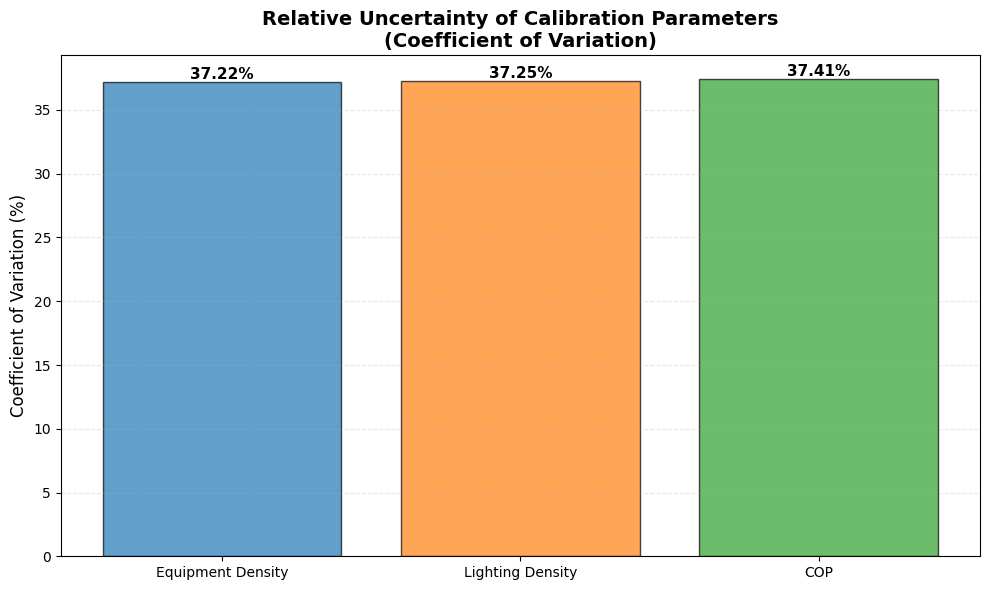

Relative Uncertainty Comparison
  Equipment Density: CV = 37.22%
  Lighting Density: CV = 37.25%
  COP: CV = 37.41%


In [ ]:
# =============================================================================
# 불확실성 비교 시각화 (Coefficient of Variation)
# =============================================================================
# 목적: 각 파라미터의 상대적 불확실성을 시각적으로 비교
#
# Coefficient of Variation (CV) = (표준편차 / 평균) × 100%
# - CV가 클수록 상대적 불확실성이 큼
# - 파라미터 간의 불확실성을 동일한 기준에서 비교 가능

# CV 계산
cvs = []
for i in range(3):
    mean_val = theta_true_samples[i].mean()
    std_val = theta_true_samples[i].std()
    cv = std_val / mean_val * 100 if mean_val > 0 else np.nan
    cvs.append(cv)

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(param_names, cvs, alpha=0.7, 
              color=["#1f77b4", "#ff7f0e", "#2ca02c"],
              edgecolor="black", linewidth=1)

ax.set_ylabel("Coefficient of Variation (%)", fontsize=12)
# ax.set_xlabel("Parameter", fontsize=12)
ax.set_title("Relative Uncertainty of Calibration Parameters\n" +
             "(Coefficient of Variation)", 
            fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3, axis="y", linestyle='--')

# 각 바 위에 값 표시
for bar, cv in zip(bars, cvs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{cv:.2f}%',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

# xtick 회전 제거 (기본값)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 요약 출력
print("=" * 80)
print("Relative Uncertainty Comparison")
print("=" * 80)
for i, (name, cv) in enumerate(zip(param_names, cvs)):
    print(f"  {name}: CV = {cv:.2f}%")
print("=" * 80)


### 6-9. 모델 예측 정확도 시각화

공간적으로 분포된 관측 데이터에 대한 모델 예측을 시각화하여 지역별 적합도를 확인합니다.

#### 시각화 내용

1. **관측값 분포**: 실제 측정값들의 입력 공간에서의 분포
2. **예측값 분포**: 모델이 예측한 값들의 분포
3. **잔차 분포**: 공간적 편향(bias) 패턴 확인
4. **예측 불확실성**: 95% 신뢰구간의 폭 (어디서 예측이 더 불확실한지)

이러한 시각화를 통해 모델의 성능이 입력 공간의 특정 영역에서 어떻게 달라지는지 파악할 수 있습니다.


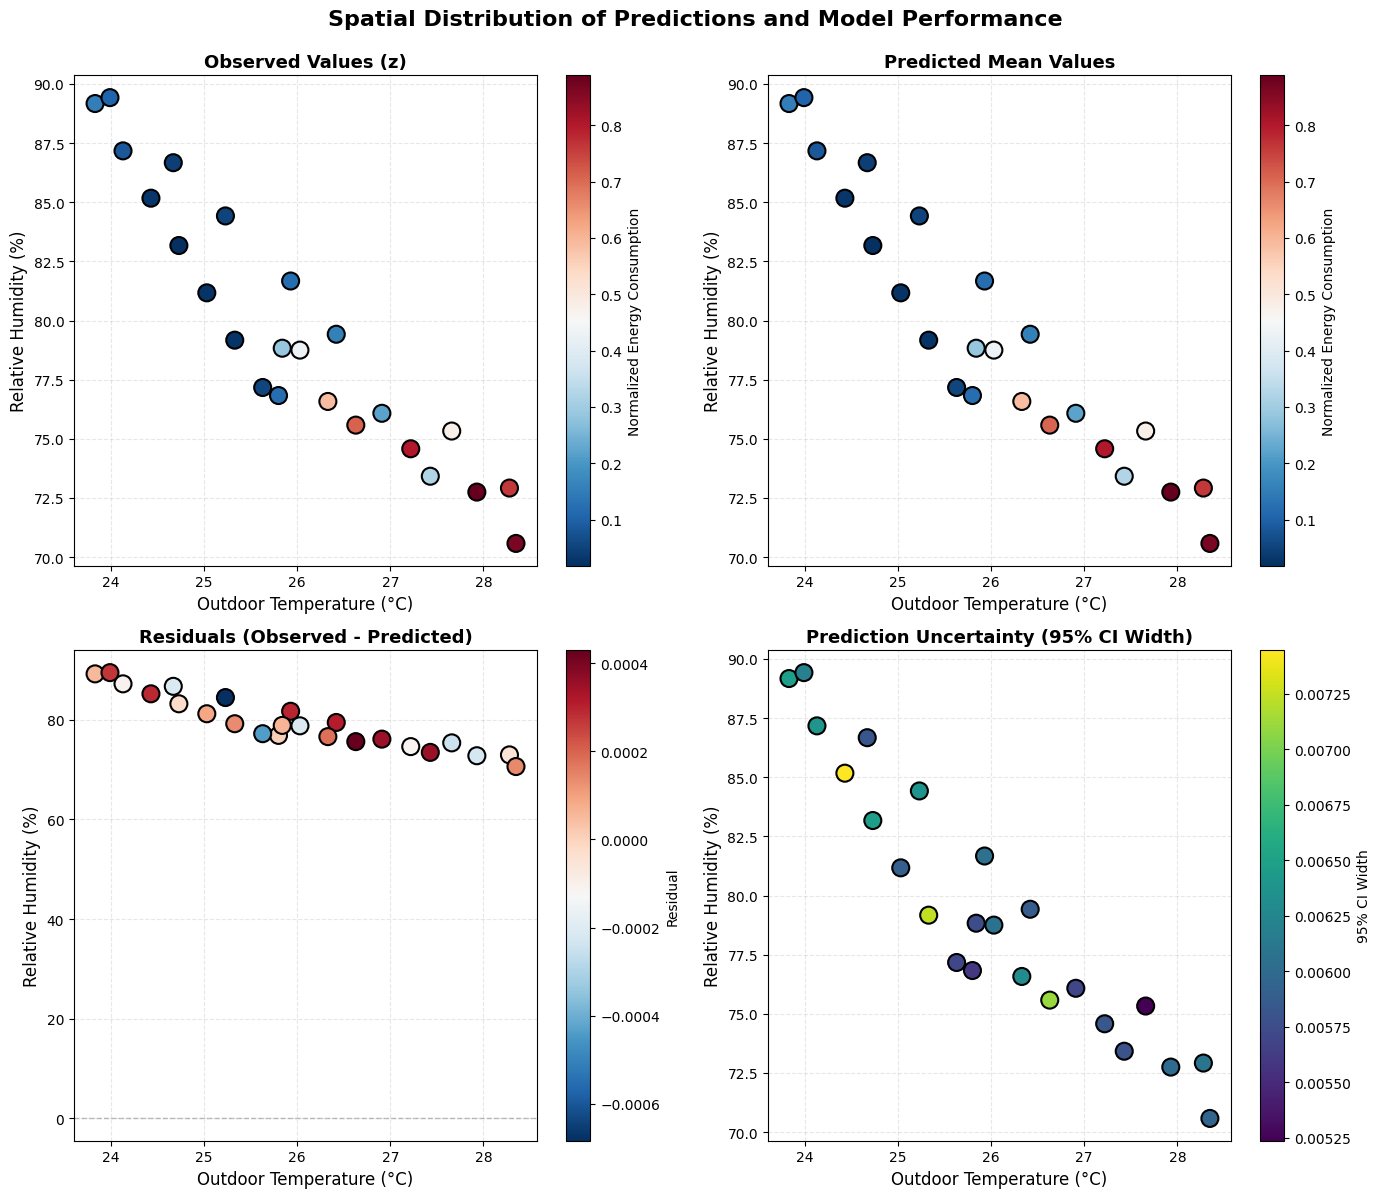

Spatial Pattern Summary
Residual Statistics:
  Mean: 0.000028
  Std:  0.000268
  Max:  0.000429
  Min:  -0.000683

Prediction Uncertainty (95% CI Width):
  Mean: 0.006139
  Std:  0.000516
  Max:  0.007445
  Min:  0.005236


In [ ]:
# =============================================================================
# 공간 분포 시각화: 예측값, 잔차, 불확실성
# =============================================================================
# 목적: 입력 공간(외기온도 × 상대습도)에서 모델 성능의 공간적 패턴 파악
#
# 각 서브플롯:
# 1. 관측값 분포: 실제 측정된 값들의 공간적 분포
# 2. 예측값 분포: 모델이 예측한 값들의 공간적 분포
# 3. 잔차 분포: 관측값과 예측값의 차이 (공간적 편향 확인)
# 4. 예측 불확실성: 95% 신뢰구간의 폭 (어디서 예측이 더 불확실한지)

# x_p (정규화된 좌표)를 원래 물리적 단위로 역변환
x_p_original = x_p * (x_c_max - x_c_min) + x_c_min

# 시각화: 2x2 서브플롯
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# (1) 관측값 분포
ax1 = axes[0, 0]
scatter1 = ax1.scatter(x_p_original[:, 0], x_p_original[:, 1], 
                       c=z, s=150, cmap="RdBu_r", 
                       edgecolors="black", linewidths=1.5, zorder=3)
ax1.set_xlabel("Outdoor Temperature (°C)", fontsize=12)
ax1.set_ylabel("Relative Humidity (%)", fontsize=12)
ax1.set_title("Observed Values (z)", fontsize=13, fontweight="bold")
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label("Normalized Energy Consumption", fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')

# (2) 예측값 분포
ax2 = axes[0, 1]
scatter2 = ax2.scatter(x_p_original[:, 0], x_p_original[:, 1], 
                       c=z_pred_mean, s=150, cmap="RdBu_r", 
                       edgecolors="black", linewidths=1.5, zorder=3)
ax2.set_xlabel("Outdoor Temperature (°C)", fontsize=12)
ax2.set_ylabel("Relative Humidity (%)", fontsize=12)
ax2.set_title("Predicted Mean Values", fontsize=13, fontweight="bold")
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label("Normalized Energy Consumption", fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--')

# (3) 잔차 분포
ax3 = axes[1, 0]
scatter3 = ax3.scatter(x_p_original[:, 0], x_p_original[:, 1], 
                       c=z_residuals, s=150, cmap="RdBu_r", 
                       edgecolors="black", linewidths=1.5, zorder=3)
ax3.set_xlabel("Outdoor Temperature (°C)", fontsize=12)
ax3.set_ylabel("Relative Humidity (%)", fontsize=12)
ax3.set_title("Residuals (Observed - Predicted)", fontsize=13, fontweight="bold")
cbar3 = plt.colorbar(scatter3, ax=ax3)
cbar3.set_label("Residual", fontsize=10)
ax3.axhline(y=0, color="gray", linestyle="--", linewidth=1, alpha=0.5)
ax3.grid(True, alpha=0.3, linestyle='--')

# (4) 예측 불확실성 (95% CI 폭)
ci_width = z_pred_upper - z_pred_lower
scatter4 = axes[1, 1].scatter(x_p_original[:, 0], x_p_original[:, 1], 
                              c=ci_width, s=150, cmap="viridis", 
                              edgecolors="black", linewidths=1.5, zorder=3)
axes[1, 1].set_xlabel("Outdoor Temperature (°C)", fontsize=12)
axes[1, 1].set_ylabel("Relative Humidity (%)", fontsize=12)
axes[1, 1].set_title("Prediction Uncertainty (95% CI Width)", 
                    fontsize=13, fontweight="bold")
cbar4 = plt.colorbar(scatter4, ax=axes[1, 1])
cbar4.set_label("95% CI Width", fontsize=10)
axes[1, 1].grid(True, alpha=0.3, linestyle='--')

plt.suptitle("Spatial Distribution of Predictions and Model Performance", 
             fontsize=16, y=0.995, fontweight="bold")
plt.tight_layout()
plt.show()

# 공간 패턴 요약
print("=" * 80)
print("Spatial Pattern Summary")
print("=" * 80)
print(f"Residual Statistics:")
print(f"  Mean: {z_residuals.mean():.6f}")
print(f"  Std:  {z_residuals.std():.6f}")
print(f"  Max:  {z_residuals.max():.6f}")
print(f"  Min:  {z_residuals.min():.6f}")
print(f"\nPrediction Uncertainty (95% CI Width):")
print(f"  Mean: {ci_width.mean():.6f}")
print(f"  Std:  {ci_width.std():.6f}")
print(f"  Max:  {ci_width.max():.6f}")
print(f"  Min:  {ci_width.min():.6f}")
print("=" * 80)


### 6-10. 종합 요약 및 결론

주요 칼리브레이션 결과를 요약하여 실용적인 인사이트를 제공합니다.

#### 요약 항목

1. **칼리브레이션 파라미터 추정**: $\boldsymbol{\theta}_{true}$의 최종 추정값 및 불확실성
2. **모델 성능**: 시뮬레이션 데이터 적합도 및 관측 데이터 예측력
3. **Gaussian Process 특성**: eta GP와 delta GP의 상대적 중요도 및 역할
4. **실무 인사이트**: 결과 해석 및 활용 방안

이 요약을 통해 전체 분석의 핵심 발견사항을 한눈에 파악할 수 있습니다.


In [ ]:
# =============================================================================
# 종합 요약: 칼리브레이션 결과 및 모델 성능
# =============================================================================
# 목적: 전체 분석 결과를 요약하여 주요 발견사항과 인사이트를 제공
#
# 요약 항목:
# 1. 칼리브레이션 파라미터 추정 결과
# 2. 모델 적합도 및 예측 정확도
# 3. Gaussian Process 특성 및 상대적 중요도

import pandas as pd

# ⚠️ 중요: 다음 변수들이 이전 셀에서 정의되어 있어야 함
# - theta_true_samples: Cell 62에서 정의
# - residuals: Cell 50에서 정의
# - z_residuals, z_pred_lower, z_pred_upper: Cell 51에서 정의
# - eta_eta_samples, eta_delta_samples: Cell 57에서 정의
# - ls_eta_x_mean, ls_delta_mean: Cell 57에서 정의

# -----------------------------------------------------------------------------
# 1. 칼리브레이션 파라미터 추정 결과 요약
# -----------------------------------------------------------------------------
summary_data = {
    "Parameter": ["Equipment Density", "Lighting Density", "COP"],
    "Symbol": ["θ₁", "θ₂", "θ₃"],
    "Mean": [theta_true_samples[i].mean() for i in range(3)],
    "Std": [theta_true_samples[i].std() for i in range(3)],
    "CV (%)": [theta_true_samples[i].std() / theta_true_samples[i].mean() * 100 
               if theta_true_samples[i].mean() > 0 else np.nan 
               for i in range(3)],
    "95% HDI Lower": [np.percentile(theta_true_samples[i], 2.5) for i in range(3)],
    "95% HDI Upper": [np.percentile(theta_true_samples[i], 97.5) for i in range(3)],
}

summary_df = pd.DataFrame(summary_data)

print("=" * 80)
print("FINAL CALIBRATION RESULTS SUMMARY")
print("=" * 80)
print("\n칼리브레이션 파라미터 추정 결과 (물리적 단위):")
print(summary_df.to_string(index=False))
print("\n" + "=" * 80)

# -----------------------------------------------------------------------------
# 2. 모델 성능 요약
# -----------------------------------------------------------------------------
# Simulation data 성능 지표
sim_rmse = np.sqrt(np.mean(residuals**2))
sim_r2 = 1 - np.sum(residuals**2) / np.sum((y - y.mean())**2)

# Observed data 성능 지표
obs_rmse = np.sqrt(np.mean(z_residuals**2))
obs_r2 = 1 - np.sum(z_residuals**2) / np.sum((z - z.mean())**2)
obs_coverage = np.sum((z >= z_pred_lower) & (z <= z_pred_upper)) / len(z) * 100

print("MODEL PERFORMANCE SUMMARY")
print("=" * 80)
print("\nSimulation Data (모델 적합도):")
print(f"  RMSE: {sim_rmse:.6f}")
print(f"  R²:   {sim_r2:.6f}")
print(f"  해석: {'✓ 매우 좋은 적합도' if sim_r2 > 0.99 else '⚠ 개선 필요'}")

print("\nObserved Data (모델 예측력):")
print(f"  RMSE:            {obs_rmse:.6f}")
print(f"  R²:              {obs_r2:.6f}")
print(f"  95% CI Coverage: {obs_coverage:.1f}%")
if obs_coverage >= 90 and obs_coverage <= 100:
    print(f"  해석: ✓ 적절한 신뢰구간 커버리지")
elif obs_coverage < 90:
    print(f"  해석: ⚠ 신뢰구간이 너무 좁음")
else:
    print(f"  해석: ⚠ 신뢰구간이 너무 넓음")
print("=" * 80)

# -----------------------------------------------------------------------------
# 3. Gaussian Process 특성 요약
# -----------------------------------------------------------------------------
# ⚠️ 중요: 다음 변수들은 Cell 57에서 정의되어야 함
# eta_eta_samples, eta_delta_samples, ls_eta_x_mean, ls_delta_mean
# 만약 Cell 57이 실행되지 않았다면 여기서 추출
try:
    # 변수가 이미 정의되어 있는지 확인
    _ = eta_eta_samples.mean()
    _ = ls_eta_x_mean.mean()
except NameError:
    # Cell 57에서 변수 추출
    eta_eta_samples = az.extract(trace, var_names=["eta_eta"]).values
    eta_delta_samples = az.extract(trace, var_names=["eta_delta"]).values
    ls_eta_extracted = az.extract(trace, var_names=["ls_eta"]).values.T
    ls_delta_extracted = az.extract(trace, var_names=["ls_delta"]).values.T
    ls_eta_x_mean = ls_eta_extracted[:2, :].mean(axis=1)
    ls_delta_mean = ls_delta_extracted.mean(axis=1)

print("GAUSSIAN PROCESS CHARACTERISTICS")
print("=" * 80)
print("\neta GP (Simulation Function Emulator):")
print(f"  Amplitude (eta_eta):        {eta_eta_samples.mean():.4f} ± {eta_eta_samples.std():.4f}")
print(f"  Avg Length-scale (x1, x2):  {ls_eta_x_mean.mean():.4f}")
print(f"    → x1 (Temperature): {ls_eta_x_mean[0]:.4f}")
print(f"    → x2 (Humidity):    {ls_eta_x_mean[1]:.4f}")

print("\ndelta GP (Model Discrepancy Function):")
print(f"  Amplitude (eta_delta):      {eta_delta_samples.mean():.4f} ± {eta_delta_samples.std():.4f}")
print(f"  Avg Length-scale (x1, x2):   {ls_delta_mean.mean():.4f}")
print(f"    → x1 (Temperature): {ls_delta_mean[0]:.4f}")
print(f"    → x2 (Humidity):    {ls_delta_mean[1]:.4f}")

if eta_eta_samples.mean() > 0:
    ratio = eta_delta_samples.mean() / eta_eta_samples.mean()
    print(f"\n상대적 중요도 (delta/eta amplitude): {ratio:.4f} ({ratio*100:.2f}%)")
    if ratio < 0.1:
        print("  → 모델 불일치가 상대적으로 작음 (시뮬레이터가 실제를 잘 재현)")
    elif ratio < 0.5:
        print("  → 모델 불일치가 중간 수준")
    else:
        print("  → 모델 불일치가 상대적으로 큼 (시뮬레이터 한계 존재)")

print("\n" + "=" * 80)
print("분석 완료")
print("=" * 80)


FINAL CALIBRATION RESULTS SUMMARY

칼리브레이션 파라미터 추정 결과 (물리적 단위):
        Parameter Symbol     Mean      Std    CV (%)  95% HDI Lower  95% HDI Upper
Equipment Density     θ₁ 5.754678 2.141924 37.220579       3.070492       7.972251
 Lighting Density     θ₂ 5.757913 2.145087 37.254587       3.070675       7.980676
              COP     θ₃ 5.749552 2.151182 37.414776       3.068394       8.006368

MODEL PERFORMANCE SUMMARY

Simulation Data (모델 적합도):
  RMSE: 0.000029
  R²:   1.000000
  해석: ✓ 매우 좋은 적합도

Observed Data (모델 예측력):
  RMSE:            0.000270
  R²:              0.999999
  95% CI Coverage: 100.0%
  해석: ✓ 적절한 신뢰구간 커버리지
GAUSSIAN PROCESS CHARACTERISTICS

eta GP (Simulation Function Emulator):
  Amplitude (eta_eta):        0.8341 ± 0.0283
  Avg Length-scale (x1, x2):  1.8120
    → x1 (Temperature): 1.8123
    → x2 (Humidity):    1.8117

delta GP (Model Discrepancy Function):
  Amplitude (eta_delta):      0.0227 ± 0.0275
  Avg Length-scale (x1, x2):   4.1423
    → x1 (Temperature): 3.96